In [1]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 20)
options(repr.plot.height = 6)

---
---
---

## Revisiting Time Series Decomposition and (S)ARMA models

We will revisit some of the examples for Time Series Decomposition and Seasonal ARMA model estimation

In [2]:
?fma::airpass

airpass                  package:fma                   R Documentation

_M_o_n_t_h_l_y _A_i_r_l_i_n_e _P_a_s_s_e_n_g_e_r _N_u_m_b_e_r_s _1_9_4_9-_1_9_6_0

_D_e_s_c_r_i_p_t_i_o_n:

     The classic Box & Jenkins airline data. Monthly totals of
     international airline passengers (1949-1960).

_U_s_a_g_e:

     airpass
     
_F_o_r_m_a_t:

     A monthly time series, in thousands.

_S_o_u_r_c_e:

     Makridakis, Wheelwright and Hyndman (1998) _Forecasting: methods
     and applications_, John Wiley & Sons: New York. Exercise 2.4,
     Chapter 3, Exercise 4.7.

_R_e_f_e_r_e_n_c_e_s:

     Box, Jenkins and Reinsell (1994) _Time series analysis:
     forecasting and control_, 3rd edition, Holden-Day: San Francisco.
     Series G.

_E_x_a_m_p_l_e_s:

     plot(airpass)
     seasonplot(airpass)
     tsdisplay(airpass)

In [3]:
airpass <- fma::airpass

We can examine the data plot:

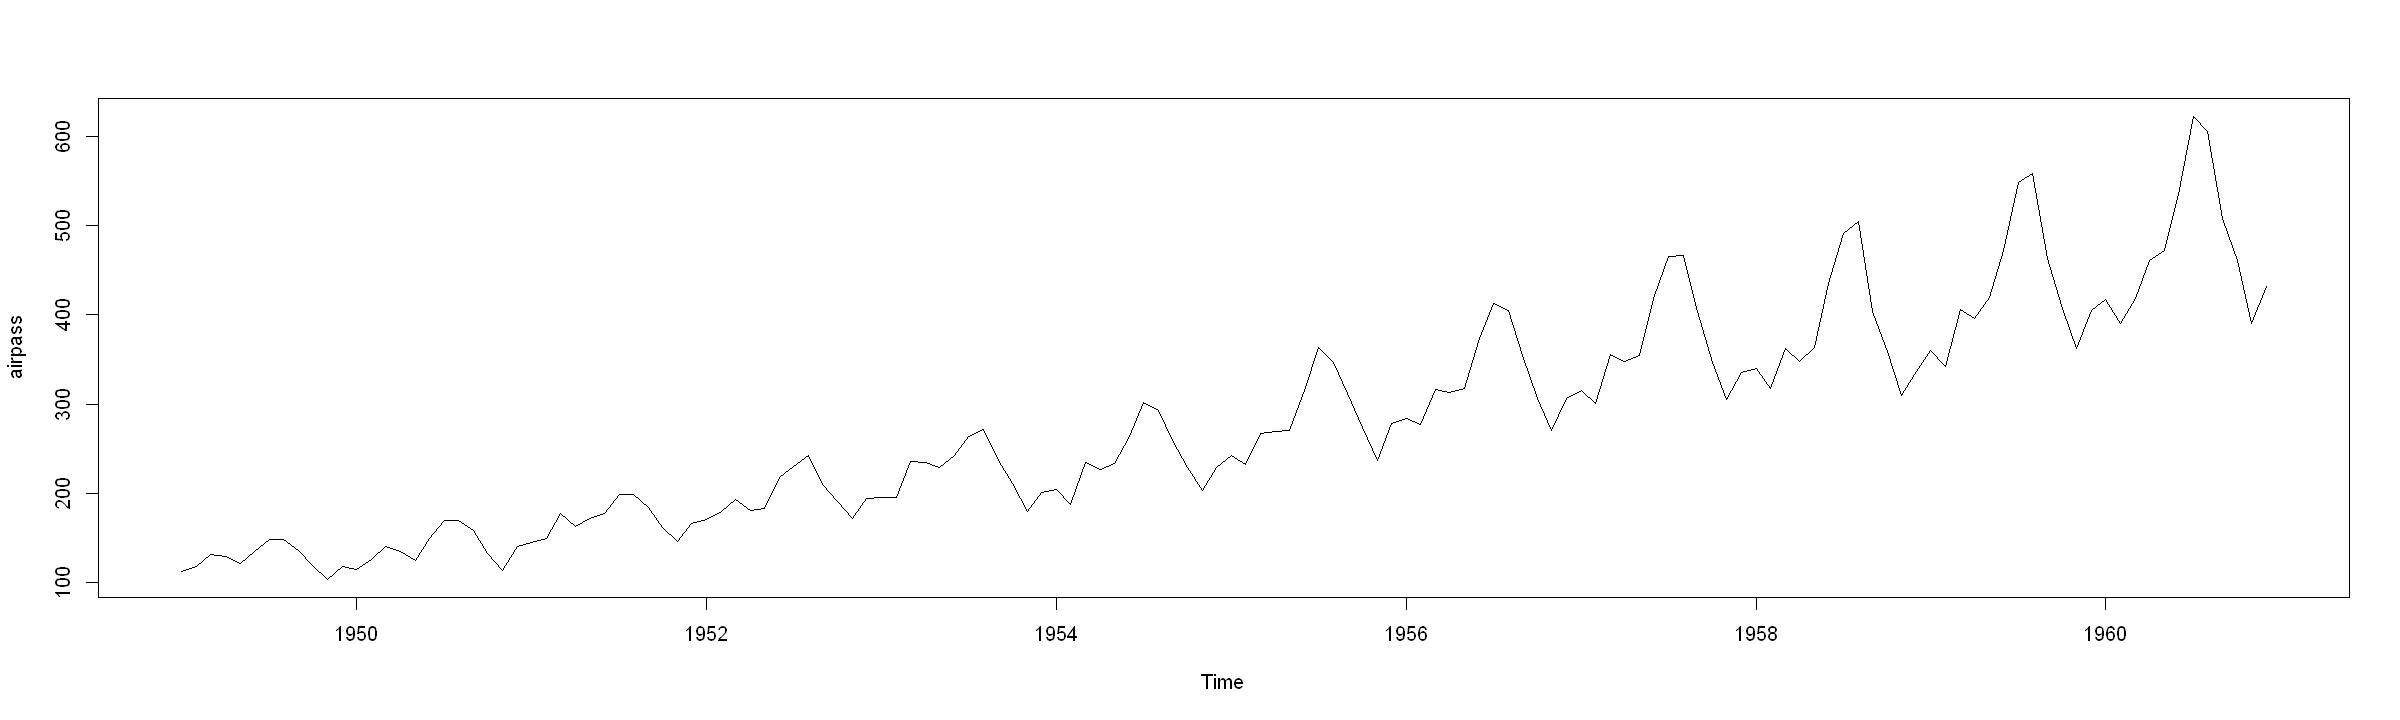

In [4]:
plot.ts(airpass)

----

Note the totak number of years in the series:

In [5]:
total_years <- length(unique(floor(time(airpass))))
print(total_years)

[1] 12


----

We can also plot the seasonal plot:

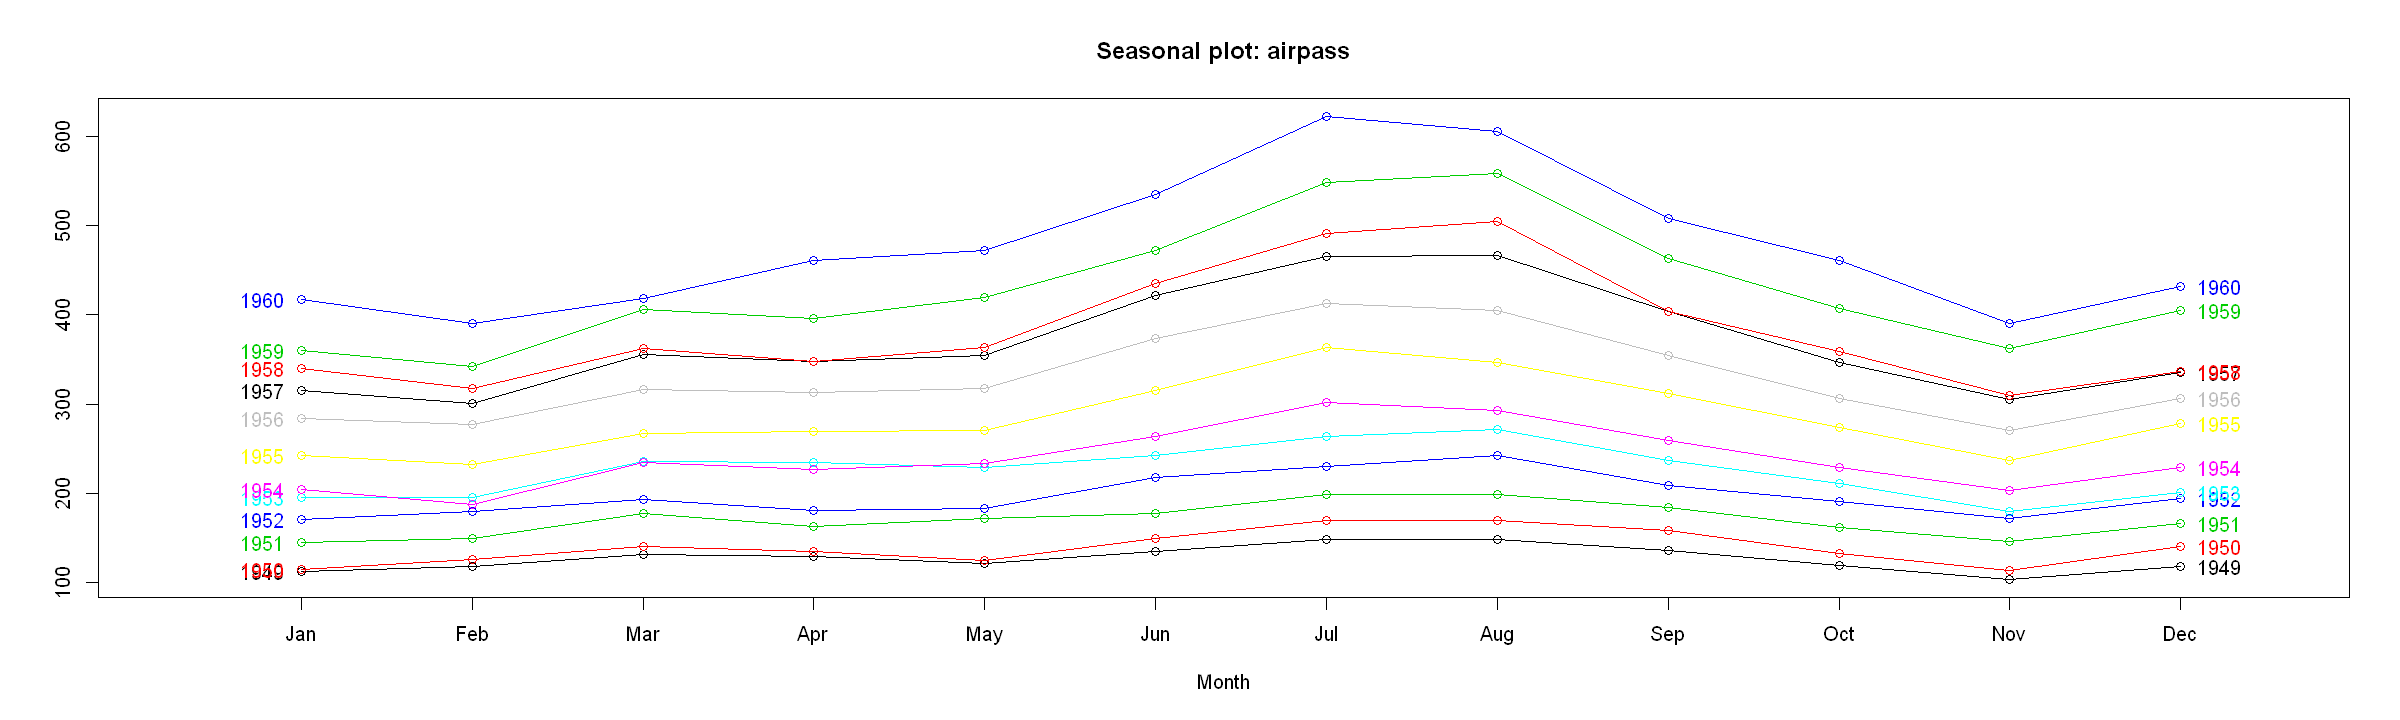

In [6]:
forecast::seasonplot(airpass, year.labels = TRUE, year.labels.left = TRUE, col = 1:total_years)

Looking at the $\rm ACF$ and $\rm PACF$ plots:

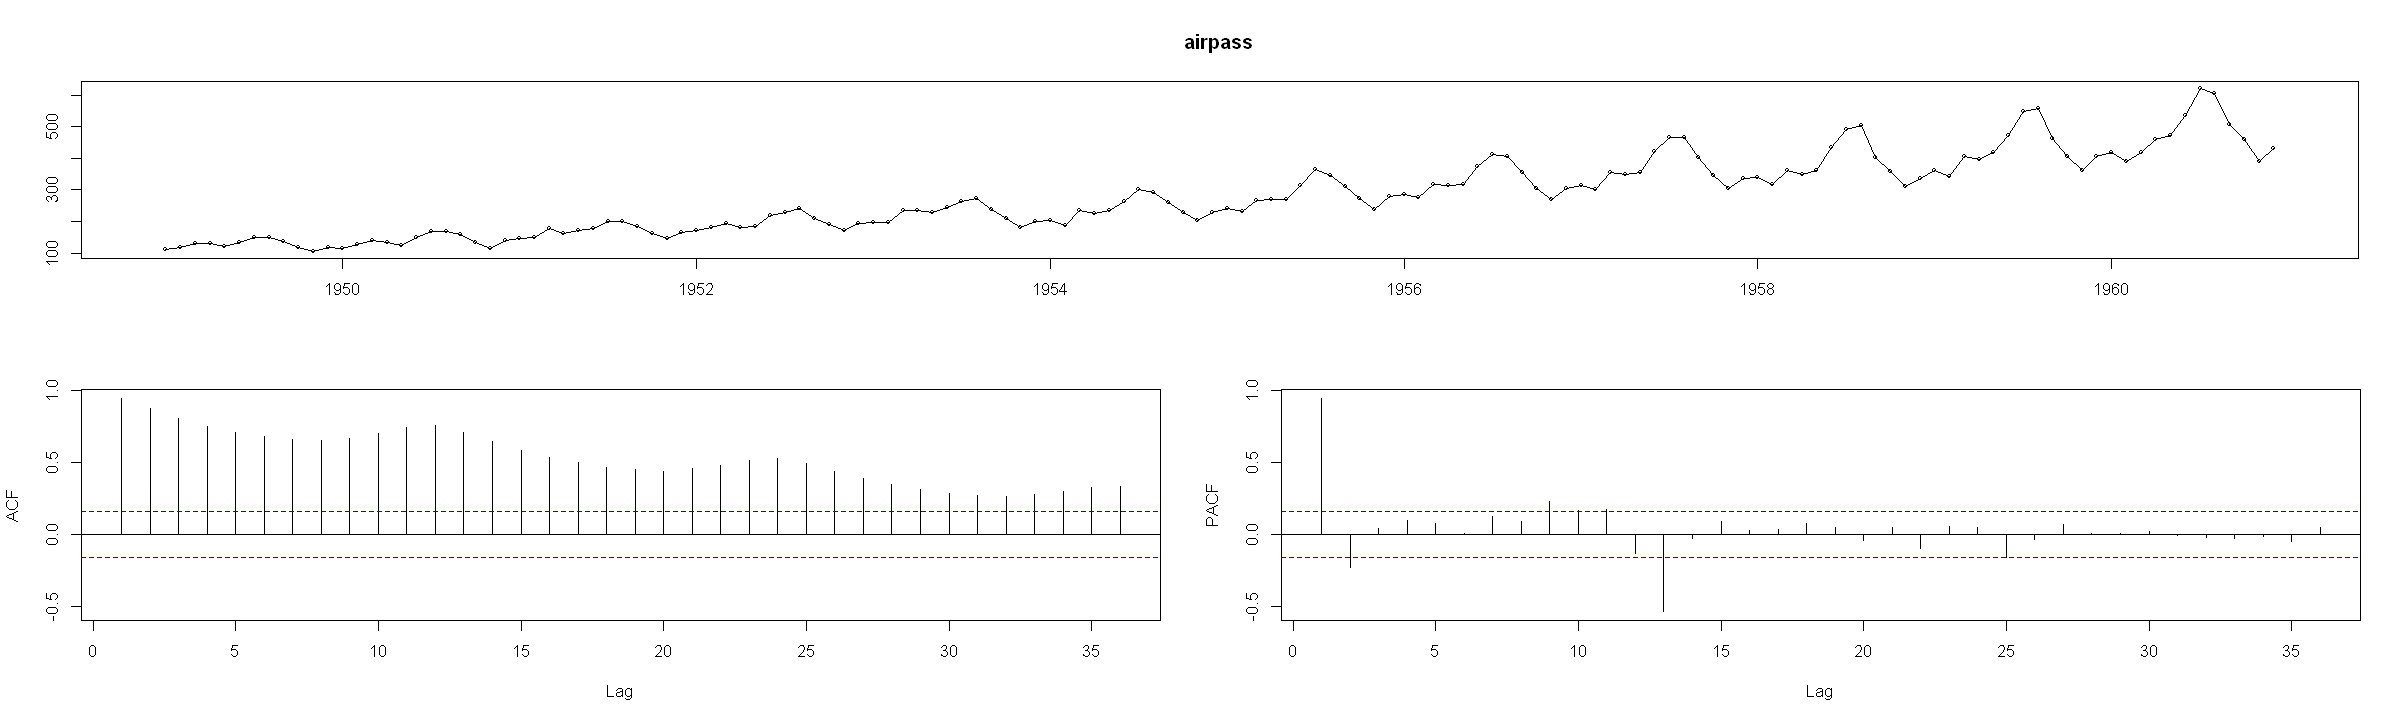

In [7]:
forecast::tsdisplay(airpass)

and note the ACF slowly declining and the decline is in waves, which appear to repeat every `12` lags - this indicates seasonality. The time series chart indicates that there is an increasing trend.

## Time Series Transformation

The variation appears to be increasing, which also indicates that the series may be multiplicative: $Y_t = T_t \cdot S_t \cdot E_t$.

We want to take logarithms of the data, to get an additive form: $\log(Y_t) = \widetilde{Y}_t$ so that $\widetilde{Y}_t = \widetilde{T}_t + \widetilde{S}_t + \widetilde{E}_t$

In [8]:
log_passengers = log(airpass)

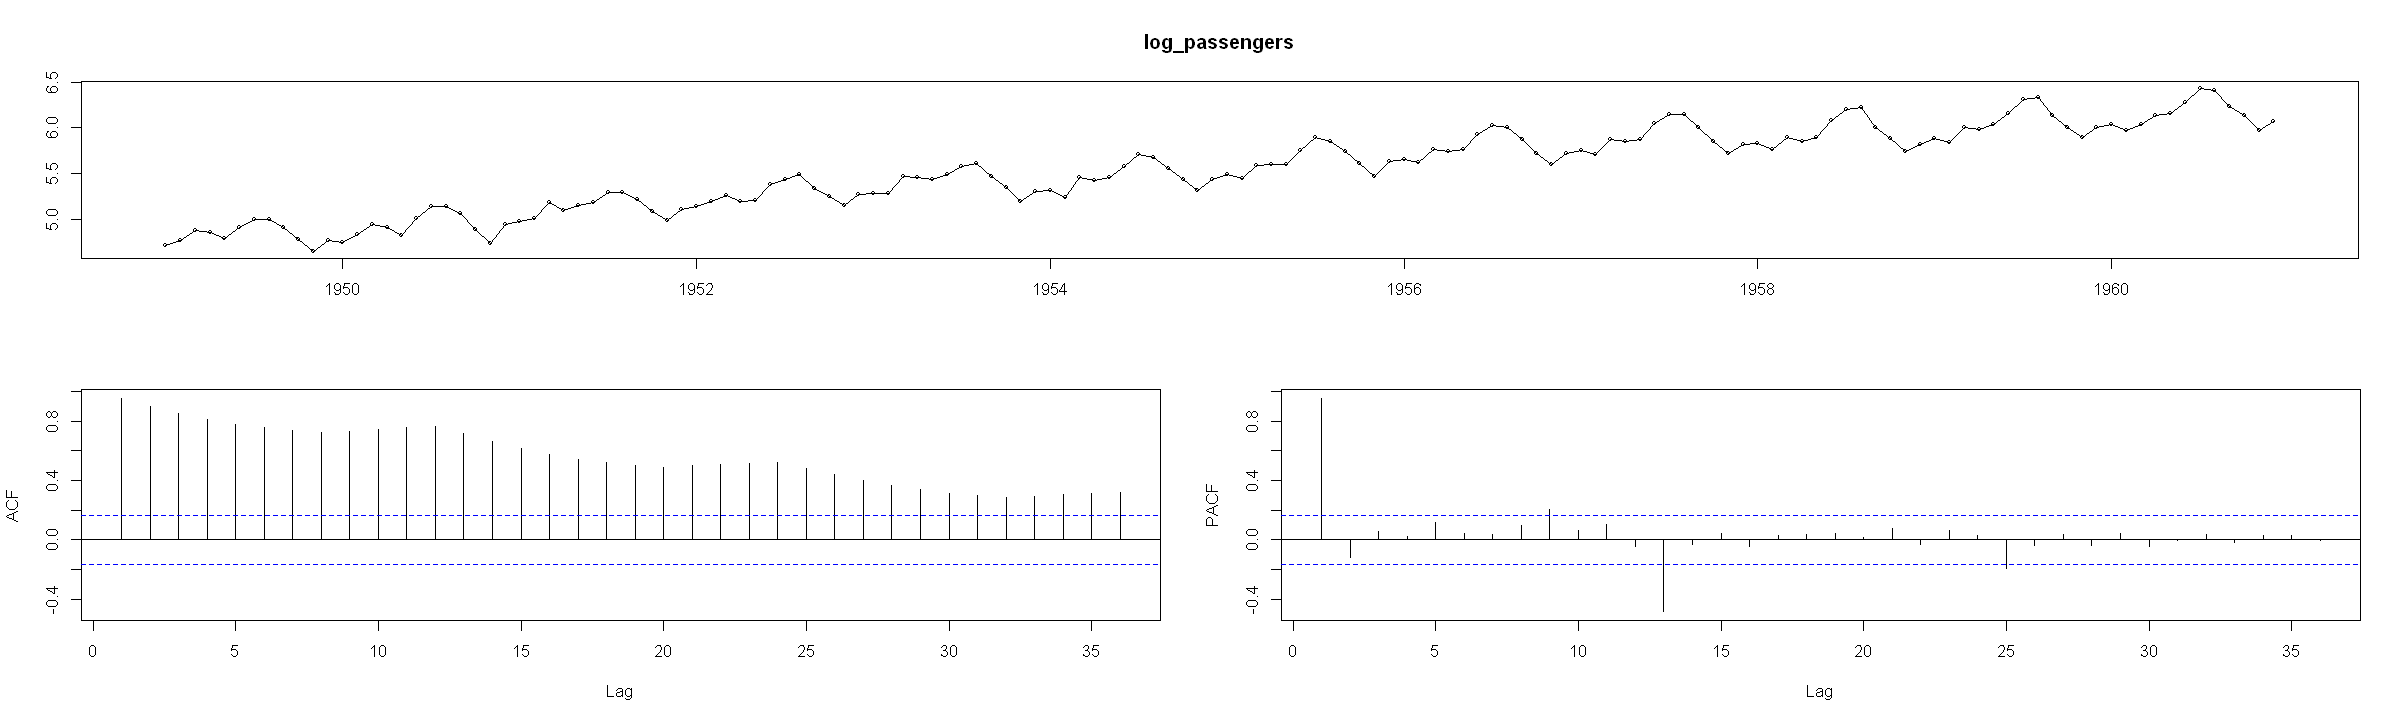

In [9]:
forecast::tsdisplay(log_passengers)

Now the series appears to be additive. We can move on to decomposition of the series.

## Decomposition via Moving-average

### Trend Decomposition

We can decompose the series manually via the `filter(...)` function:

In [10]:
one_sided_trd <- filter(log_passengers, filter = c(1/24, rep(1/12, total_years - 1), 1/24), sides = 1)
two_sided_trd <- filter(log_passengers, filter = c(1/24, rep(1/12, total_years - 1), 1/24), sides = 2)

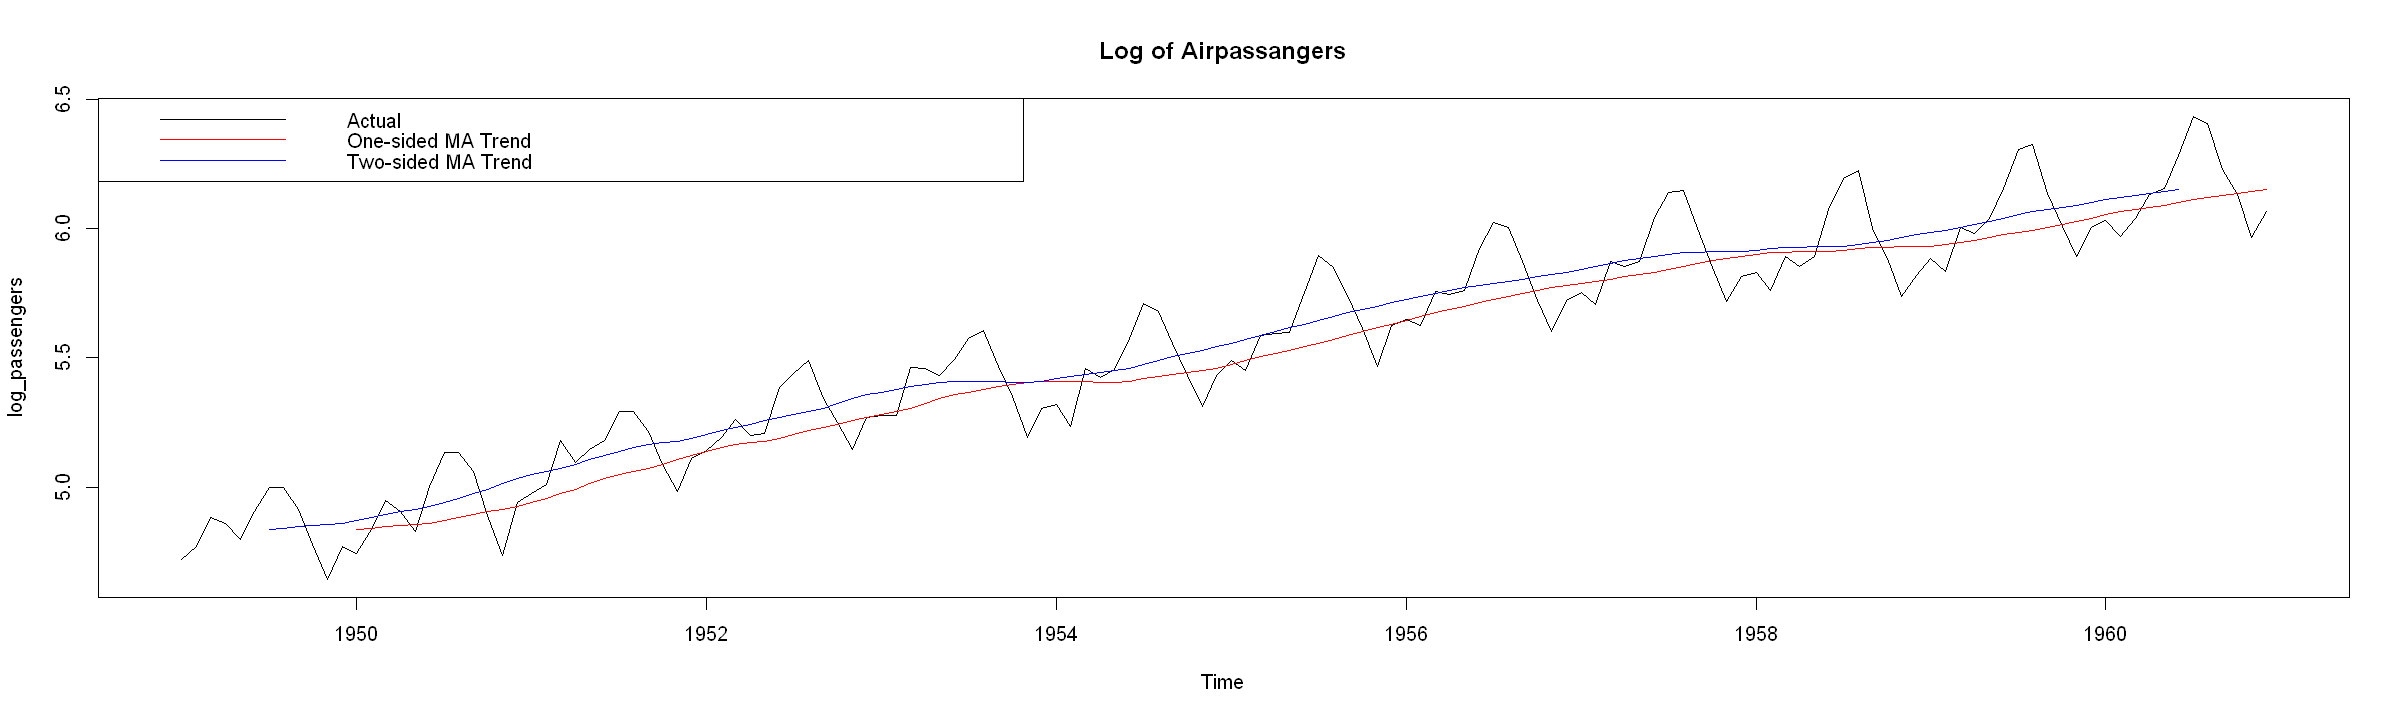

In [11]:
plot.ts(log_passengers, main = "Log of Airpassangers")
lines(one_sided_trd, col = "red")
lines(two_sided_trd, col = "blue")
legend(x = "topleft", legend = c("Actual", "One-sided MA Trend", "Two-sided MA Trend"), lty = 1, col = c("black", "red", "blue"))

### Seasonal Decomposition using the decomposed trend

Next, we move to decompose the seasonality

In [12]:
#seasonal component of one-sided averaging
one_sided_season <- log_passengers - one_sided_trd
one_sided_season <- matrix(one_sided_season, ncol = 12, byrow = TRUE)
one_sided_season <- apply(one_sided_season, 2, mean, na.rm = TRUE)
#seasonal component of two-sided averaging
two_sided_season <- log_passengers - two_sided_trd
two_sided_season <- matrix(two_sided_season, ncol = 12, byrow = TRUE)
two_sided_season <- apply(two_sided_season, 2, mean, na.rm = TRUE)

We then scale the seasons to sum up to 0:

In [13]:
one_sided_season <- one_sided_season - sum(one_sided_season) / length(one_sided_season)

In [14]:
two_sided_season <- two_sided_season - sum(two_sided_season) / length(two_sided_season)

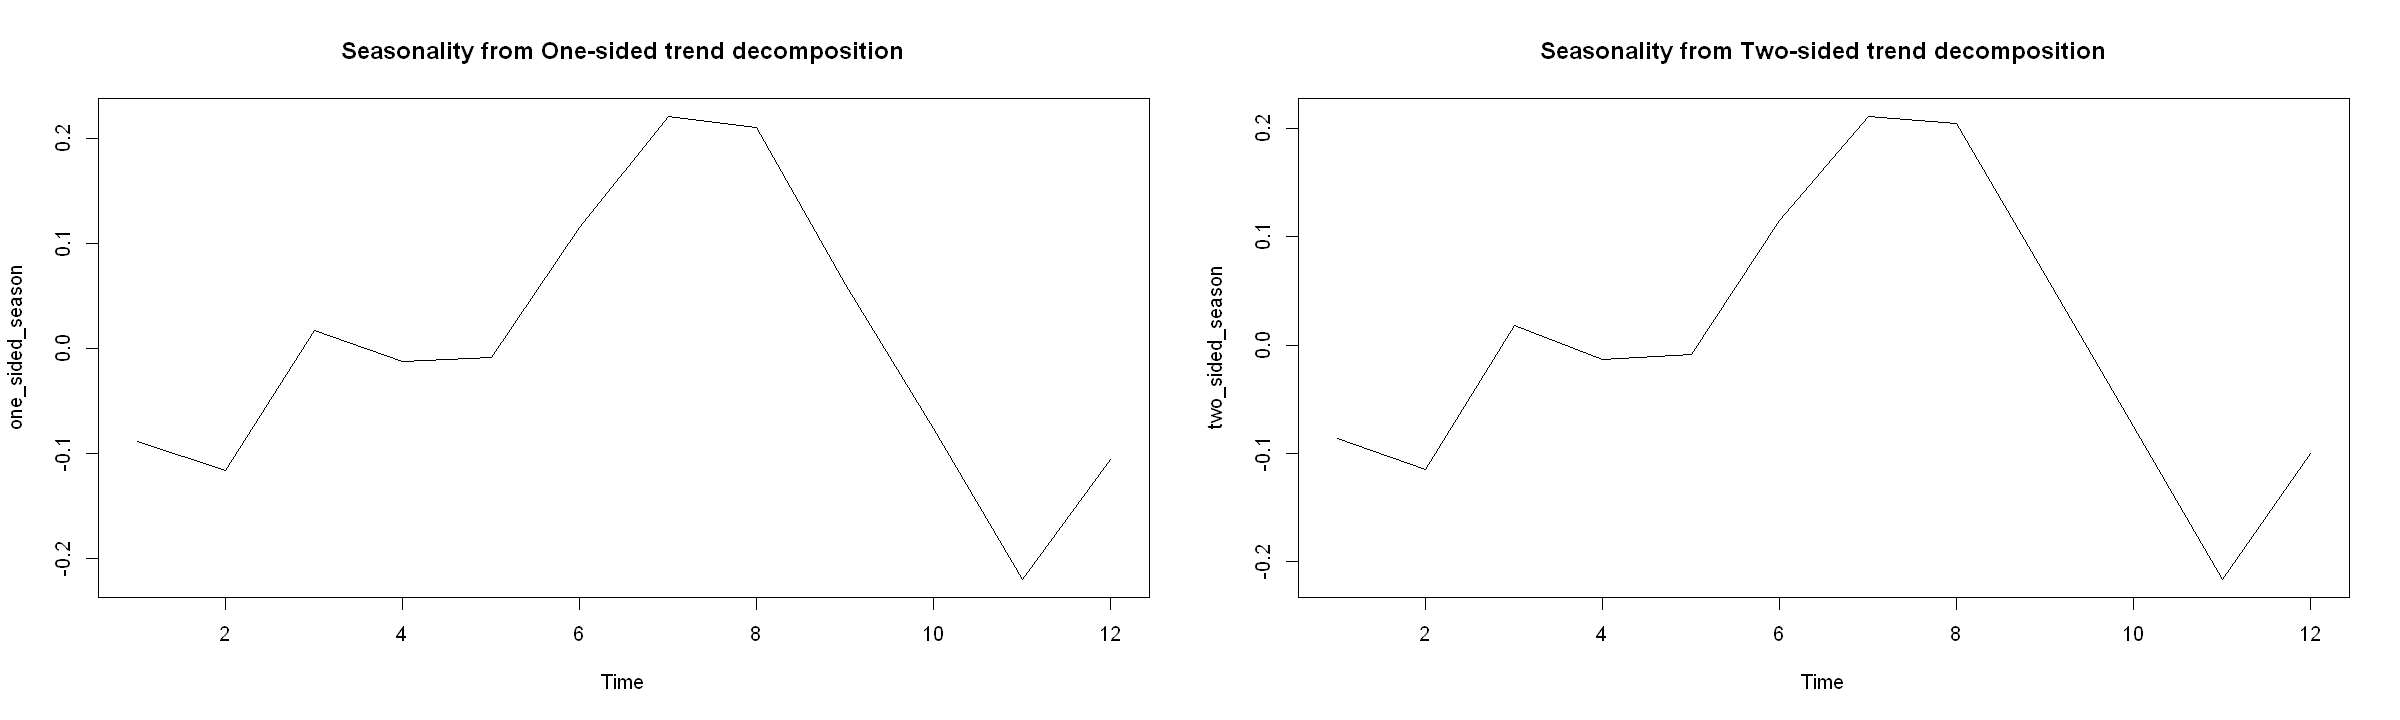

In [15]:
par(mfrow = c(1, 2))
plot.ts(one_sided_season, main = "Seasonality from One-sided trend decomposition")
plot.ts(two_sided_season, main = "Seasonality from Two-sided trend decomposition")

Using $S_t = S_{t+d}$, create the series for the full years:

In [16]:
one_sided_season <- rep(one_sided_season, times = total_years)
one_sided_season <- ts(one_sided_season, start = start(log_passengers), freq = frequency(log_passengers))
#
two_sided_season <- rep(two_sided_season, times = total_years)
two_sided_season <- ts(two_sided_season, start = start(log_passengers), freq = frequency(log_passengers))

Next, we can examine the decomposition visually

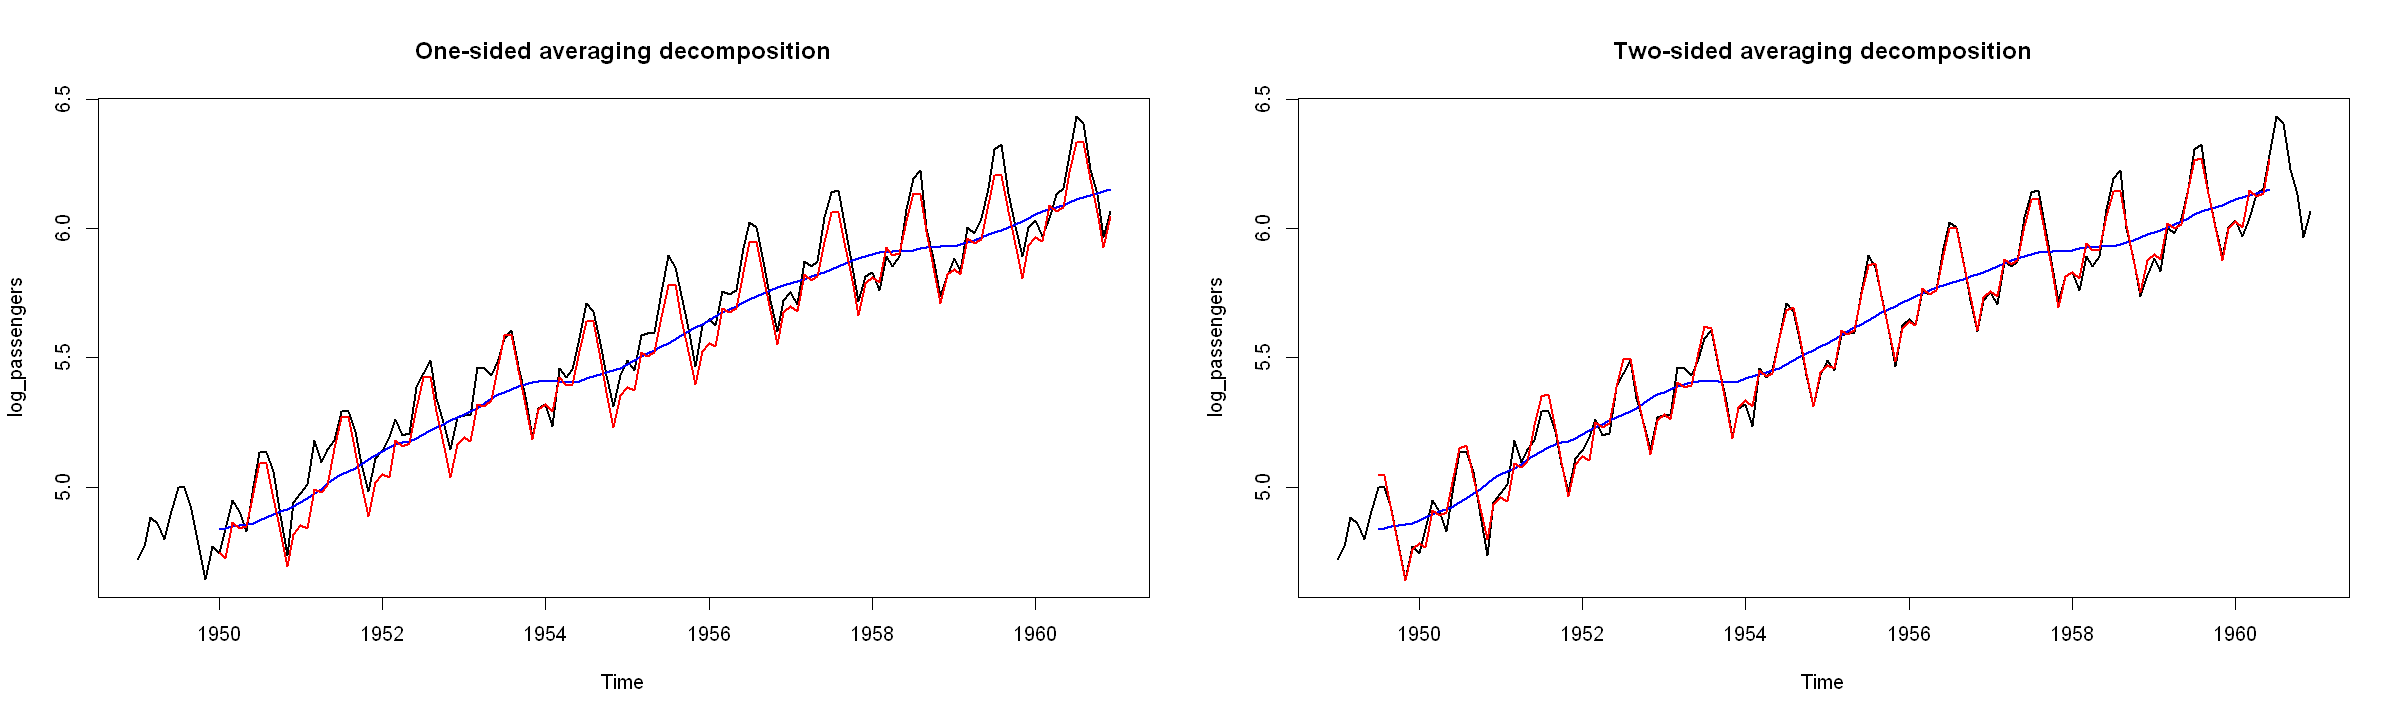

In [17]:
par(mfrow = c(1, 2))
#
plot(log_passengers, lwd = 2, main = "One-sided averaging decomposition")
lines(one_sided_trd, col = "blue", lwd = 2)
lines(one_sided_trd + one_sided_season, col = "red", lwd = 2)
#
plot(log_passengers, lwd = 2, main = "Two-sided averaging decomposition")
lines(two_sided_trd, col = "blue", lwd = 2)
lines(two_sided_trd + two_sided_season, col = "red", lwd = 2)

We can also use the `decompose(...)` function to do all of this:

In [18]:
two_sided_decomp <- decompose(log_passengers, type = "additive")

Compared with the `filter()` function:

In [19]:
two_sided_trd - two_sided_decomp$trend

     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
1949  NA  NA  NA  NA  NA  NA   0   0   0   0   0   0
1950   0   0   0   0   0   0   0   0   0   0   0   0
1951   0   0   0   0   0   0   0   0   0   0   0   0
1952   0   0   0   0   0   0   0   0   0   0   0   0
1953   0   0   0   0   0   0   0   0   0   0   0   0
1954   0   0   0   0   0   0   0   0   0   0   0   0
1955   0   0   0   0   0   0   0   0   0   0   0   0
1956   0   0   0   0   0   0   0   0   0   0   0   0
1957   0   0   0   0   0   0   0   0   0   0   0   0
1958   0   0   0   0   0   0   0   0   0   0   0   0
1959   0   0   0   0   0   0   0   0   0   0   0   0
1960   0   0   0   0   0   0  NA  NA  NA  NA  NA  NA

The results are the same. The upside is we automatically get the seasonal decomposition as well, which are the same as our manually calculated ones:

In [20]:
two_sided_season - two_sided_decomp$seasonal

     Jan Feb Mar Apr May Jun Jul Aug Sep Oct Nov Dec
1949   0   0   0   0   0   0   0   0   0   0   0   0
1950   0   0   0   0   0   0   0   0   0   0   0   0
1951   0   0   0   0   0   0   0   0   0   0   0   0
1952   0   0   0   0   0   0   0   0   0   0   0   0
1953   0   0   0   0   0   0   0   0   0   0   0   0
1954   0   0   0   0   0   0   0   0   0   0   0   0
1955   0   0   0   0   0   0   0   0   0   0   0   0
1956   0   0   0   0   0   0   0   0   0   0   0   0
1957   0   0   0   0   0   0   0   0   0   0   0   0
1958   0   0   0   0   0   0   0   0   0   0   0   0
1959   0   0   0   0   0   0   0   0   0   0   0   0
1960   0   0   0   0   0   0   0   0   0   0   0   0

We can also plot the series:

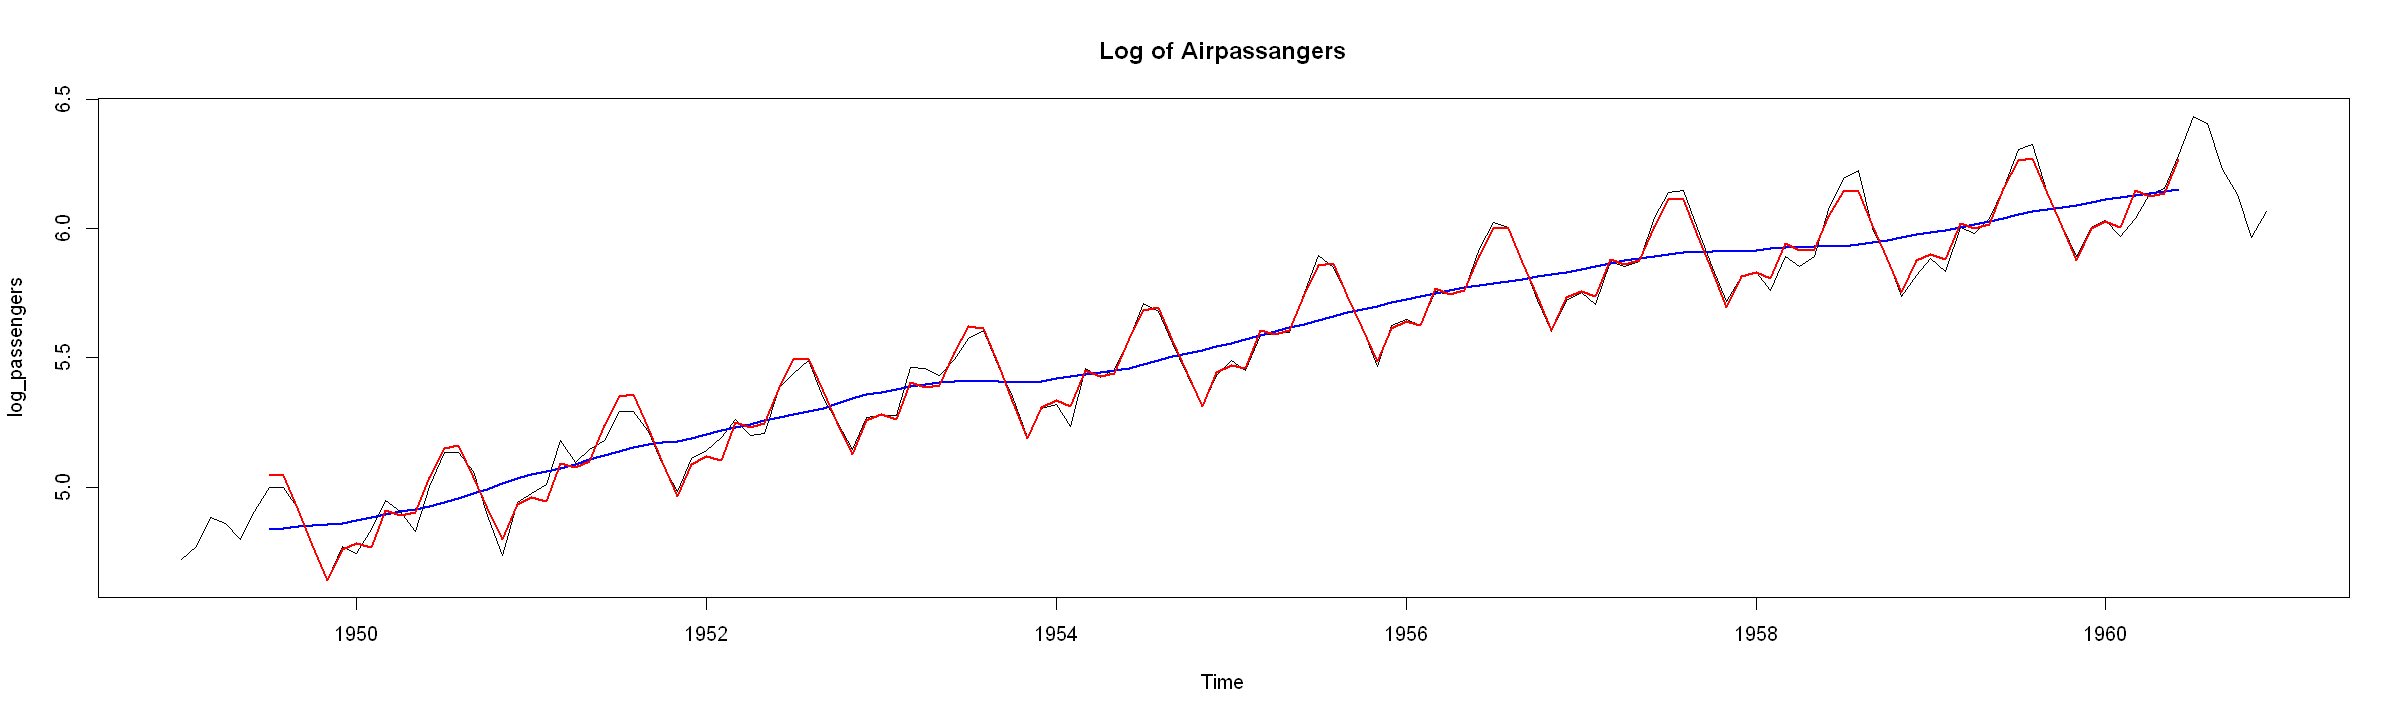

In [21]:
plot.ts(log_passengers, main = "Log of Airpassangers")
lines(two_sided_decomp$trend, col = "blue", lwd = 2)
lines(two_sided_decomp$trend + two_sided_decomp$seasonal, col = "red", lwd = 2)

and examine the residuals:

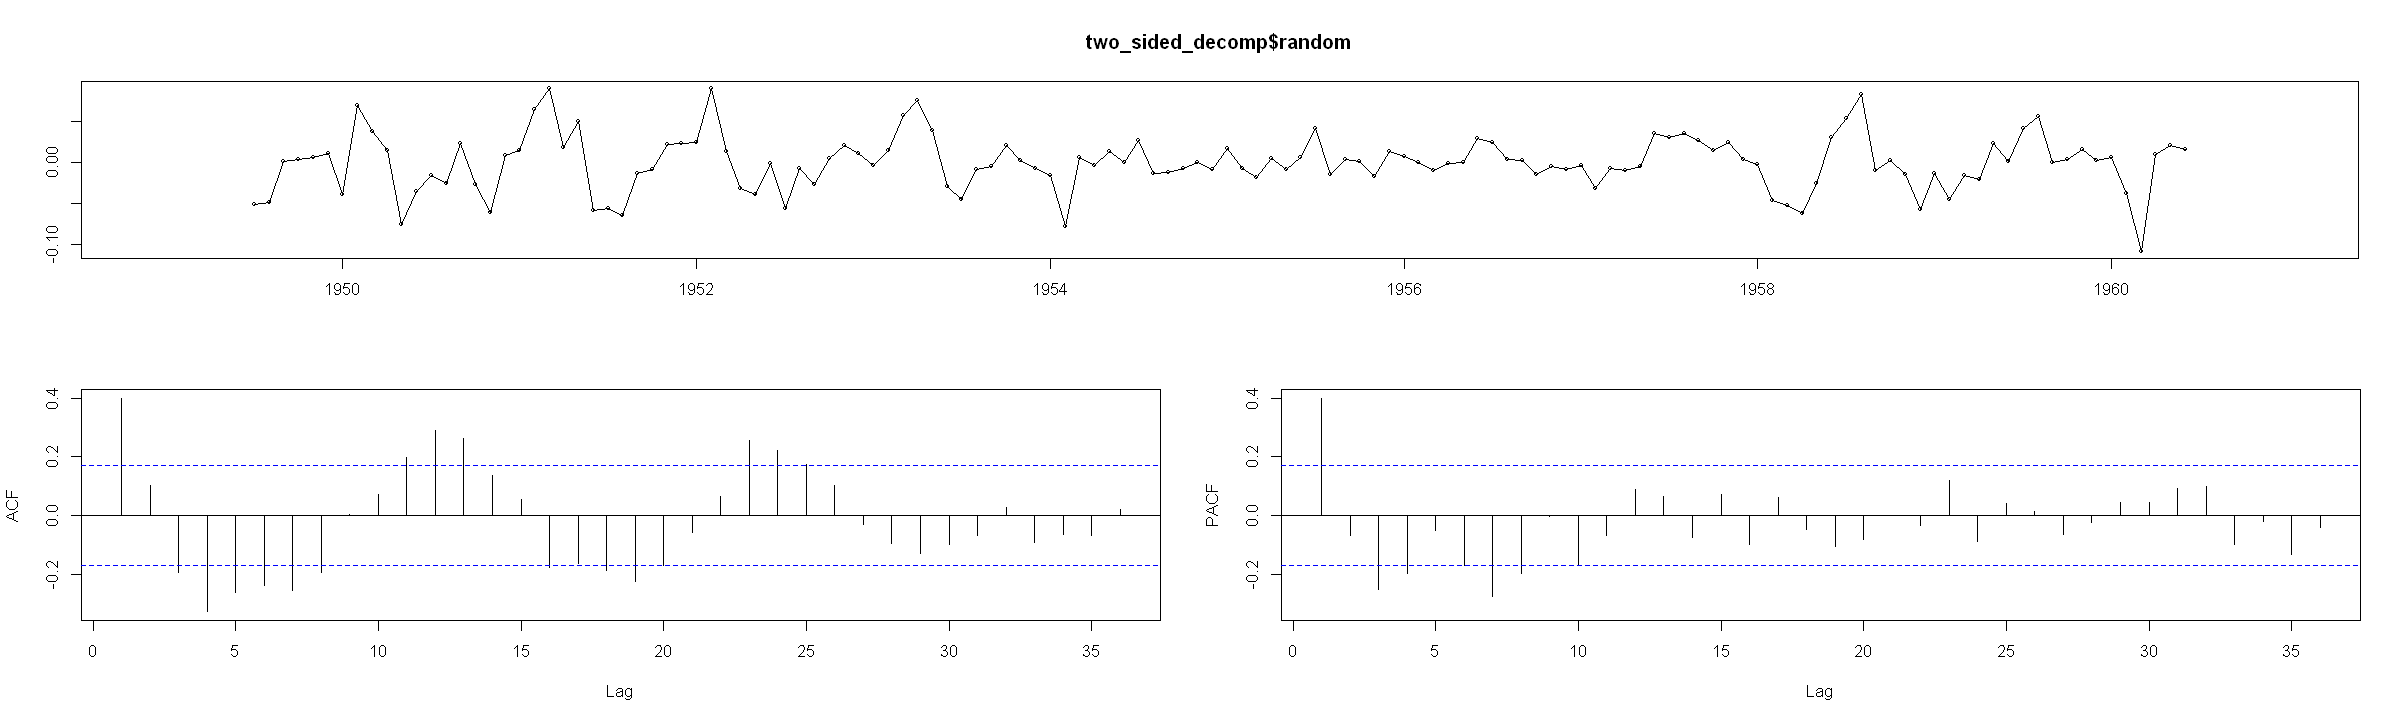

In [22]:
forecast::tsdisplay(two_sided_decomp$random)

Looking at the $\rm ACF$, the residuals still appear to have some searonality.

---

## Exponential Smoothing examples

### Simple exponential smoothing:

In [23]:
s_es <- forecast::ses(log_passengers)

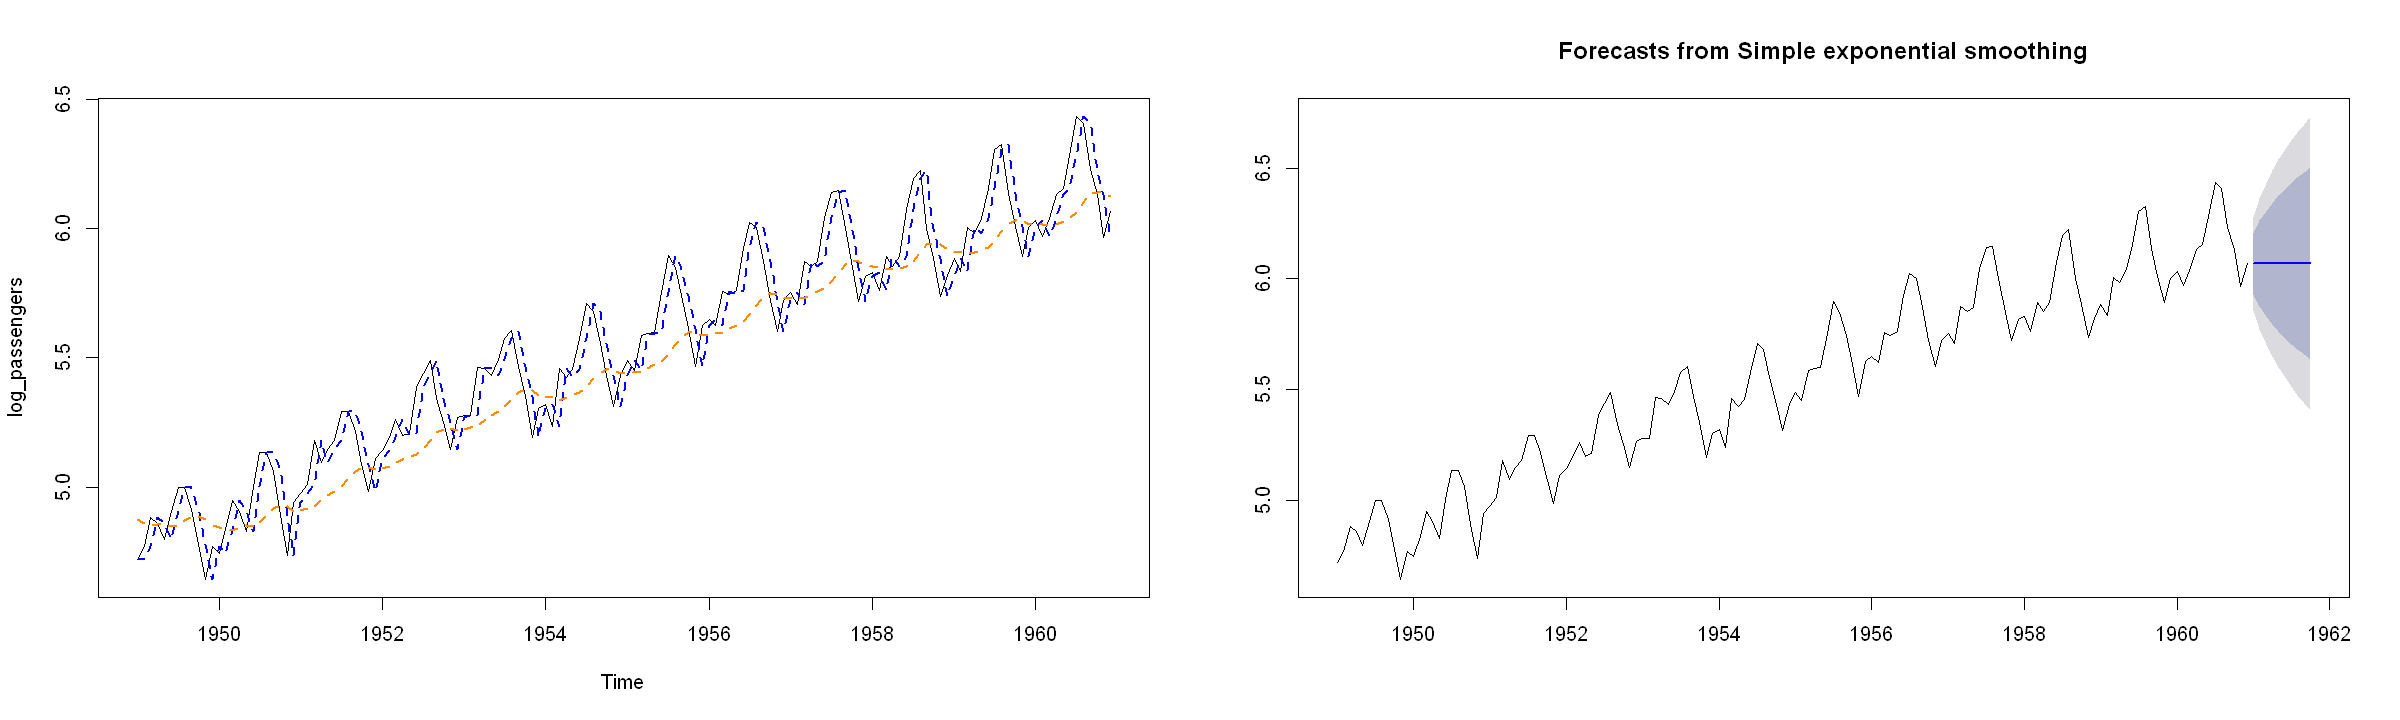

In [24]:
par(mfrow = c(1, 2))
#
plot.ts(log_passengers)#, main = "Simple Exponential smoothing")
lines(fitted.values(s_es), col = "blue", lty = 2, lwd = 2)
lines(fitted.values(forecast::ses(log_passengers, alpha = 0.1)), col = "darkorange", lty = 2, lwd = 2)
#
plot(forecast::forecast(s_es, h = 10))

### Double Exponential Smoothing (Holt's Linear Method)

In [25]:
d_es <- forecast::holt(log_passengers)

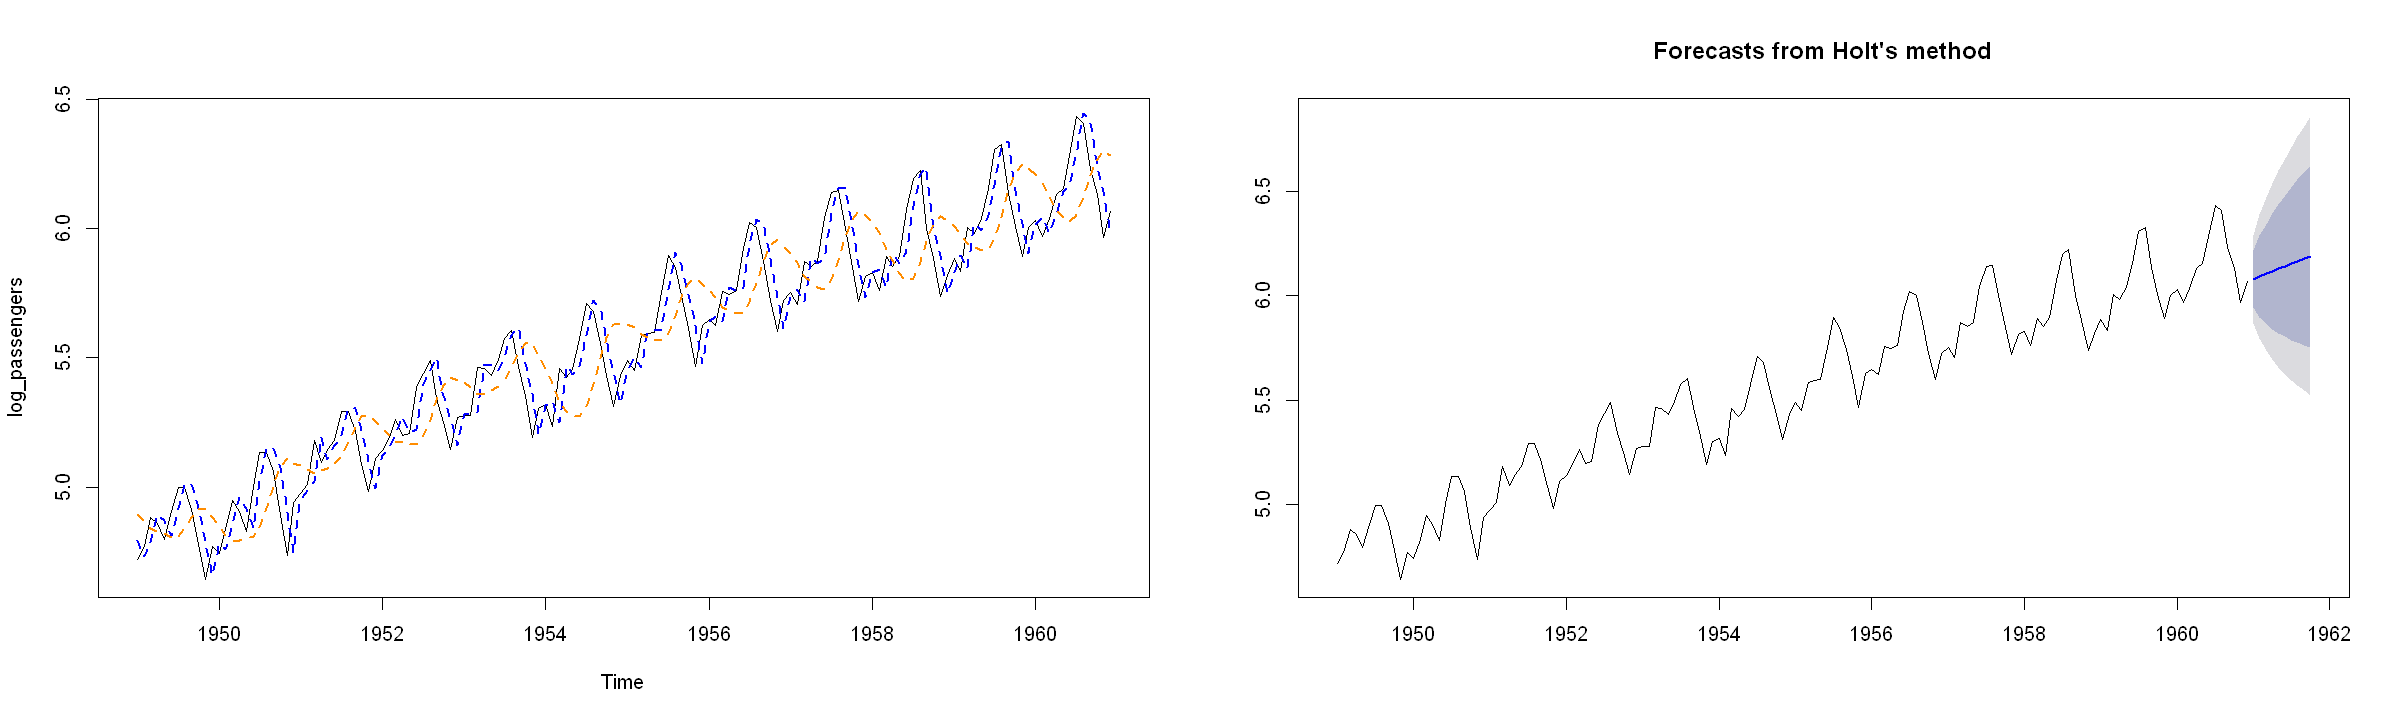

In [26]:
par(mfrow = c(1, 2))
#
plot.ts(log_passengers)#, main = "Double Exponential smoothing")
lines(fitted.values(d_es), col = "blue", lty = 2, lwd = 2)
lines(fitted.values(forecast::holt(log_passengers, alpha = 0.1, beta = 0.09)), col = "darkorange", lty = 2, lwd = 2)
#
plot(forecast::forecast(d_es, h = 10))

### Triple Exponential Smoothing (Holt-Winter's Method)

In [27]:
t_es <- forecast::hw(log_passengers)

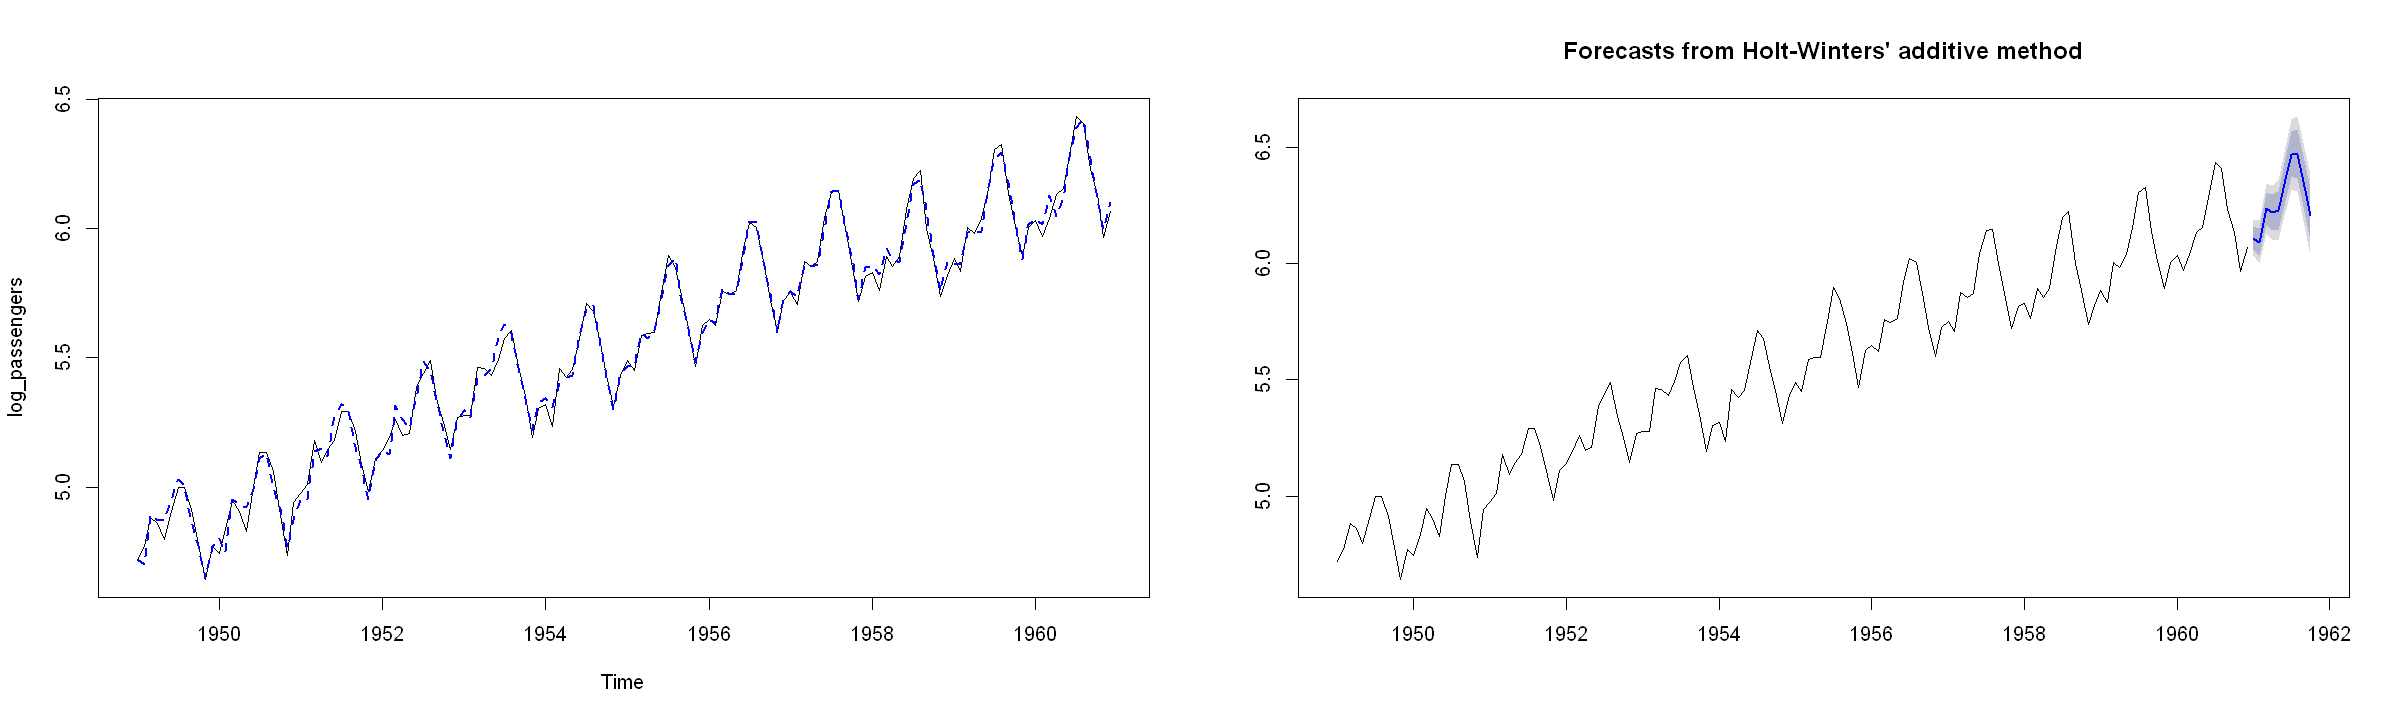

In [28]:
par(mfrow = c(1, 2))
#
plot.ts(log_passengers)#, main = "Triple Exponential smoothing")
lines(fitted.values(t_es), col = "blue", lty = 2, lwd = 2)
#
plot(forecast::forecast(t_es, h = 10))

`R` allows to use an automated procedure to choose the smoothing parameters - the function `ets` selects the best variant automatically (by the minimum of AIC) and estimates its parameters:

In [29]:
ets_es <- forecast::ets(log_passengers)

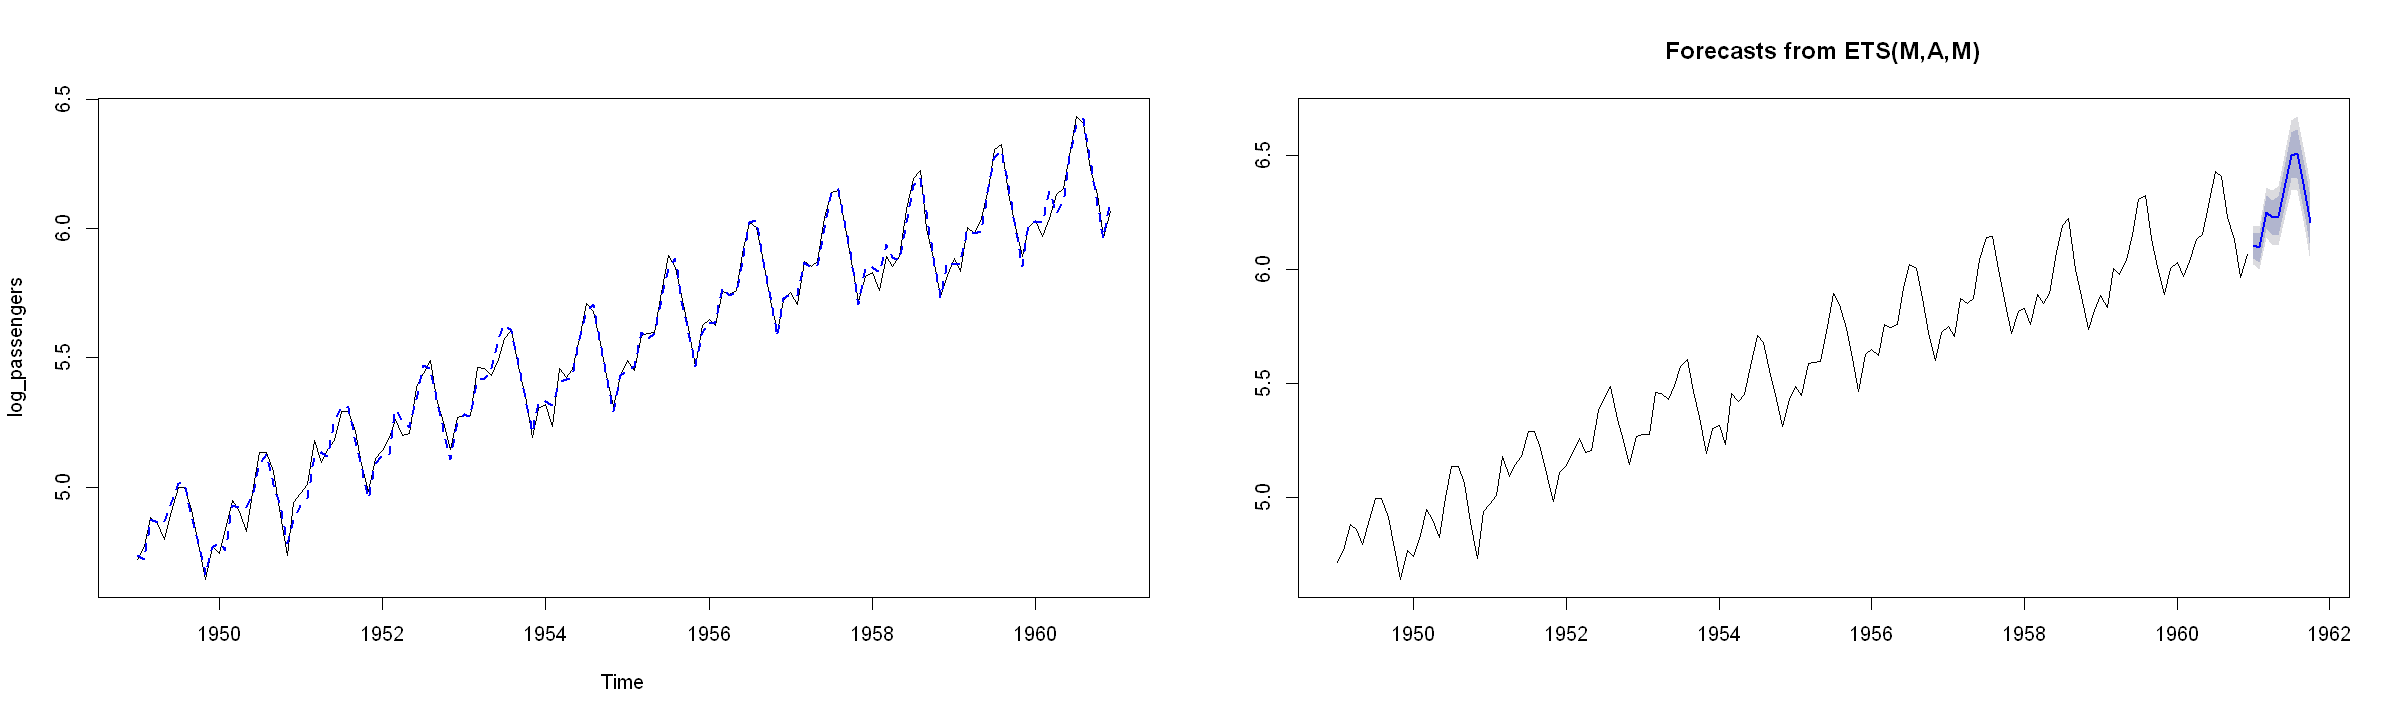

In [30]:
par(mfrow = c(1, 2))
#
plot.ts(log_passengers)
lines(fitted.values(ets_es), col = "blue", lty = 2, lwd = 2)
#
plot(forecast::forecast(ets_es, h = 10))

Note the help file:

- The first letter denotes the error type ("A", "M" or "Z"); 
- The second letter denotes the trend type ("N","A","M" or "Z"); 
- The third letter denotes the season type ("N","A","M" or "Z"). 

In all cases, "N"=none, "A"=additive, "M"=multiplicative and "Z"=automatically selected. So, for example, "ANN" is simple exponential smoothing with additive errors, "MAM" is multiplicative Holt-Winters' method with multiplicative errors, and so on.

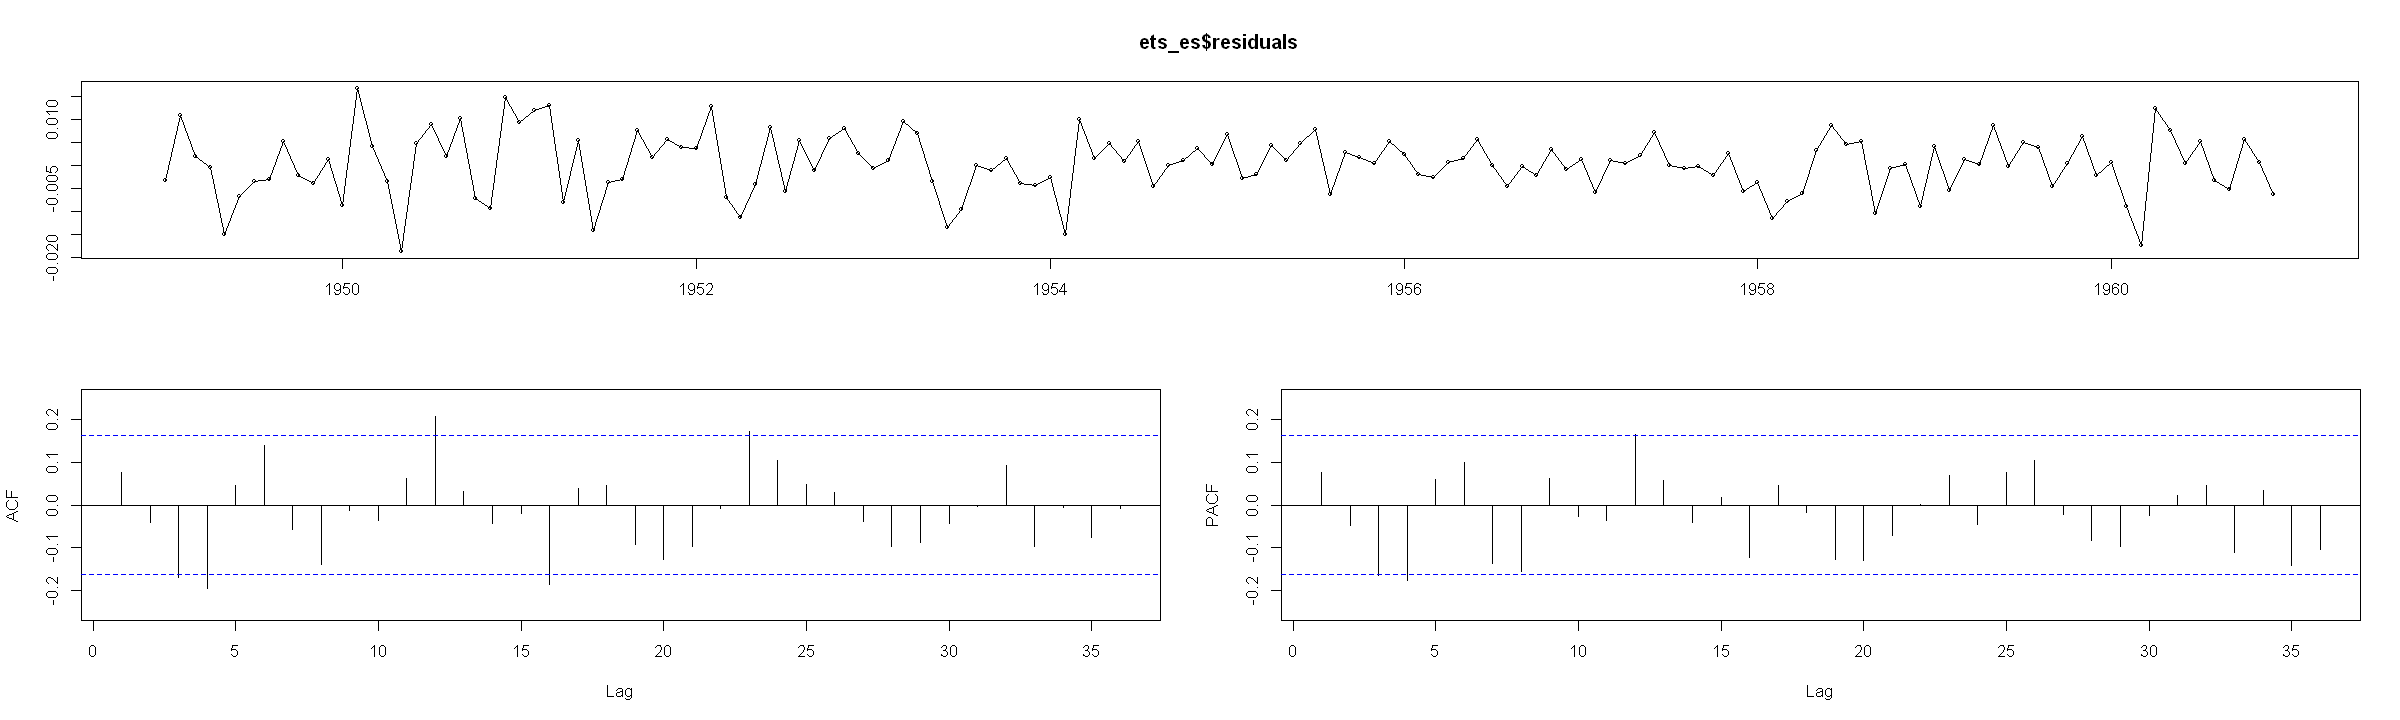

In [31]:
forecast::tsdisplay(ets_es$residuals)

The residuals ppear to have a *slight* autocorrelation

## SARMA models with trend

In [32]:
tt_dt <- data.frame(tt = 1:length(log_passengers))
tt_dt$tt_sq <- tt_dt$tt^2
#
mdl_auto = forecast::auto.arima(airpass, max.d = 0, max.D = 0, xreg = tt_dt)

In [33]:
mdl_auto

Series: airpass 
Regression with ARIMA(0,0,3)(0,0,1)[12] errors 

Coefficients:
         ma1     ma2     ma3    sma1  intercept      tt   tt_sq
      0.9875  0.7195  0.3621  0.7592   117.1154  1.5895  0.0068
s.e.  0.0822  0.1077  0.0914  0.0668    20.7197  0.6575  0.0044

sigma^2 estimated as 359.3:  log likelihood=-630.18
AIC=1276.35   AICc=1277.42   BIC=1300.11

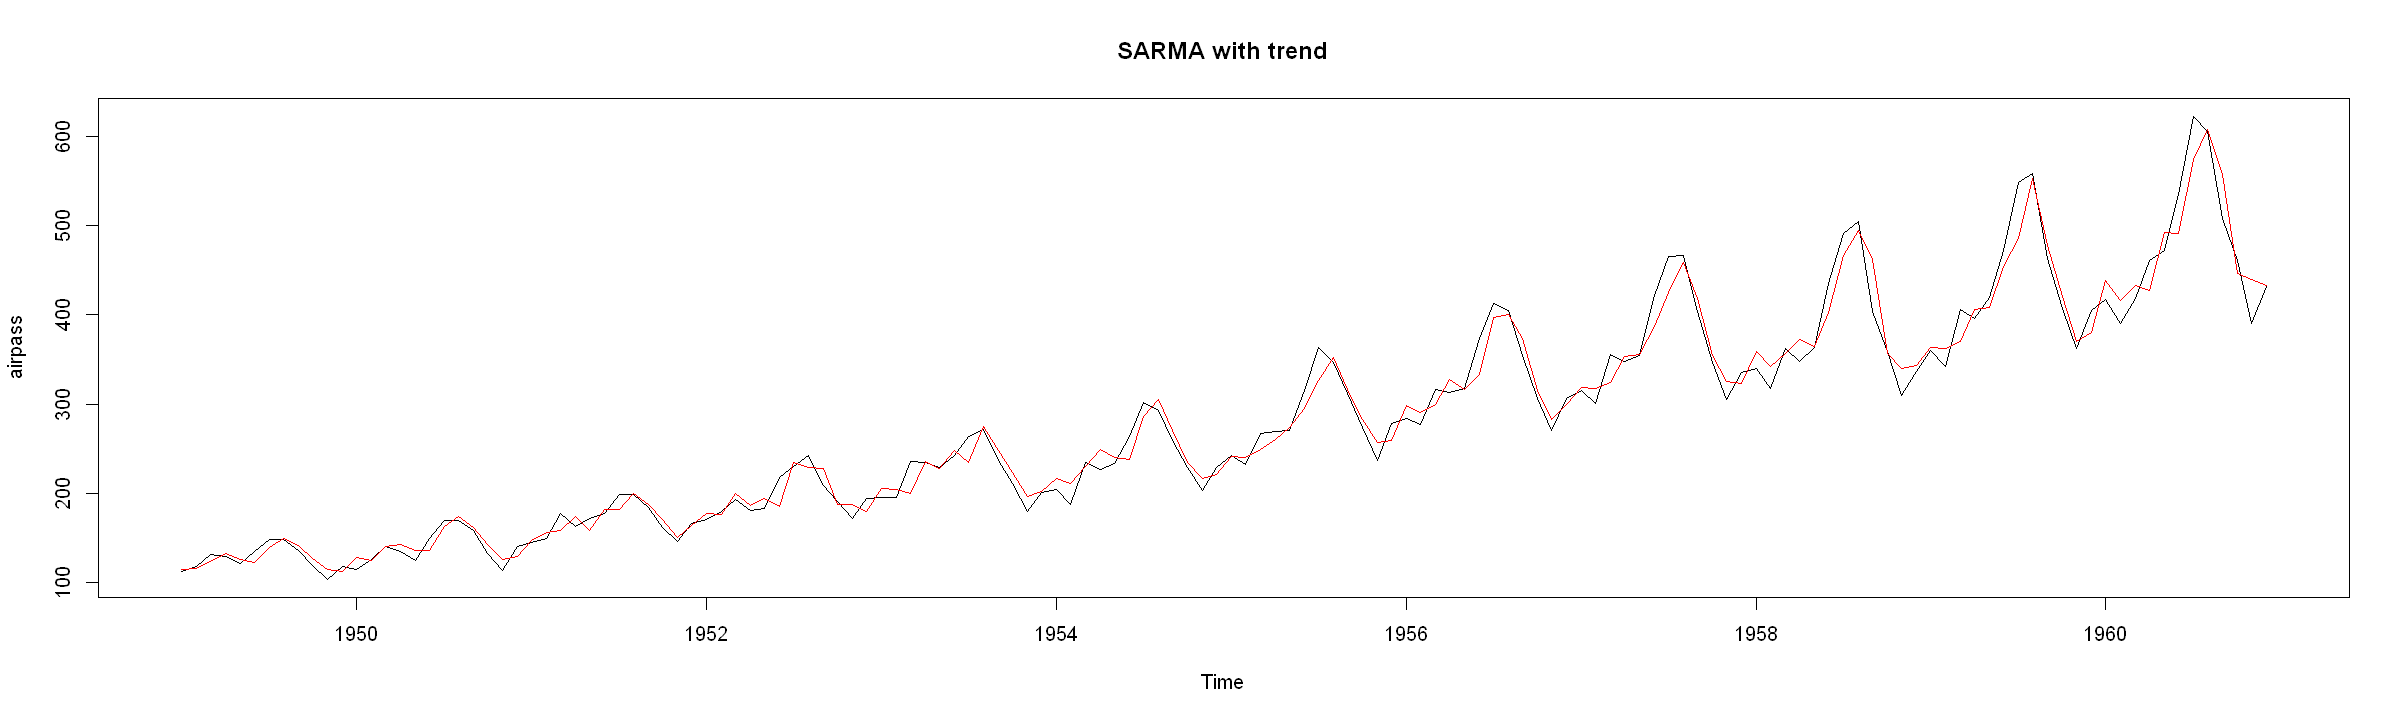

In [34]:
plot(airpass, main = "SARMA with trend")
lines(mdl_auto$fitted, col = "red")

We can examine the residuals

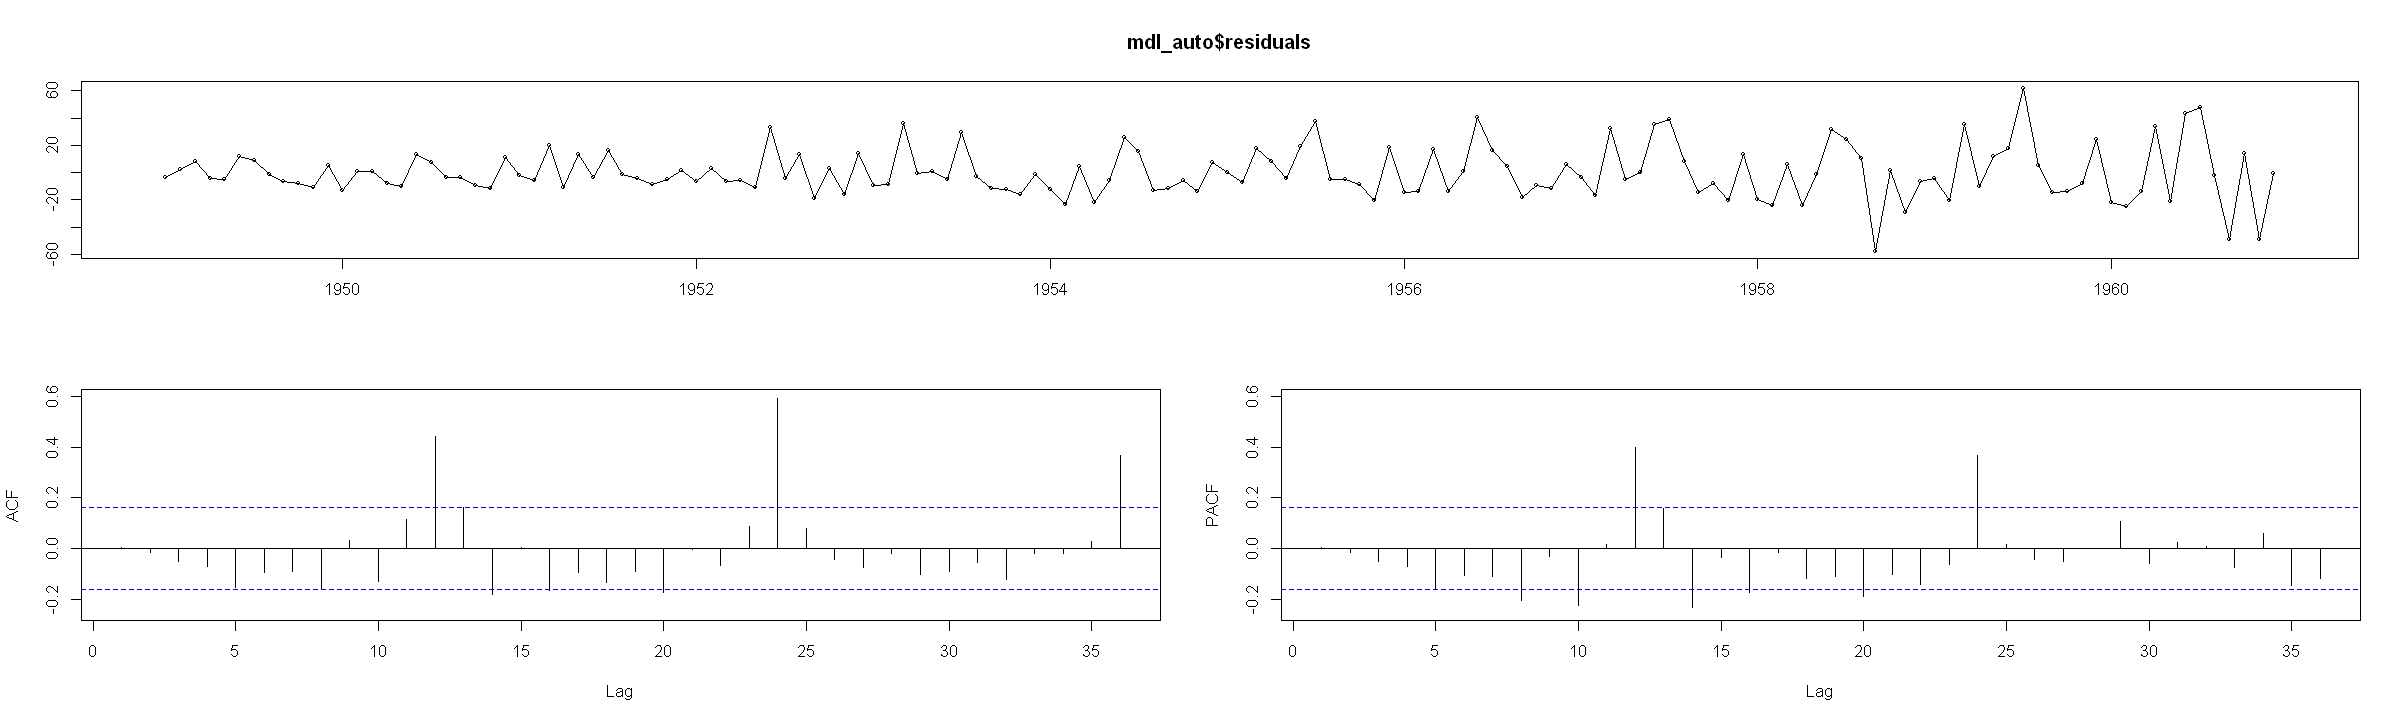

In [35]:
forecast::tsdisplay(mdl_auto$residuals)

Note that there appears to be a large autocorrelation for every `12`-th lag. So the restriction of no differencing causes `auto.arima` to fail to find a suitible model.

For somparison, if we were to specify a $SARIMA(1, 0, 1)\times(1, 0, 1)_{12}$. If we use the default specification, we may get a warning that the series is not stationary:

In [36]:
tryCatch({
    forecast::Arima(airpass, order = c(1, 0, 1), seasonal = c(1, 0, 1), xreg = tt_dt)
}, warning = function(w) {
   # warning-handler-code
}, error = function(e) {
    print(e)
}, finally = {
    # cleanup-code
})

<simpleError in stats::arima(x = x, order = order, seasonal = seasonal, xreg = xreg,     include.mean = include.mean, method = method, ...): non-stationary seasonal AR part from CSS>


If we are sure that the process is stationary, we can specify a different parameter estimation method:

In [37]:
mdl_manual = forecast::Arima(airpass, order = c(1, 0, 1), seasonal = c(1, 0, 1), xreg = tt_dt, method = "ML")

In [38]:
mdl_manual

Series: airpass 
Regression with ARIMA(1,0,1)(1,0,1)[12] errors 

Coefficients:
         ar1      ma1    sar1     sma1  intercept      tt   tt_sq
      0.7540  -0.1003  0.9630  -0.1336   119.0055  1.4857  0.0077
s.e.  0.0724   0.1045  0.0161   0.0925    38.2025  0.5299  0.0033

sigma^2 estimated as 128:  log likelihood=-564.67
AIC=1145.35   AICc=1146.41   BIC=1169.11

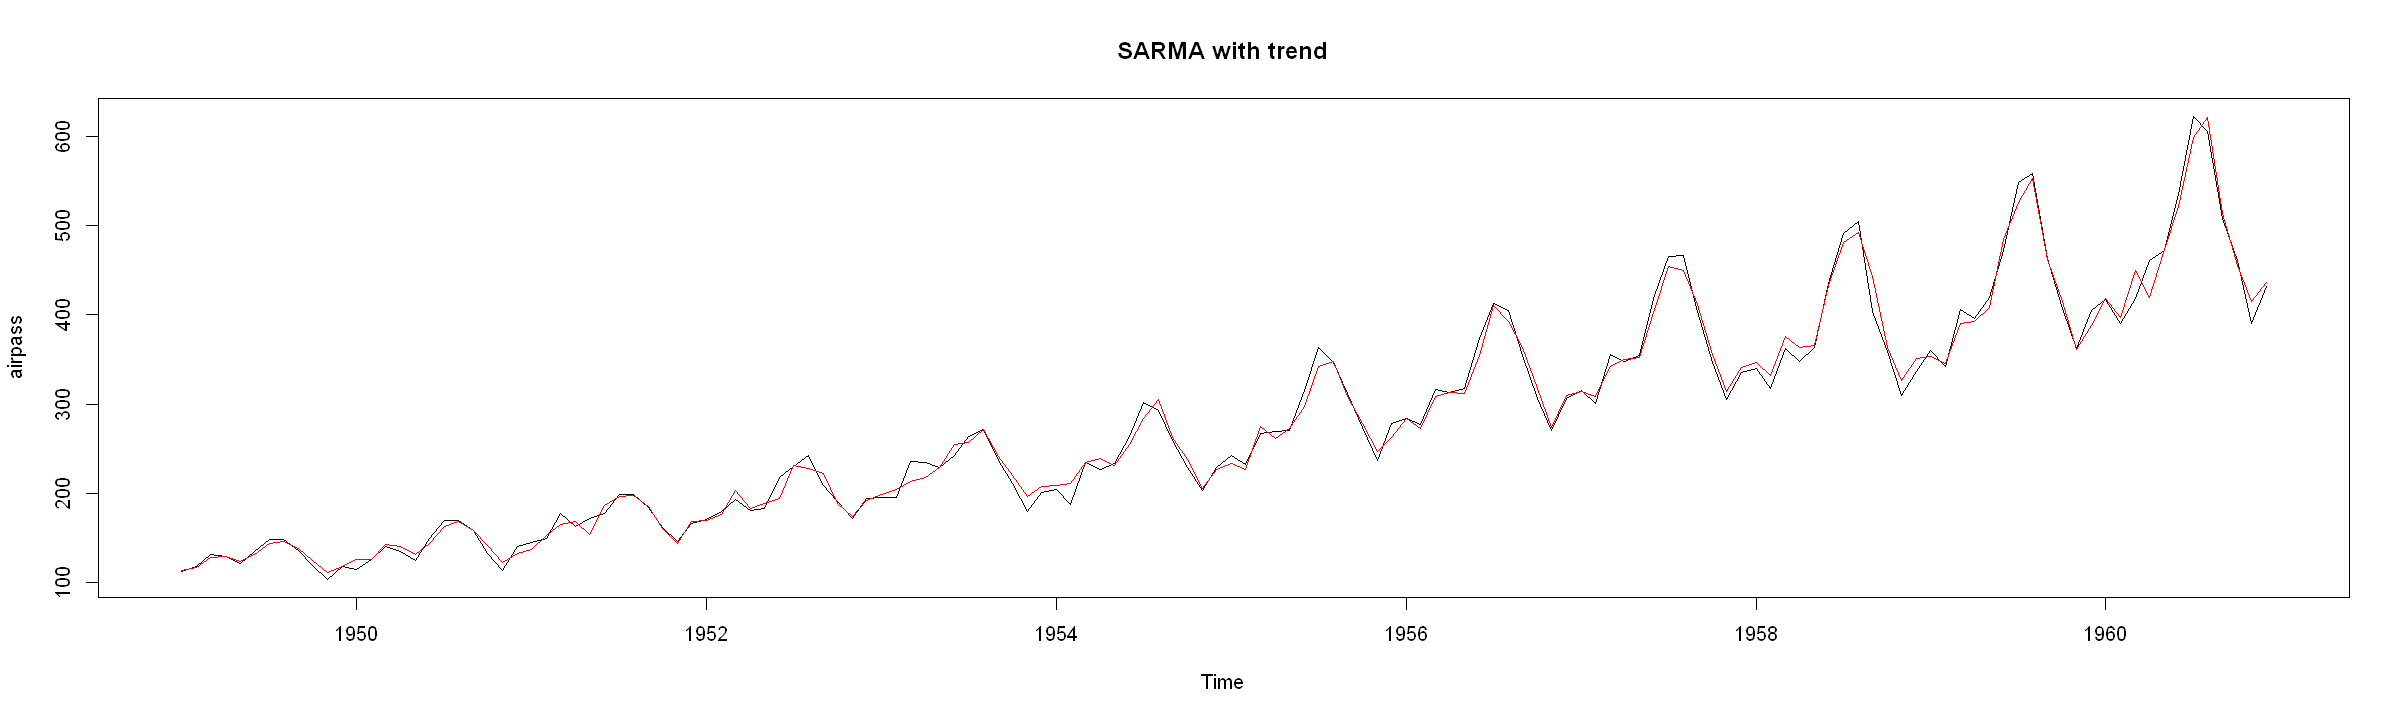

In [39]:
plot(airpass, main = "SARMA with trend")
lines(mdl_manual$fitted, col = "red")

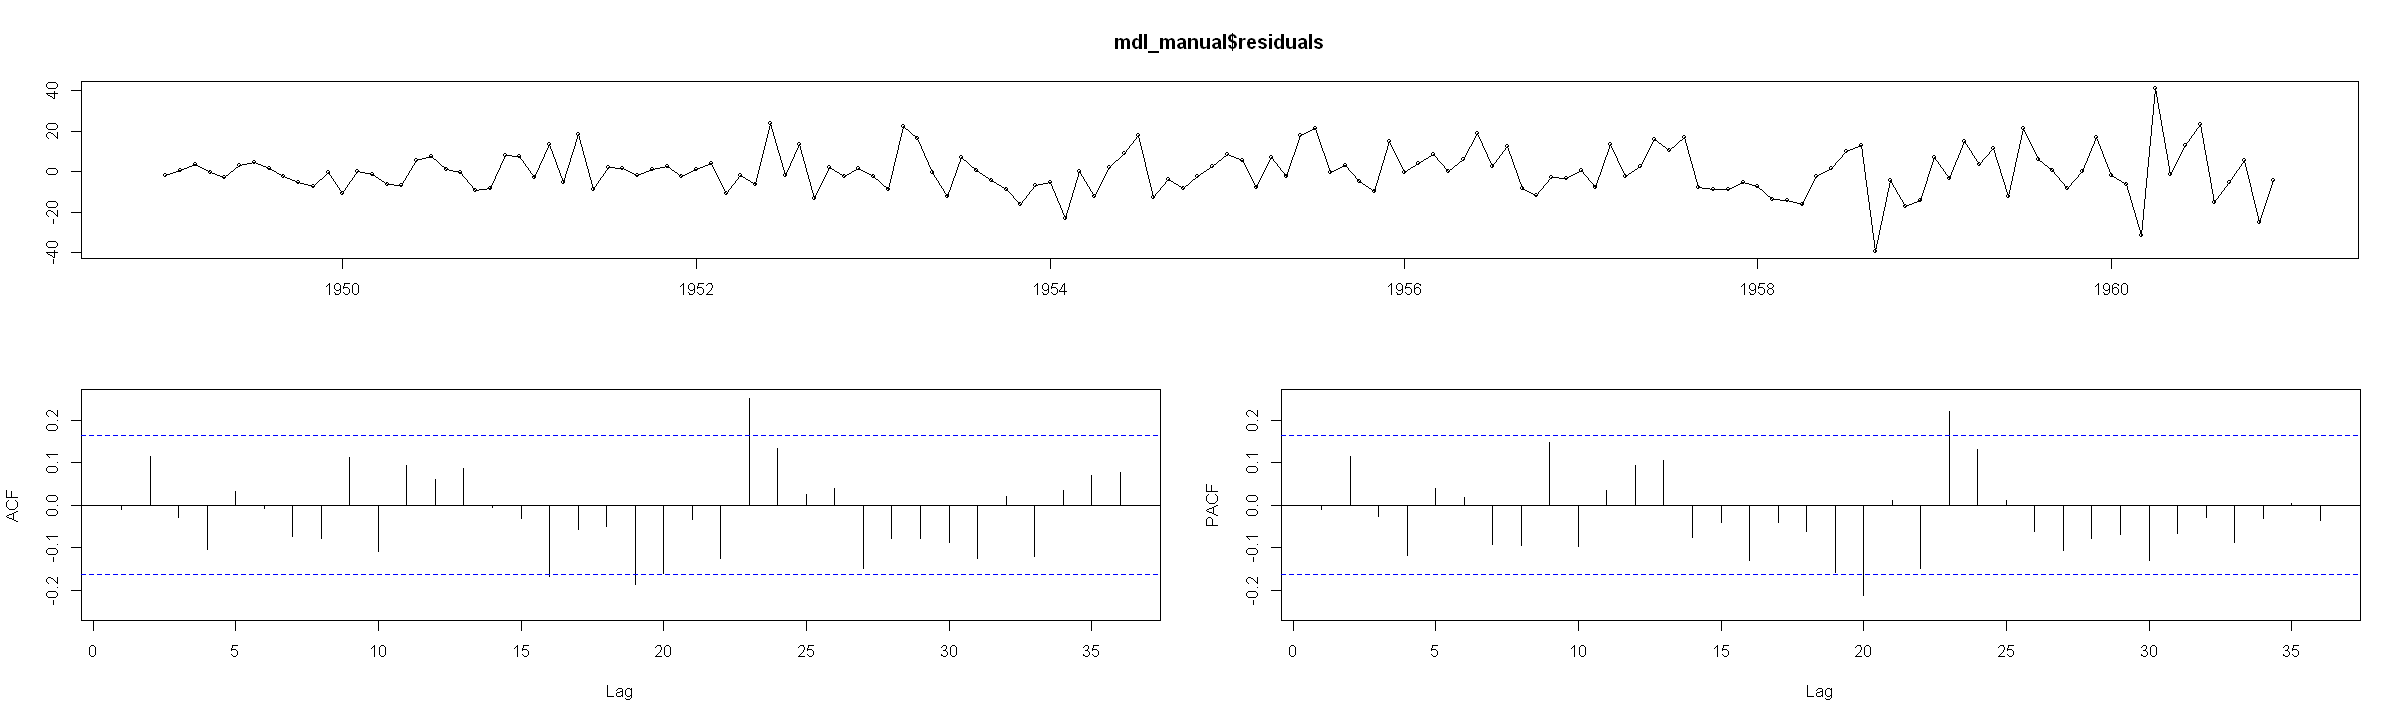

In [40]:
forecast::tsdisplay(mdl_manual$residuals)

The residuals look much better compared to the `auto.arima` results with restriction that the data is not to be differenced.

Finally, we can forecast the process. we do need to have the soem future values of the trend. Thankfully, we have opted to use the standard indexing of $t = 1,2,...$ for the trend.

In [41]:
tt_forc <- data.frame(tt = tail(tt_dt$tt, 1) + 1:20)
tt_forc$tt_sq <- tt_forc$tt^2

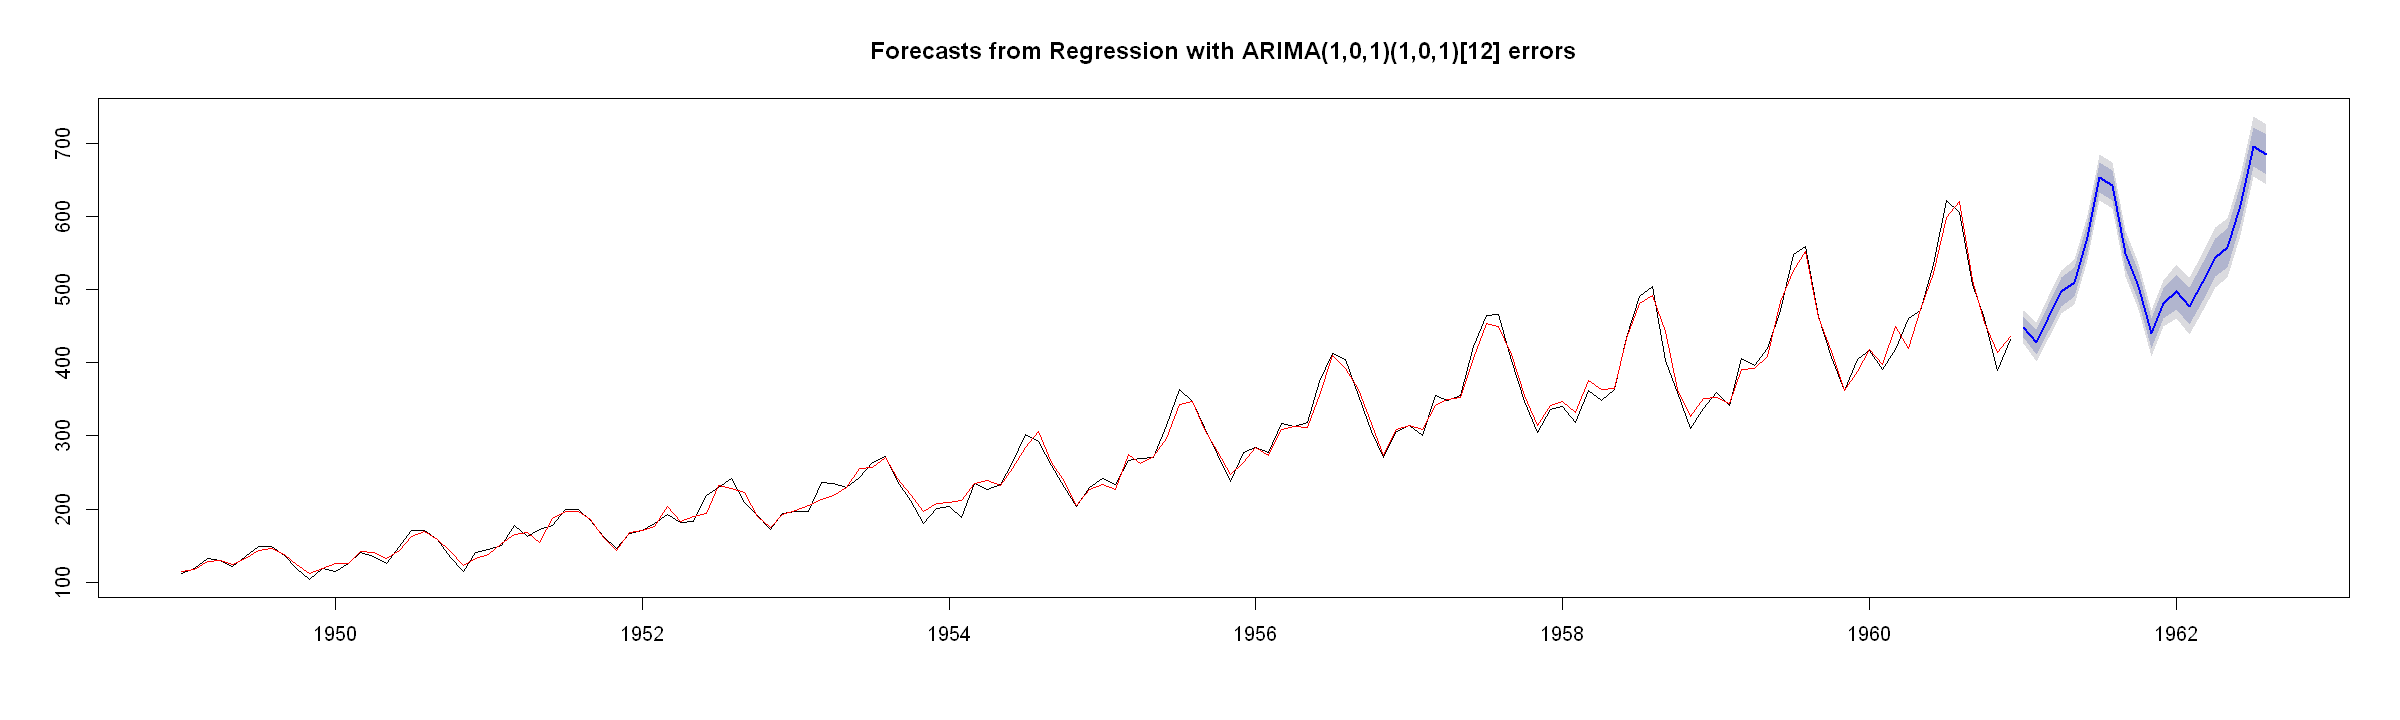

In [42]:
plot(forecast::forecast(mdl_manual, xreg = tt_forc))
lines(mdl_manual$fitted, col = "red")

----
----
----

# Time series with unit root

In [43]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 15)
options(repr.plot.height = 4)

# (1) Series plot and transformation

In [44]:
suppressPackageStartupMessages({library(forecast)})

In [45]:
nyse <- read.table(url("http://uosis.mif.vu.lt/~rlapinskas/(data%20R&GRETL/nyse.txt"), header = TRUE)
nyse <- ts(nyse, start = 1952, frequency = 12)

In [46]:
head(nyse, 36)

           Jan       Feb       Mar       Apr       May       Jun       Jul
1952 100.00000 101.55801  98.35478 102.49584  97.45797  99.92923 103.53153
1953 107.99719 107.70146 106.74088 104.92693 101.94905 101.89004  99.83214
1954 102.88020 108.08621 109.38209 113.14183 117.91136 120.87454 121.79292
           Aug       Sep       Oct       Nov       Dec
1952 104.61471 103.15134 100.79363 100.10055 105.16128
1953 102.22141  97.10542  96.98586 101.49628 103.35702
1954 127.93562 124.25727 132.08256 129.77409 141.50459

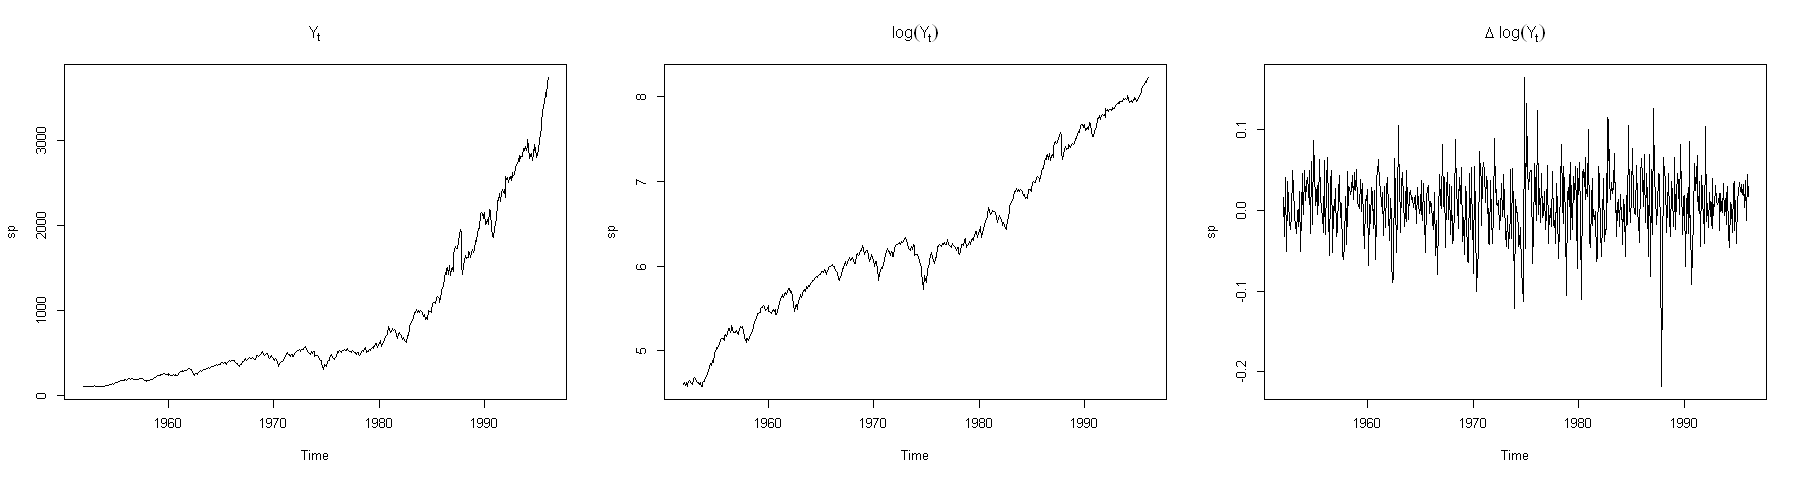

In [47]:
par(mfrow = c(1, 3))
plot(nyse, main = bquote(Y[t])) 
plot(log(nyse), main = bquote(log(Y[t])))
plot(diff(log(nyse)), main = bquote(Delta~log(Y[t])))

Note that the growth appears to be exponential - it is more convenient to take logarithms to *linearize* the series.

In [48]:
lnyse <- log(nyse)

# (2) $\rm ACF$ and $\rm PACF$ plots

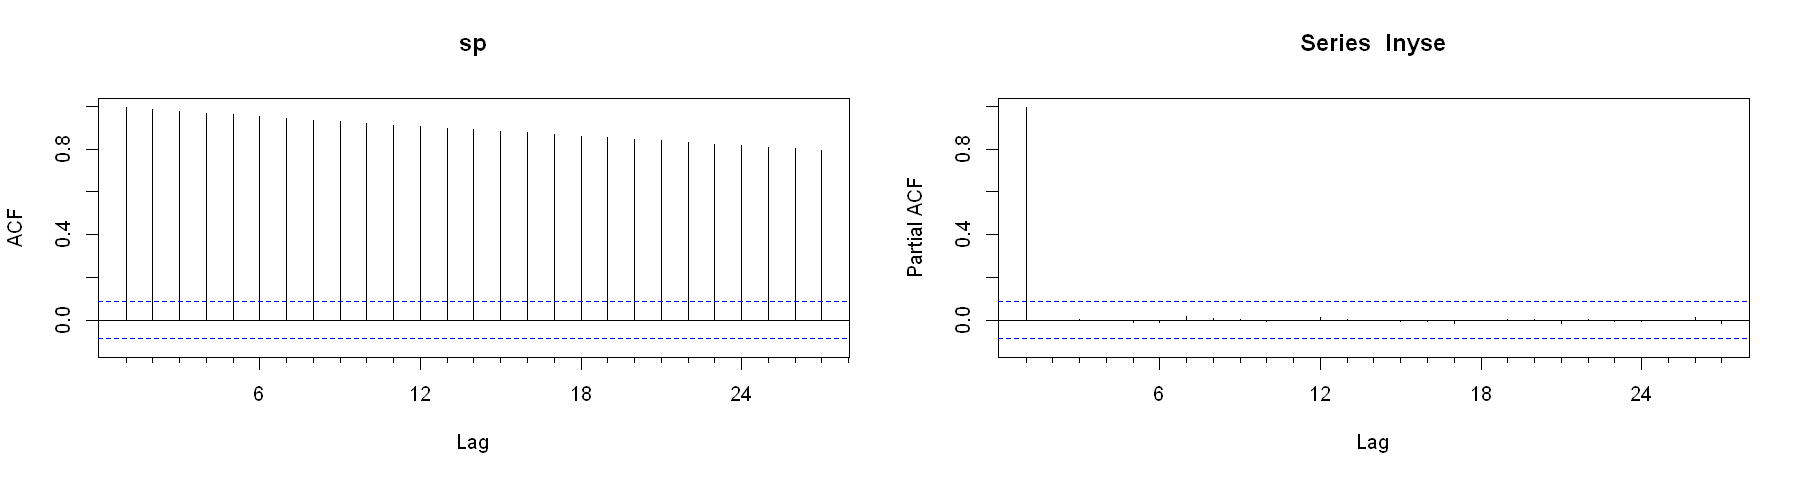

In [49]:
par(mfrow = c(1, 2))
forecast::Acf(lnyse, )
forecast::Pacf(lnyse)

Slow ACF decay - indication of non-stationarity, or a trend, or a nonstationarity and/or drift and/or trend. **We need to test whether the data is TS or DS. To do this - we need to carry out unit root testing**.

We can always load the relevant libraries to avoid the use of `::` notation.

---

# (3) Unit root testing

In [50]:
library(forecast)
library(dynlm)
library(urca)

Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



## (3.1) Manual Unit root testing


Unit root tests consist of:

- Selecting the lag order of the autoregressive model $\Delta Y_t = \alpha + \delta t + \rho Y_{t-1} + \sum_{j = 1}^p \gamma_j \Delta Y_{t-1} + \epsilon_t$
- Determine whether the trend coefficient, $\widehat{\delta}$, is significant;
- Dependin on the final model, asses whether $\widehat{\rho}$ is significant.


### Lag Order selection

We will examine three cases:

- Starting with $p_\max = 4$;
- Starting with $p_\max = 5$;
- Starting with $p_\max = \biggr\lfloor 12 \cdot \left( \dfrac{T}{100} \right)^{1/4} \biggr\rfloor$;

#### **Starting with $p_\max = 4$**

In [51]:
mod.1 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:4) + time(lnyse))
summary(mod.1)


Time series regression with "ts" data:
Start = 1952(6), End = 1995(13)

Call:
dynlm(formula = d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:4) + time(lnyse))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.220902 -0.024758  0.001637  0.026627  0.152618 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)  
(Intercept)       -2.3687707  1.1485800  -2.062   0.0397 *
L(lnyse)          -0.0172567  0.0083590  -2.064   0.0395 *
L(d(lnyse), 1:4)1  0.0544182  0.0439376   1.239   0.2161  
L(d(lnyse), 1:4)2 -0.0282788  0.0439795  -0.643   0.5205  
L(d(lnyse), 1:4)3  0.0150921  0.0439341   0.344   0.7313  
L(d(lnyse), 1:4)4  0.0364522  0.0439285   0.830   0.4070  
time(lnyse)        0.0012584  0.0006077   2.071   0.0389 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04061 on 517 degrees of freedom
Multiple R-squared:  0.01244,	Adjusted R-squared:  0.0009837 
F-statistic: 1.086 on 6 and 517 DF,  p-value: 0.3696


The last lag coefficient, `L(d(lnyse), 1:4)4` is insignificant since its $p-value = 0.4070 > 0.05`. We will reduce the maximum lag and continue the procedure.

In [52]:
mod.1 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:3) + time(lnyse))
print(round(coef(summary(mod.1)), 4))

                  Estimate Std. Error t value Pr(>|t|)
(Intercept)        -2.2563     1.1441 -1.9721   0.0491
L(lnyse)           -0.0162     0.0083 -1.9420   0.0527
L(d(lnyse), 1:3)1   0.0514     0.0439  1.1689   0.2430
L(d(lnyse), 1:3)2  -0.0274     0.0439 -0.6227   0.5338
L(d(lnyse), 1:3)3   0.0151     0.0439  0.3438   0.7311
time(lnyse)         0.0012     0.0006  1.9789   0.0484


`p-value` of `L(d(lnyse), 1:3)3` is `> 0.05`.

In [53]:
mod.1 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:2) + time(lnyse))
print(round(coef(summary(mod.1)), 4))

                  Estimate Std. Error t value Pr(>|t|)
(Intercept)        -2.2314     1.1372 -1.9621   0.0503
L(lnyse)           -0.0161     0.0083 -1.9483   0.0519
L(d(lnyse), 1:2)1   0.0493     0.0438  1.1244   0.2614
L(d(lnyse), 1:2)2  -0.0263     0.0439 -0.6004   0.5485
time(lnyse)         0.0012     0.0006  1.9698   0.0494


`p-value` of `L(d(lnyse), 1:2)2` is `> 0.05`.

In [54]:
mod.1 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1) + time(lnyse))
print(round(coef(summary(mod.1)), 4))

               Estimate Std. Error t value Pr(>|t|)
(Intercept)     -2.2880     1.1308 -2.0233   0.0435
L(lnyse)        -0.0164     0.0082 -1.9956   0.0465
L(d(lnyse), 1)   0.0480     0.0438  1.0956   0.2737
time(lnyse)      0.0012     0.0006  2.0302   0.0428


`p-value` of `L(d(lnyse), 1)` is `> 0.05`.

In [55]:
mod.1 <- dynlm(d(lnyse) ~ L(lnyse) + time(lnyse))
print(round(coef(summary(mod.1)), 4))

            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -2.1695     1.1246 -1.9292   0.0542
L(lnyse)     -0.0155     0.0082 -1.8995   0.0580
time(lnyse)   0.0012     0.0006  1.9362   0.0534


**The final model contains no lags of $\Delta Y_{t-j}$ - so there is no autoregressive coefficient for the difference model.**

---

#### **Starting with $p_\max = 5$**

We will repeat the procedure as before.

In [56]:
mod.2 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:5) + time(lnyse))
print(round(coef(summary(mod.2)), 4))

                  Estimate Std. Error t value Pr(>|t|)
(Intercept)        -2.6325     1.1505 -2.2882   0.0225
L(lnyse)           -0.0192     0.0084 -2.2920   0.0223
L(d(lnyse), 1:5)1   0.0540     0.0439  1.2319   0.2185
L(d(lnyse), 1:5)2  -0.0286     0.0439 -0.6523   0.5145
L(d(lnyse), 1:5)3   0.0208     0.0439  0.4738   0.6359
L(d(lnyse), 1:5)4   0.0329     0.0438  0.7516   0.4527
L(d(lnyse), 1:5)5   0.1030     0.0438  2.3508   0.0191
time(lnyse)         0.0014     0.0006  2.2962   0.0221


`L(d(lnyse), 1:5)5` has `p-value < 0.05`, so the final lag order is `5`.

---

#### **Starting with $p_\max = \biggr\lfloor 12 \cdot \left( \dfrac{T}{100} \right)^{1/4} \biggr\rfloor$**

The maximum lag via the rule-of-thumb is:

In [57]:
floor(12 * (length(lnyse) / 100)^(1/4))

[1] 18

In [58]:
mod.3 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:18) + time(lnyse))
print(round(coef(summary(mod.3)), 4))

                    Estimate Std. Error t value Pr(>|t|)
(Intercept)          -2.0342     1.2305 -1.6532   0.0989
L(lnyse)             -0.0152     0.0091 -1.6706   0.0954
L(d(lnyse), 1:18)1    0.0509     0.0453  1.1234   0.2618
L(d(lnyse), 1:18)2   -0.0321     0.0454 -0.7058   0.4806
L(d(lnyse), 1:18)3    0.0307     0.0453  0.6776   0.4984
L(d(lnyse), 1:18)4    0.0279     0.0454  0.6162   0.5381
L(d(lnyse), 1:18)5    0.1048     0.0451  2.3241   0.0205
L(d(lnyse), 1:18)6   -0.0660     0.0453 -1.4561   0.1460
L(d(lnyse), 1:18)7   -0.0292     0.0454 -0.6423   0.5210
L(d(lnyse), 1:18)8   -0.0719     0.0454 -1.5853   0.1135
L(d(lnyse), 1:18)9    0.0048     0.0455  0.1060   0.9156
L(d(lnyse), 1:18)10  -0.0205     0.0455 -0.4518   0.6516
L(d(lnyse), 1:18)11   0.0159     0.0453  0.3505   0.7261
L(d(lnyse), 1:18)12   0.0322     0.0453  0.7105   0.4777
L(d(lnyse), 1:18)13   0.0164     0.0451  0.3640   0.7160
L(d(lnyse), 1:18)14  -0.1022     0.0450 -2.2723   0.0235
L(d(lnyse), 1:18)15   0.0043   

`L(d(lnyse), 1:18)18` is insignificant. We will continue reducing the lag order untill the last lag is significant. We omit the intermediate model output with insignificant $p_\max$ coefficients. The final model

In [59]:
mod.3 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:14) + time(lnyse))
print(round(coef(summary(mod.3)), 4))

                    Estimate Std. Error t value Pr(>|t|)
(Intercept)          -2.0920     1.2078 -1.7320   0.0839
L(lnyse)             -0.0151     0.0089 -1.7043   0.0890
L(d(lnyse), 1:14)1    0.0510     0.0448  1.1383   0.2555
L(d(lnyse), 1:14)2   -0.0233     0.0449 -0.5198   0.6034
L(d(lnyse), 1:14)3    0.0283     0.0449  0.6307   0.5285
L(d(lnyse), 1:14)4    0.0301     0.0448  0.6722   0.5018
L(d(lnyse), 1:14)5    0.1041     0.0448  2.3227   0.0206
L(d(lnyse), 1:14)6   -0.0664     0.0451 -1.4723   0.1416
L(d(lnyse), 1:14)7   -0.0299     0.0450 -0.6637   0.5072
L(d(lnyse), 1:14)8   -0.0658     0.0450 -1.4631   0.1441
L(d(lnyse), 1:14)9    0.0047     0.0449  0.1057   0.9159
L(d(lnyse), 1:14)10  -0.0163     0.0447 -0.3638   0.7162
L(d(lnyse), 1:14)11   0.0120     0.0447  0.2690   0.7880
L(d(lnyse), 1:14)12   0.0389     0.0446  0.8727   0.3832
L(d(lnyse), 1:14)13   0.0100     0.0446  0.2247   0.8223
L(d(lnyse), 1:14)14  -0.0972     0.0446 -2.1787   0.0298
time(lnyse)           0.0011   

has a $p_\max = 14$ lag order.

---

If we compare the $\rm AIC$ and $\rm BIC$ values of the three models:

In [60]:
a <- data.frame('mdl_1 (p = 0)' = c(AIC(mod.1), BIC(mod.1)), 
                'mdl_2 (p = 5)' = c(AIC(mod.2), BIC(mod.2)), 
                'mdl_3 (p = 14)' = c(AIC(mod.3), BIC(mod.3)),
                check.names = FALSE)
rownames(a) <- c("AIC", "BIC")
a

mdl_1 (p = 0) mdl_2 (p = 5) mdl_3 (p = 14)
AIC -1881.349     -1860.785     -1813.996     
BIC -1864.273     -1822.449     -1737.636

The $\rm AIC$ and $\rm BIC$ values are smaller for the model, where we started with an arbitraty value of $p = 4$. Having determined the lag order, we asses the trend significance.

Note: we will examine the final models for each case. In reality we would need to select an arbitrary lag outselves, if we opt to manually test for a unit root.

### Determining the trend significance

For the 1st model:

In [61]:
print(round(coef(summary(mod.1)), 4))

            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -2.1695     1.1246 -1.9292   0.0542
L(lnyse)     -0.0155     0.0082 -1.8995   0.0580
time(lnyse)   0.0012     0.0006  1.9362   0.0534


The trend is insignificant, so we remove it.

In [62]:
mod.1 <- dynlm(d(lnyse) ~ L(lnyse))
print(round(coef(summary(mod.1)), 4))

            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.0077     0.0122  0.6352   0.5256
L(lnyse)     -0.0001     0.0019 -0.0720   0.9426


---

For the 2nd model:

In [63]:
mod.2 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:5) + time(lnyse))
print(round(coef(summary(mod.2)), 4))

                  Estimate Std. Error t value Pr(>|t|)
(Intercept)        -2.6325     1.1505 -2.2882   0.0225
L(lnyse)           -0.0192     0.0084 -2.2920   0.0223
L(d(lnyse), 1:5)1   0.0540     0.0439  1.2319   0.2185
L(d(lnyse), 1:5)2  -0.0286     0.0439 -0.6523   0.5145
L(d(lnyse), 1:5)3   0.0208     0.0439  0.4738   0.6359
L(d(lnyse), 1:5)4   0.0329     0.0438  0.7516   0.4527
L(d(lnyse), 1:5)5   0.1030     0.0438  2.3508   0.0191
time(lnyse)         0.0014     0.0006  2.2962   0.0221


The trend is significant, so we leave it.

---

For the 3rd model:

In [64]:
print(round(coef(summary(mod.3)), 4))

                    Estimate Std. Error t value Pr(>|t|)
(Intercept)          -2.0920     1.2078 -1.7320   0.0839
L(lnyse)             -0.0151     0.0089 -1.7043   0.0890
L(d(lnyse), 1:14)1    0.0510     0.0448  1.1383   0.2555
L(d(lnyse), 1:14)2   -0.0233     0.0449 -0.5198   0.6034
L(d(lnyse), 1:14)3    0.0283     0.0449  0.6307   0.5285
L(d(lnyse), 1:14)4    0.0301     0.0448  0.6722   0.5018
L(d(lnyse), 1:14)5    0.1041     0.0448  2.3227   0.0206
L(d(lnyse), 1:14)6   -0.0664     0.0451 -1.4723   0.1416
L(d(lnyse), 1:14)7   -0.0299     0.0450 -0.6637   0.5072
L(d(lnyse), 1:14)8   -0.0658     0.0450 -1.4631   0.1441
L(d(lnyse), 1:14)9    0.0047     0.0449  0.1057   0.9159
L(d(lnyse), 1:14)10  -0.0163     0.0447 -0.3638   0.7162
L(d(lnyse), 1:14)11   0.0120     0.0447  0.2690   0.7880
L(d(lnyse), 1:14)12   0.0389     0.0446  0.8727   0.3832
L(d(lnyse), 1:14)13   0.0100     0.0446  0.2247   0.8223
L(d(lnyse), 1:14)14  -0.0972     0.0446 -2.1787   0.0298
time(lnyse)           0.0011   

The trend is insignificant, so we remove it

In [65]:
mod.3 <- dynlm(d(lnyse) ~ L(lnyse) + L(d(lnyse), 1:14))
print(round(coef(summary(mod.3)), 4))

                    Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.0083     0.0129  0.6479   0.5173
L(lnyse)             -0.0001     0.0020 -0.0471   0.9624
L(d(lnyse), 1:14)1    0.0427     0.0446  0.9574   0.3388
L(d(lnyse), 1:14)2   -0.0317     0.0447 -0.7094   0.4784
L(d(lnyse), 1:14)3    0.0198     0.0447  0.4433   0.6577
L(d(lnyse), 1:14)4    0.0217     0.0447  0.4859   0.6273
L(d(lnyse), 1:14)5    0.0957     0.0447  2.1419   0.0327
L(d(lnyse), 1:14)6   -0.0753     0.0449 -1.6792   0.0937
L(d(lnyse), 1:14)7   -0.0379     0.0449 -0.8456   0.3982
L(d(lnyse), 1:14)8   -0.0733     0.0449 -1.6329   0.1031
L(d(lnyse), 1:14)9   -0.0017     0.0449 -0.0374   0.9701
L(d(lnyse), 1:14)10  -0.0232     0.0446 -0.5202   0.6031
L(d(lnyse), 1:14)11   0.0051     0.0446  0.1139   0.9093
L(d(lnyse), 1:14)12   0.0320     0.0445  0.7184   0.4729
L(d(lnyse), 1:14)13   0.0031     0.0445  0.0688   0.9452
L(d(lnyse), 1:14)14  -0.1046     0.0445 -2.3500   0.0192


So, we have that:

- The 1st model does not contain a trend.
- The 2nd model does contain a trend;
- The 3rd model does not contain a trend;

---

### Carrying out the unit root test

The $\rm ADF$ test tests the null hypothesis:
$$
H_0: \rho = 0 \text{ (i.e. the series contains a unit root)}
$$

Depending on the trend, the critical values are:

- The 1st model does not contain a trend - we need to compare the t-statistic of $\widehat{\rho}$ with -2.89;
- The 2nd model does contain a trend - we need to compare the t-statistic of $\widehat{\rho}$ with -3.45;
- The 3rd model does not contain a trend - we need to compare the t-statistic of $\widehat{\rho}$ with -2.89.




Looking at the 1st model:

In [66]:
print(round(coef(summary(mod.1)), 4))

            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.0077     0.0122  0.6352   0.5256
L(lnyse)     -0.0001     0.0019 -0.0720   0.9426


The coefficient $\widehat{\rho}$ t-value is `L(lnyse) = -0.0720 > -2.89`. So we have no grounds to reject the null hypothesis and conclude that the series contains a unit root.

---
---

Since we have determined that `L(lnyse)` is insignificant, we could remove it from the model, **if we wanted to consider this model as a contender for the best model for this series**:

In [67]:
mod.1 <- dynlm(d(lnyse) ~ 1)
print(round(coef(summary(mod.1)), 4))

            Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.0069     0.0018  3.8836    1e-04


Then the estimated for $\Delta Y_t$ is: $\Delta Y_t = 0.0069 + \epsilon_t$, which we can write it as a model for $Y_t$: $Y_t = 0.0069 + Y_{t-1} + \epsilon_t$, which is an $\rm AR(1)$ model for $Y_t$.

---

---

Looking at the 2nd model:

In [68]:
print(round(coef(summary(mod.2)), 4))

                  Estimate Std. Error t value Pr(>|t|)
(Intercept)        -2.6325     1.1505 -2.2882   0.0225
L(lnyse)           -0.0192     0.0084 -2.2920   0.0223
L(d(lnyse), 1:5)1   0.0540     0.0439  1.2319   0.2185
L(d(lnyse), 1:5)2  -0.0286     0.0439 -0.6523   0.5145
L(d(lnyse), 1:5)3   0.0208     0.0439  0.4738   0.6359
L(d(lnyse), 1:5)4   0.0329     0.0438  0.7516   0.4527
L(d(lnyse), 1:5)5   0.1030     0.0438  2.3508   0.0191
time(lnyse)         0.0014     0.0006  2.2962   0.0221


The coefficient $\widehat{\rho}$ t-value is `L(lnyse) = -2.2920 > -3.45`. So we have no grounds to reject the null hypothesis and conclude that the series contains a unit root.

---
---

Since we have determined that `L(lnyse)` is insignificant, we could remove it from the model, **if we wanted to consider this model as a contender for the best model for this series**:

In [69]:
mod.2 <- dynlm(d(lnyse) ~ L(d(lnyse), 1:5) + time(lnyse))
print(round(coef(summary(mod.2)), 5))

                  Estimate Std. Error  t value Pr(>|t|)
(Intercept)       -0.07357    0.27887 -0.26382  0.79203
L(d(lnyse), 1:5)1  0.04398    0.04382  1.00357  0.31606
L(d(lnyse), 1:5)2 -0.03932    0.04380 -0.89786  0.36968
L(d(lnyse), 1:5)3  0.01035    0.04380  0.23620  0.81337
L(d(lnyse), 1:5)4  0.02288    0.04376  0.52299  0.60121
L(d(lnyse), 1:5)5  0.09225    0.04373  2.10951  0.03538
time(lnyse)        0.00004    0.00014  0.28548  0.77539


Since we needed the trend for unit root testing - having removed the insignificant $\rho$ coefficient, we could try to remove the insignificant trend and improve our model. But we will assume that this model is acceptible as is.

Then the estimated model for $\Delta Y_t$ is: 

$\Delta Y_t = -0.07357 + 0.00004 \cdot t + 0.04398 \Delta Y_{t-1} -0.03932 \Delta Y_{t-2} + 0.01035 \Delta Y_{t-3} + 0.02288 \Delta Y_{t-4} + 0.09225 \Delta Y_{t-5} + \epsilon_t$, 

which we can re-write as a model for $Y_t$. 

We use the property $\gamma_j = -[\phi_{j+1} + ... + \phi_p]$, $j = 1, ..., p - 1$ and the expression of $\rho$ to get the coefficients:

$
\begin{aligned}
\gamma_5 &= - \phi_6 &&\Longrightarrow \phi_6 = - \gamma_5 = -0.09225\\
\gamma_4 &= - [\phi_5 + \phi_6] &&\Longrightarrow \phi_5 = - \gamma_4 - \phi_6 = -0.02288+0.09225 = 0.06937\\
\gamma_3 &= - [\phi_4 + \phi_5 + \phi_6] &&\Longrightarrow \phi_4 = - \gamma_3 - [\phi_5 + \phi_6] = - \gamma_3 + \gamma_4 =  -0.01035+0.02288 = 0.01253\\
\gamma_2 &= - [\phi_3 + \phi_4 + \phi_5 + \phi_6] &&\Longrightarrow \phi_3 = - \gamma_2 + \gamma_3 = 0.03932 + 0.01035 = 0.04967\\
\gamma_1 &= - [\phi_2 + \phi_3 + \phi_4 + \phi_5 + \phi_6] &&\Longrightarrow \phi_2 = - \gamma_1 + \gamma_2 = -0.04398 -0.03932 = -0.0833\\
\rho &= \phi_1 + \phi_2 + \phi_3 + \phi_4 + \phi_5 + \phi_6 - 1,\text{ since } \rho = 0 &&\Longrightarrow \phi_1 = 1 - (\phi_2 + \phi_3 + \phi_4 + \phi_5 + \phi_6) = 1 + \gamma_1= 1 + 0.04398 = 1.04398
\end{aligned}
$

---

So, the equivalent model for $Y_t$ is:

$Y_t = -0.07357 + 0.00004 \cdot t + 1.04398 Y_{t-1} -0.0833 Y_{t-2} + 0.04967 Y_{t-3} + 0.01253 Y_{t-4} + 0.06937 Y_{t-5} -0.09225 Y_{t-6} + \epsilon_t$

---
---
---

## **[INFO: START]**

To verify that this is indeed the correct transformation, we can try to simulate a few observations with the same residuals:

In [70]:
set.seed(123)
N <- 200
eps <- rnorm(mean = 0, sd = 1, n = N)
tt  <- 1:length(eps)

First, we will simulate $Y_t$:

In [71]:
Y <- NULL
Y[1] <- -0.07357 + 0.00004 * tt[1] + eps[1]
Y[2] <- -0.07357 + 0.00004 * tt[2] + 1.04398 * Y[1] + eps[2]
Y[3] <- -0.07357 + 0.00004 * tt[3] + 1.04398 * Y[2] −0.0833 * Y[1] + eps[3]
Y[4] <- -0.07357 + 0.00004 * tt[4] + 1.04398 * Y[3] −0.0833 * Y[2] + 0.04967 * Y[1] + eps[4]
Y[5] <- -0.07357 + 0.00004 * tt[5] + 1.04398 * Y[4] −0.0833 * Y[3] + 0.04967 * Y[2] + 0.01253 * Y[1] + eps[5]
Y[6] <- -0.07357 + 0.00004 * tt[6] + 1.04398 * Y[5] −0.0833 * Y[4] + 0.04967 * Y[3] + 0.01253 * Y[2] + 0.06937 * Y[1] + eps[5]
for(j in 7:N){
    Y[j] <- -0.07357  + 0.00004 * tt[j] + 1.04398 * Y[j-1] −0.0833 * Y[j-2] + 0.04967 * Y[j - 3] + 0.01253 * Y[j - 4] + 0.06937 * Y[j - 5] − 0.09225 * Y[j - 6] + eps[j]    
}

Secondly, we will simulate $\Delta Y_t$:

In [72]:
dY <- NULL
dY[1] <- -0.0735  + 0.00004 * tt[1] + eps[1]
dY[2] <- -0.07357 + 0.00004 * tt[2] + 0.04398 * dY[1] + eps[2]
dY[3] <- -0.07357 + 0.00004 * tt[3] + 0.04398 * dY[2] −0.03932 * dY[1] + eps[3]
dY[4] <- -0.07357 + 0.00004 * tt[4] + 0.04398 * dY[3] −0.03932 * dY[2] + 0.01035 * dY[1] + eps[4]
dY[5] <- -0.07357 + 0.00004 * tt[5] + 0.04398 * dY[4] −0.03932 * dY[3] + 0.01035 * dY[2] + 0.02288 * dY[1] + eps[5]
for(j in 6:N){
    dY[j] <- -0.07357 + 0.00004 * tt[j] + 0.04398 * dY[j-1] −0.03932 * dY[j-2] + 0.01035 * dY[j - 3] + 0.02288 * dY[j - 4] + 0.09225 * dY[j - 5] + eps[j]    
}

Finally, we will assume that the first `100`, or so, observations of $Y_t$ are burn-in values (since the first couple of values assume that $Y_j = \epsilon_j = 0$, for $j \leq 0$). This means that we treat treat the first `101` $\Delta Y_t$ values as burn-in values as well and drop them:

In [73]:
Y <- Y[-c(1:100)]

In [74]:
dY <- dY[-c(1:101)]

We can compare $\Delta Y_t$ with $Y_t - Y_{t-1}$:

In [75]:
dt_compare <- data.frame(diff(Y), dY)
dt_compare$DIFFERENCE <- round(diff(Y) - dY, 10)
head(dt_compare)

diff.Y.    dY         DIFFERENCE
1  0.4191779  0.4191779 0         
2 -0.1389262 -0.1389262 0         
3 -0.5043527 -0.5043527 0         
4 -1.1470432 -1.1470432 0         
5 -0.2097488 -0.2097488 0         
6 -0.7880470 -0.7880470 0

We see that there is no difference between the simulate $Y_t - Y_{t-1}$ (`diff.Y.`), which was calculated from the simulated $Y_t$ series, and $\Delta Y_t$ (`dY`).

We can also visually compare the charts:

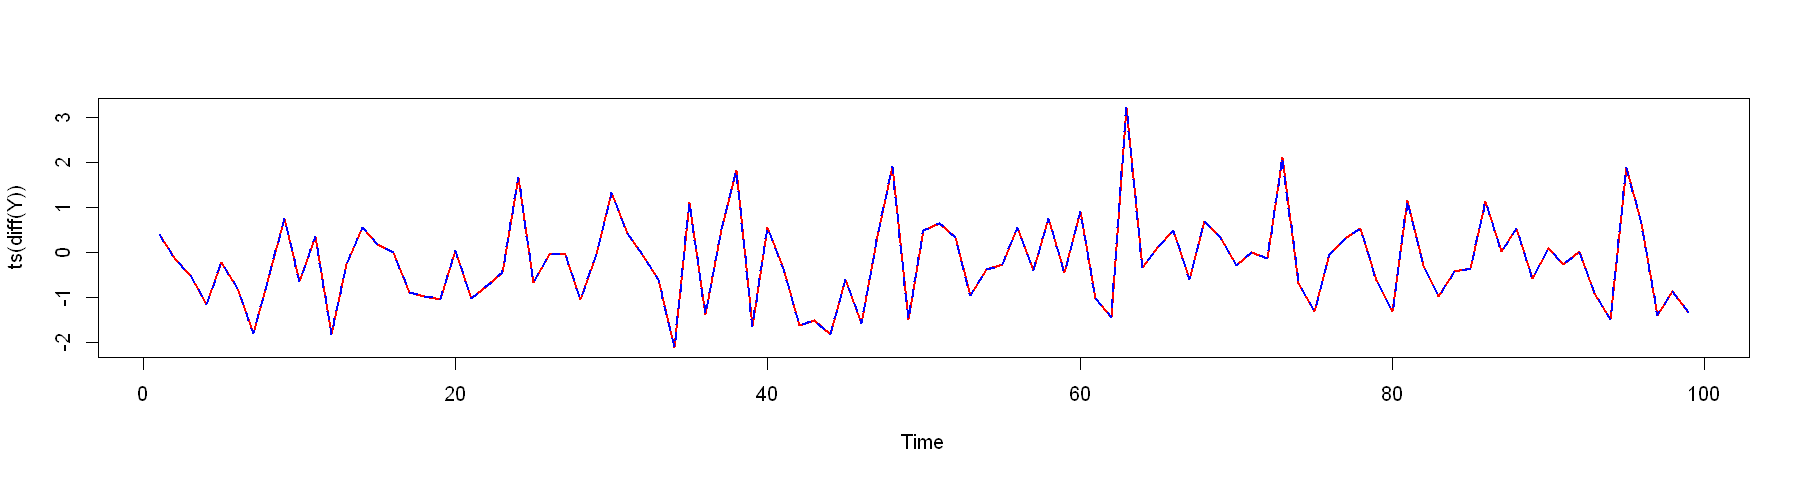

In [76]:
plot.ts(ts(diff(Y)), col = "red", lwd = 2)
lines(ts(dY), col = "blue", lty = 2, lwd = 2)

So, the two models are equivalent. For simulation and forecasting we may be more interested in $Y_t$ model, as it is the original series, which we are interested in.

## **[INFO: END]**

---
---
---

The final, 3rd model

In [77]:
print(round(coef(summary(mod.3)), 4))

                    Estimate Std. Error t value Pr(>|t|)
(Intercept)           0.0083     0.0129  0.6479   0.5173
L(lnyse)             -0.0001     0.0020 -0.0471   0.9624
L(d(lnyse), 1:14)1    0.0427     0.0446  0.9574   0.3388
L(d(lnyse), 1:14)2   -0.0317     0.0447 -0.7094   0.4784
L(d(lnyse), 1:14)3    0.0198     0.0447  0.4433   0.6577
L(d(lnyse), 1:14)4    0.0217     0.0447  0.4859   0.6273
L(d(lnyse), 1:14)5    0.0957     0.0447  2.1419   0.0327
L(d(lnyse), 1:14)6   -0.0753     0.0449 -1.6792   0.0937
L(d(lnyse), 1:14)7   -0.0379     0.0449 -0.8456   0.3982
L(d(lnyse), 1:14)8   -0.0733     0.0449 -1.6329   0.1031
L(d(lnyse), 1:14)9   -0.0017     0.0449 -0.0374   0.9701
L(d(lnyse), 1:14)10  -0.0232     0.0446 -0.5202   0.6031
L(d(lnyse), 1:14)11   0.0051     0.0446  0.1139   0.9093
L(d(lnyse), 1:14)12   0.0320     0.0445  0.7184   0.4729
L(d(lnyse), 1:14)13   0.0031     0.0445  0.0688   0.9452
L(d(lnyse), 1:14)14  -0.1046     0.0445 -2.3500   0.0192


The coefficient $\widehat{\rho}$ t-value is `L(lnyse) = -0.0471 > -2.89`. So we have no grounds to reject the null hypothesis and conclude that the series contains a unit root.

We will not re-write this models equations as they can be determined by applying the same methods as before.

---

**Overall, regardless of the lag order we see that the series has a unit root**. 

It is important to note, that removing the trend increased the t-statistic of $\widehat{\rho}$, so it is very possible that, if we incorrectly remove the trend - we may make an incorrect test conclusion.

---
---

## (3.2) Automatic Unit root testing

We will carry out different tests from different packages. For completeness sake, we will provide the same test results from more than one package.

### ADF test

The $\rm ADF$ test tests the null hypothesis: $H_0: \rho = 0 \text{ (i.e. the series contains a unit root)}$

We can set the maximum lag order, and choose the criterion for the order selection:

In [78]:
tst_adf_1 <- urca::ur.df(lnyse, type = "trend", lags = 18, selectlags = "BIC")
print(tst_adf_1)


############################################################### 
# Augmented Dickey-Fuller Test Unit Root / Cointegration Test # 
############################################################### 

The value of the test statistic is: -2.0965 6.0649 2.2091 



We can examine the model

In [79]:
tst_adf_1@testreg


Call:
lm(formula = z.diff ~ z.lag.1 + 1 + tt + z.diff.lag)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.219561 -0.024529  0.003247  0.026918  0.152312 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)  
(Intercept)  9.001e-02  4.010e-02   2.244   0.0252 *
z.lag.1     -1.755e-02  8.370e-03  -2.096   0.0365 *
tt           1.044e-04  5.041e-05   2.070   0.0390 *
z.diff.lag   5.043e-02  4.444e-02   1.135   0.2570  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.0409 on 506 degrees of freedom
Multiple R-squared:  0.01033,	Adjusted R-squared:  0.004462 
F-statistic:  1.76 on 3 and 506 DF,  p-value: 0.1538


The critical values can be extracted via `@cval`:

In [80]:
print(tst_adf_1@cval)

      1pct  5pct 10pct
tau3 -3.96 -3.41 -3.12
phi2  6.09  4.68  4.03
phi3  8.27  6.25  5.34


To carry out the unit root test, we examine the t-statistic of `z.lag.1` - it is `-2.096` (Note that this is the same as the first value in the output `The value of the test statistic is: -2.0965 6.0649 2.2091 `). The relevant critival value is `tau`, which is `-3.41` for the $5\%$ significance level. 

Since The test statistic `-2.096 > -3.45`, we do not reject the **null hypothesis of a unit root**.

---

The second way to carry out  and $\rm ADF$ test:

In [81]:
tst_adf_2 <- tseries::adf.test(lnyse, alternative = "stationary")

We can either manually specify the lag order, or let the function select the maximum lag order itself.

In [82]:
tst_adf_2


	Augmented Dickey-Fuller Test

data:  lnyse
Dickey-Fuller = -1.9019, Lag order = 8, p-value = 0.6198
alternative hypothesis: stationary


This output is a bit easier to read - the $p-value = 0.6198 > 0.05$, so we have no grounds to reject the **null hypothesis of a unit root**.

---

### KPSS test

The $\rm KPSS$ test tests the null hypothesis: $H_0: \text{ the data is stationary}$

The test involves specifying and estimating the following equation with a random-walk component:
$$
Y_t = r_t + \delta \cdot t + \epsilon_t,\quad r_t = r_{t-1} + u_t
$$

The null hypothesis of stationarity is equivalent  to the hypothesis: $H_0: \sigma^2_u = 0$, which would mean that $r_t = r_{t-1} = ... = r_0 = \rm const$ (i.e. a constant intercept).

We can set the number of lags to use the rule of thumb (`lags = "long"`, which is equivalent to $\root 4 \of {12 \times (n/100)}$), or `lags = "short"`, which is equivalent to $\root 4 \of {4 \times (n/100)}$. The test types specify as deterministic component either a constant `mu` or a constant with linear trend `tau`. 

In [83]:
tst_kpss_1 <- urca::ur.kpss(lnyse, type = "tau", lags = "long")
tst_kpss_1


####################################### 
# KPSS Unit Root / Cointegration Test # 
####################################### 

The value of the test statistic is: 0.3909 


We see that the test statistic is `0.3909`. The critical values are:

In [84]:
tst_kpss_1@cval

10pct 5pct  2.5pct 1pct 
critical values 0.119 0.146 0.176  0.216

Since `0.3909 > 0.146`, we reject the **null hypothesis of stationarity** and conclude that the series is not stationary.

---

The second way to carry out the `KPSS` test (where `lshort = FALSE` indicates to use the rule-of-thumb larger lag selection):

In [85]:
tst_kpss_2 <- tseries::kpss.test(lnyse, null = "Trend", lshort = FALSE)

Warning message in tseries::kpss.test(lnyse, null = "Trend", lshort = FALSE):
"p-value smaller than printed p-value"

In [86]:
print(tst_kpss_2)


	KPSS Test for Trend Stationarity

data:  lnyse
KPSS Trend = 0.43099, Truncation lag parameter = 16, p-value = 0.01



Since `p-value = 0.01 < 0.05`, we **reject the null hypothesis of stationarity and conclude that the series is not stationary.**

---

### PP test

The $\rm PP$ test tests builds on the ADF test and tests the null hypothesis: $H_0: \text{ (i.e. the series contains a unit root)}$.

We begin with the built-in function:

In [87]:
tst_pp_0 <- stats::PP.test(lnyse, lshort = FALSE)

In [88]:
tst_pp_0


	Phillips-Perron Unit Root Test

data:  lnyse
Dickey-Fuller = -1.9395, Truncation lag parameter = 18, p-value =
0.6039


`p-value = 0.6039 > 0.05`, so we have no grounds to reject the null hypothesis of a unit root.

---

The `urca` package also contains the $PP$ test:

In [89]:
tst_pp_1 <- urca::ur.pp(lnyse, model = "trend", type = "Z-tau", lags = "long")
tst_pp_1


################################################## 
# Phillips-Perron Unit Root / Cointegration Test # 
################################################## 

The value of the test statistic is: -1.9393 


**Note: use `type = "Z-tau"`, otherwise the critical values will be missing!**.

If we are interested, we can examine the specified regression, which was used for this test:

In [90]:
tst_pp_1@testreg


Call:
lm(formula = y ~ y.l1 + trend)

Residuals:
      Min        1Q    Median        3Q       Max 
-0.221927 -0.025066  0.002876  0.026943  0.147915 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 1.045e-01  5.145e-02   2.032   0.0427 *  
y.l1        9.845e-01  8.151e-03 120.792   <2e-16 ***
trend       9.600e-05  4.958e-05   1.936   0.0534 .  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04055 on 525 degrees of freedom
Multiple R-squared:  0.9981,	Adjusted R-squared:  0.9981 
F-statistic: 1.38e+05 on 2 and 525 DF,  p-value: < 2.2e-16


Although the critical test statistic is calculated differently than the one in the $ADF$ test, the critical values for the PP test are the same as for the DF test. 

The critical values are:

In [91]:
tst_pp_1@cval

1pct     5pct      10pct    
critical values -3.97979 -3.420314 -3.132507

Since the value of the test statistic `-1.9393` is greater than the $5\%$ critical value `-3.420314`, **we have no grounds to reject the null hypothesis of a unit root.**

---

The `tseries` package also has the $PP$ test:

In [92]:
tst_pp_2 <- tseries::pp.test(lnyse, alternative = "stationary", type = "Z(t_alpha)", lshort = FALSE)

In [93]:
tst_pp_2


	Phillips-Perron Unit Root Test

data:  lnyse
Dickey-Fuller Z(t_alpha) = -1.9395, Truncation lag parameter = 18,
p-value = 0.6039
alternative hypothesis: stationary


The `p-value = 0.6039 > 0.05`, **we have no grounds to reject the null hypothesis and conclude that the series has a unit root.**

---

**So, we can conclude that all tests indicate that the series has a unit root.**

---

In [94]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 10)
options(repr.plot.height = 4)

# (4) Model Building

Since we have determined that the series has a unit root (and we see no indication of seasonality), we can take the differences of the series:

In [95]:
dlnyse <- diff(lnyse)

If we examine the series:

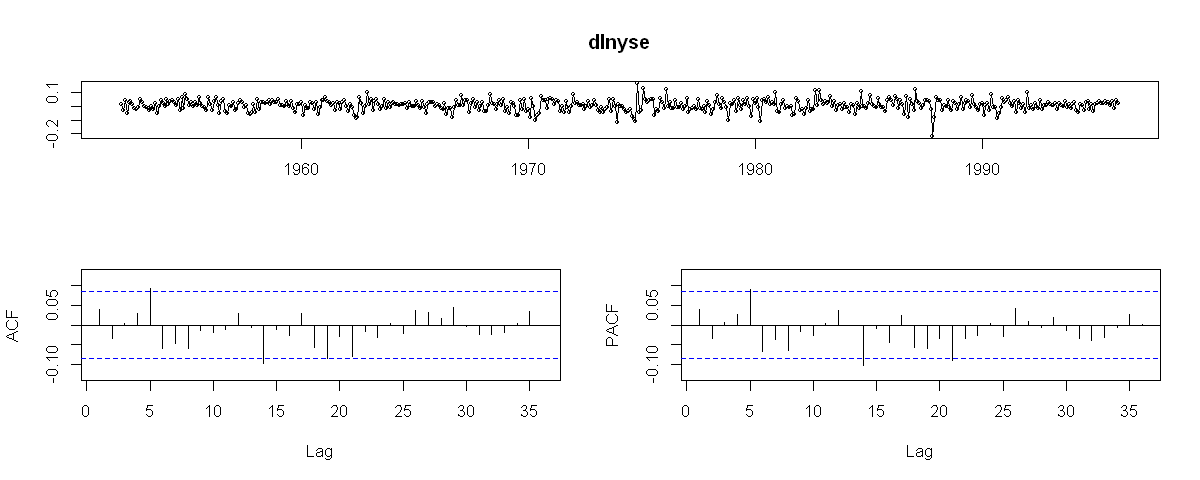

In [96]:
forecast::tsdisplay(dlnyse)

The series appear to be stationary. We will test this by repeating the unit root tests on the differenced data. For simplicity, we will use the test, which have the `p-values`, from the `tseries` package:

In [97]:
tseries::adf.test(dlnyse, alternative = "stationary")

Warning message in tseries::adf.test(dlnyse, alternative = "stationary"):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  dlnyse
Dickey-Fuller = -8.1328, Lag order = 8, p-value = 0.01
alternative hypothesis: stationary


$p-value = 0.01 < 0.05$, so we **reject the null hypothesis of a unit root**.

In [98]:
tseries::kpss.test(dlnyse, null = "Level", lshort = FALSE)

Warning message in tseries::kpss.test(dlnyse, null = "Level", lshort = FALSE):
"p-value greater than printed p-value"


	KPSS Test for Level Stationarity

data:  dlnyse
KPSS Level = 0.095985, Truncation lag parameter = 16, p-value = 0.1


$p-value = 0.1 > 0.05$, so **we have no grounds to reject the null hypothesis of stationarity**.

In [99]:
tseries::pp.test(dlnyse, alternative = "stationary", type = "Z(t_alpha)", lshort = FALSE)

Warning message in tseries::pp.test(dlnyse, alternative = "stationary", type = "Z(t_alpha)", :
"p-value smaller than printed p-value"


	Phillips-Perron Unit Root Test

data:  dlnyse
Dickey-Fuller Z(t_alpha) = -22.021, Truncation lag parameter = 18,
p-value = 0.01
alternative hypothesis: stationary


$p-value = 0.01 < 0.05$, so we **reject the null hypothesis of a unit root**.

In other words, the differences, $\Delta Y_t$, are stationary.

---


To make it interesting, we will specify three different models:

- A model based on one selected from the $\rm ADF$ test;
- A model based on the $\rm ACF$, $\rm PACF$ of $\Delta Y_t$;
- An automatically specified model via `auto.arima`, without any restrictions.

---


## - From the `ADF` test we select and re-estimate `mod.2` model (this is a different parametrization than the one on `dynlm`)

Furthermore, we will only be able to estimate the drift component, since if $Y_t$ contais a constant $\alpha$ and trend $\delta \cdot t$, then $\Delta Y_t$ contains $\delta$. 

In this specification $\alpha$ is not identifiable.

In [100]:
mdl_4_1 <- forecast::Arima(lnyse, order = c(5, 1, 0), xreg = data.frame(tt = 1:length(lnyse)))

In [101]:
print(mdl_4_1)

Series: lnyse 
Regression with ARIMA(5,1,0) errors 

Coefficients:
         ar1      ar2     ar3     ar4     ar5      tt
      0.0380  -0.0350  0.0089  0.0228  0.0923  0.0069
s.e.  0.0433   0.0434  0.0434  0.0434  0.0434  0.0020

sigma^2 estimated as 0.001645:  log likelihood=945.98
AIC=-1877.96   AICc=-1877.75   BIC=-1848.08


The residuals of this model:

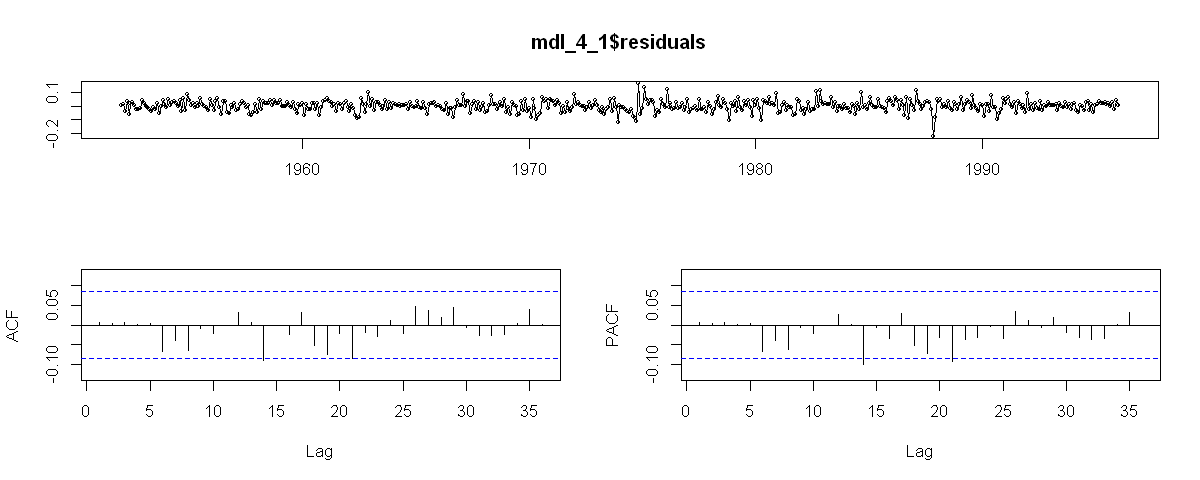

In [102]:
forecast::tsdisplay(mdl_4_1$residuals)

Appear to be white noise.

---
---
---

## **[INFO: START]**

We will now expand upon what a *different parametrization* entails for models specified `dynlm` versus the ones specified with `Arima()`.

#### - The model, specified via `forecast::Arima` (or via `stats::arima`) is specified as a process with a linear trend, whose **deviations from the trend are described as the AR(1) process:**

For example, assume that we would want to specify a model as a stationary $\rm AR(1)$ model with a trend using `forecast::Arima` (or `stats::arima`) the specification is as follows:

$
\begin{cases}
Y_t &= \alpha + \delta \cdot t + u_t,\\
u_t &= \phi u_{t-1} + \epsilon_t
\end{cases}
$

In [103]:
mod.a1 <- stats::arima(lnyse, order = c(1,0,0), xreg=time(lnyse))
mod.a1


Call:
stats::arima(x = lnyse, order = c(1, 0, 0), xreg = time(lnyse))

Coefficients:
         ar1  intercept  time(lnyse)
      0.9832  -144.2528       0.0763
s.e.  0.0076    12.4969       0.0063

sigma^2 estimated as 0.001632:  log likelihood = 945.18,  aic = -1882.37

In [104]:
mod.a2 <- forecast::Arima(lnyse, order = c(1,0,0), xreg=time(lnyse))
mod.a2

Series: lnyse 
Regression with ARIMA(1,0,0) errors 

Coefficients:
         ar1  intercept  time(lnyse)
      0.9832  -144.2528       0.0763
s.e.  0.0076    12.4969       0.0063

sigma^2 estimated as 0.001642:  log likelihood=945.18
AIC=-1882.37   AICc=-1882.29   BIC=-1865.28

The estimated model is:

$
\begin{cases}
Y_t &= -144.2528 + 0.0763 \cdot t + u_t,\\
u_t &= 0.9832 u_{t-1} + \epsilon_t
\end{cases}
$

In this case, we would want to test whether the **residuals** exhibit a unit root by testing whether $\phi = 1$.

#### - The model, specified via `dynlm::dynlm` is specified as **an autoregressive process with a linear trend:**

From the (1) expression we would have that:


$
\begin{cases}
u_t &= Y_t - \alpha - \delta \cdot t,\\
u_t &= \phi u_{t-1} + \epsilon_t
\end{cases} \Longrightarrow
Y_t - \alpha - \delta \cdot t = \phi \left(Y_{t-1} - \alpha - \delta \cdot (t-1) \right) + \epsilon_t
$

which means that an alternative specification involves a **reparametrization** of the previous process as:

$
\begin{aligned}
Y_t &= \tilde{\alpha} + \tilde{\delta} \cdot t + \phi Y_{t-1} + \epsilon_t = \left[ (1 - \phi) \alpha + \phi \delta\right] + \left[ (1 - \phi)\delta \right] \cdot t + \phi Y_{t-1} + \epsilon_t
\end{aligned}
$

which is as an autoregressive process with a linear trend. 

This is the specification that `dynlm::dynlm(...)` uses:

In [105]:
mod.b1 <- dynlm::dynlm(lnyse ~ time(lnyse) + L(lnyse))
summary(mod.b1)


Time series regression with "ts" data:
Start = 1952(2), End = 1996(1)

Call:
dynlm::dynlm(formula = lnyse ~ time(lnyse) + L(lnyse))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.221927 -0.025066  0.002876  0.026943  0.147915 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -2.169524   1.124569  -1.929   0.0542 .  
time(lnyse)  0.001152   0.000595   1.936   0.0534 .  
L(lnyse)     0.984518   0.008150 120.792   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.04055 on 525 degrees of freedom
Multiple R-squared:  0.9981,	Adjusted R-squared:  0.9981 
F-statistic: 1.38e+05 on 2 and 525 DF,  p-value: < 2.2e-16


The estimated model is:

$
\begin{aligned}
Y_t &= 2.169524 + 0.001152 \cdot t + 0.984518 Y_{t-1} + \epsilon_t
\end{aligned}
$

The models are equivalent, but due to the parametrization $\alpha \neq \tilde \alpha$ and $\delta \neq \tilde{\delta}$. The autoregressive coefficient $\widehat{\phi}$ also differ due to different parameter estimation methods (which again may further differ for different parametrization options). However they are fairly close: `ar1 = 0.9832` versus `L(lnyse) = 0.984518`.

If we use the parametrization on the estimated coefficients from the first model, we would have that:

$
\begin{aligned}
\tilde{\alpha}  &= \left[ (1 - \phi) \alpha + \phi \delta\right]\\
\tilde{\delta} &=\left[ (1 - \phi)\delta \right]
\end{aligned}
$

In [106]:
# tilde{alpha}
(1 - 0.9832) * (-144.2528) + 0.9832 * 0.0763

[1] -2.348429

In [107]:
# tilde{delta}
(1 - 0.9832) * 0.0763

[1] 0.00128184

We see that they are fairly close to `(Intercept) = -2.169524` and `time(lnyse) = 0.001152` respectively.

## **[INFO: END]**

---
---
---

## - Selecting the model based on the ACF and PACF of the series:

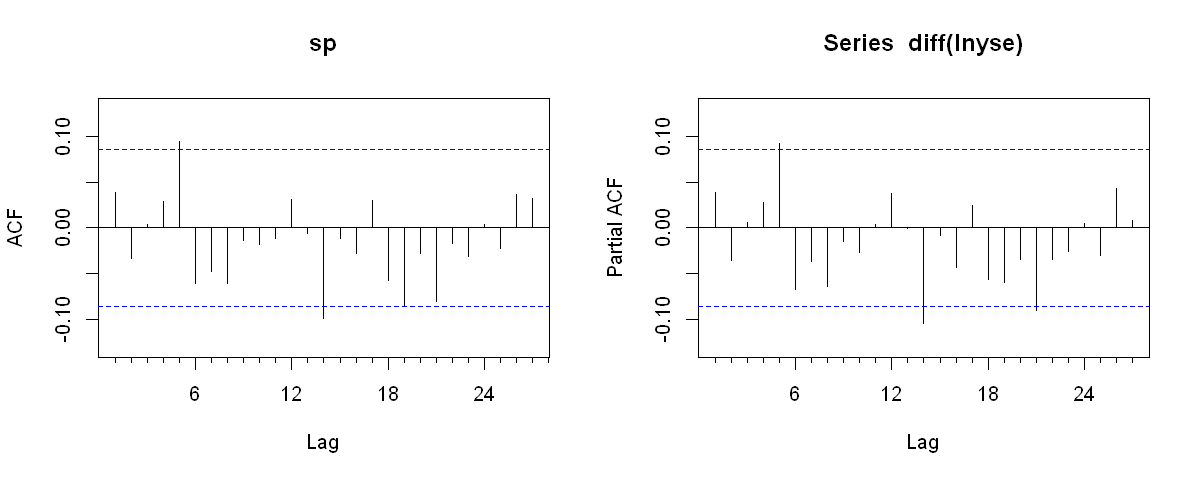

In [108]:
par(mfrow = c(1, 2))
forecast::Acf(diff(lnyse))
forecast::Pacf(diff(lnyse))

We can test the lag significance via the $Ljung-Box$ test. The null hypothesis is:
$$
\begin{aligned}
H_0&: \rho(1) = ... = \rho(k) = 0\\
H_1&: \exists j: \rho(j) \neq 0
\end{aligned}
$$
We will test, whether the first `20` lags have a significant autocorrelation with different values of $k$:

In [109]:
for(i in 1:20){
    aa <- Box.test(diff(lnyse), lag = i, type = "Ljung-Box")
    print(paste0("lag = ", i, " p-value = ", round(aa$p.value, 5)))
}

[1] "lag = 1 p-value = 0.36736"
[1] "lag = 2 p-value = 0.49395"
[1] "lag = 3 p-value = 0.70145"
[1] "lag = 4 p-value = 0.76131"
[1] "lag = 5 p-value = 0.25479"
[1] "lag = 6 p-value = 0.20216"
[1] "lag = 7 p-value = 0.20613"
[1] "lag = 8 p-value = 0.1685"
[1] "lag = 9 p-value = 0.2293"
[1] "lag = 10 p-value = 0.29176"
[1] "lag = 11 p-value = 0.36542"
[1] "lag = 12 p-value = 0.40789"
[1] "lag = 13 p-value = 0.48727"
[1] "lag = 14 p-value = 0.21937"
[1] "lag = 15 p-value = 0.27295"
[1] "lag = 16 p-value = 0.31138"
[1] "lag = 17 p-value = 0.34642"
[1] "lag = 18 p-value = 0.30703"
[1] "lag = 19 p-value = 0.17814"
[1] "lag = 20 p-value = 0.20485"


We see that in all cases the $p-value > 0.05$, so we have no grounds to reject the null hypothesis. This indicates that the differences, $\Delta Y_t$, are white noise. We can specify the model as:

In [110]:
mdl_4_2 <- forecast::Arima(lnyse, order = c(0, 1, 0), include.drift = TRUE)

In [111]:
print(mdl_4_2)

Series: lnyse 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0069
s.e.  0.0018

sigma^2 estimated as 0.00165:  log likelihood=942.79
AIC=-1881.59   AICc=-1881.56   BIC=-1873.05


The residuals

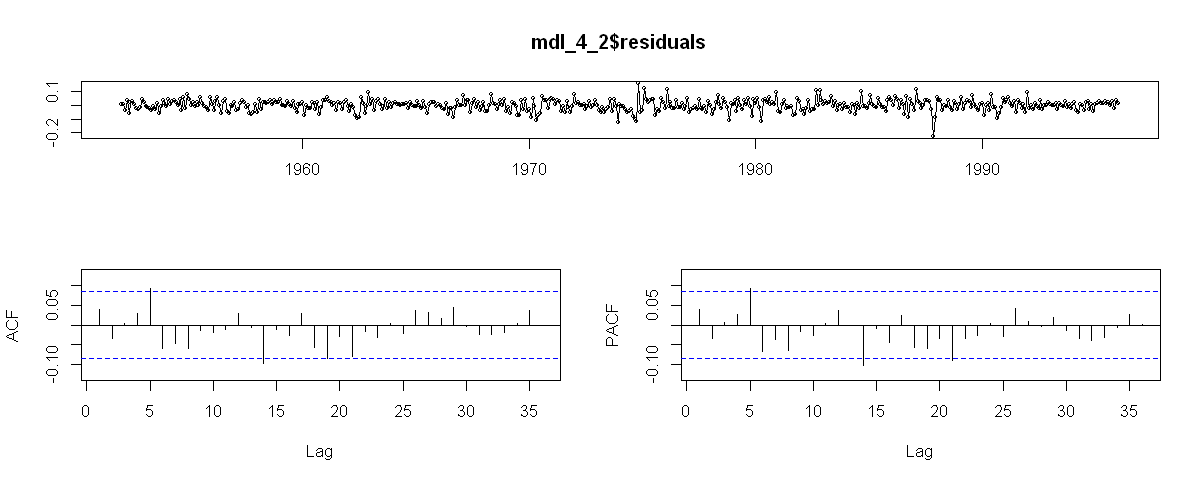

In [112]:
forecast::tsdisplay(mdl_4_2$residuals)

In [113]:
for(i in (length(coef(mdl_4_2)) + 1):20){
    aa <- Box.test(mdl_4_2$residuals, lag = i, type = "Ljung-Box", fitdf = length(coef(mdl_4_2)))
    print(paste0("lag = ", i, " p-value = ", round(aa$p.value, 5)))
}

[1] "lag = 2 p-value = 0.233"
[1] "lag = 3 p-value = 0.48918"
[1] "lag = 4 p-value = 0.60088"
[1] "lag = 5 p-value = 0.15918"
[1] "lag = 6 p-value = 0.12887"
[1] "lag = 7 p-value = 0.13701"
[1] "lag = 8 p-value = 0.1124"
[1] "lag = 9 p-value = 0.16249"
[1] "lag = 10 p-value = 0.21714"
[1] "lag = 11 p-value = 0.28468"
[1] "lag = 12 p-value = 0.32625"
[1] "lag = 13 p-value = 0.40394"
[1] "lag = 14 p-value = 0.16598"
[1] "lag = 15 p-value = 0.21319"
[1] "lag = 16 p-value = 0.2484"
[1] "lag = 17 p-value = 0.28167"
[1] "lag = 18 p-value = 0.24748"
[1] "lag = 19 p-value = 0.1376"
[1] "lag = 20 p-value = 0.1608"


The residuals are white noise. So this model appears to be adequate. The residuals of the previous model:

In [114]:
for(i in (length(coef(mdl_4_1))+1):20){
    aa <- Box.test(mdl_4_1$residuals, lag = i, type = "Ljung-Box", fitdf = length(coef(mdl_4_1)))
    print(paste0("lag = ", i, " p-value = ", round(aa$p.value, 5)))
}

[1] "lag = 7 p-value = 0.06977"
[1] "lag = 8 p-value = 0.06436"
[1] "lag = 9 p-value = 0.13757"
[1] "lag = 10 p-value = 0.21511"
[1] "lag = 11 p-value = 0.32666"
[1] "lag = 12 p-value = 0.38641"
[1] "lag = 13 p-value = 0.49784"
[1] "lag = 14 p-value = 0.22004"
[1] "lag = 15 p-value = 0.29774"
[1] "lag = 16 p-value = 0.35561"
[1] "lag = 17 p-value = 0.3971"
[1] "lag = 18 p-value = 0.36719"
[1] "lag = 19 p-value = 0.23814"
[1] "lag = 20 p-value = 0.28593"


are also WN.

## - `auto.arima` without any restrictions

In [115]:
mdl_4_3 <- forecast::auto.arima(lnyse)

In [116]:
print(mdl_4_3)

Series: lnyse 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0069
s.e.  0.0018

sigma^2 estimated as 0.00165:  log likelihood=942.79
AIC=-1881.59   AICc=-1881.56   BIC=-1873.05


So, `mdl_4_3` is the same as `mdl_4_2`.

If we'd like, we can compare the models via AIC/BIC:

In [117]:
a <- data.frame(mdl_4_1 = c(AIC(mdl_4_1), BIC(mdl_4_1)),
                mdl_4_2 = c(AIC(mdl_4_2), BIC(mdl_4_2)))
rownames(a) <- c("AIC", "BIC")
print(a)

      mdl_4_1   mdl_4_2
AIC -1877.962 -1881.587
BIC -1848.078 -1873.049


Overall, the second model, `mdl_4_2`, appears to be better, since its AIC and BIC values are smaller.

---
---
---

## **[INFO: START]**

Intuitively, we may assume that we can simply differenciate the data and then fit the model on the differences.

In [118]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 5)
options(repr.plot.height = 4)

For, example, the $\rm ARIMA(0, 1, 0)$ on $Y_t$:

In [119]:
m_tst_1 <- forecast::Arima(lnyse, order = c(0, 1, 0), include.drift = TRUE)
m_tst_1

Series: lnyse 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0069
s.e.  0.0018

sigma^2 estimated as 0.00165:  log likelihood=942.79
AIC=-1881.59   AICc=-1881.56   BIC=-1873.05

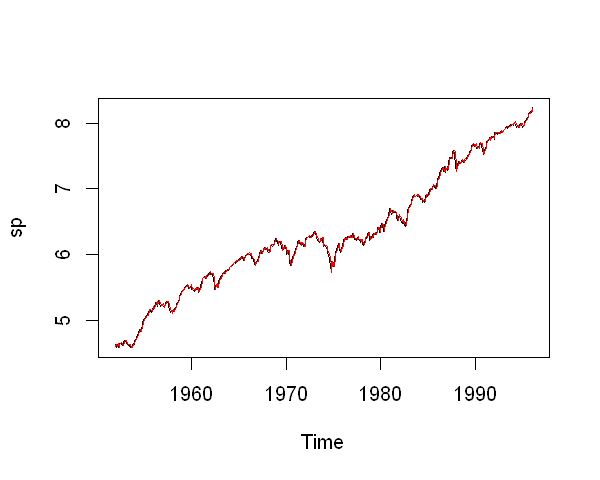

In [120]:
plot(lnyse)
lines(m_tst_1$fitted, col = "red")

Can be written as a $\rm ARIMA(0, 0, 0)$ model on the differences $\Delta Y_t$:

In [121]:
m_tst_2 <- forecast::Arima(diff(lnyse), order = c(0, 0, 0), include.constant = TRUE)
m_tst_2

Series: diff(lnyse) 
ARIMA(0,0,0) with non-zero mean 

Coefficients:
        mean
      0.0069
s.e.  0.0018

sigma^2 estimated as 0.00165:  log likelihood=942.79
AIC=-1881.59   AICc=-1881.56   BIC=-1873.05

While the model **appears** to be the same. If we were to estimate the fit - the fitted values are then calculated for $\widehat{\Delta Y_t}$:

In [122]:
head(fitted(m_tst_2), 10)

            Feb        Mar        Apr        May        Jun        Jul
1952 0.00686458 0.00686458 0.00686458 0.00686458 0.00686458 0.00686458
            Aug        Sep        Oct        Nov
1952 0.00686458 0.00686458 0.00686458 0.00686458

which are constant. This is to be expected, since our model for $\widehat{\Delta Y_t}$ is in fact a constant. Unfortunately, in this case the forecasts are **NOT** the same the $\rm ARIMA(0, 1, 0)$ models on $Y_t$, even if we compare the differences:

In [123]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 15)
options(repr.plot.height = 4)

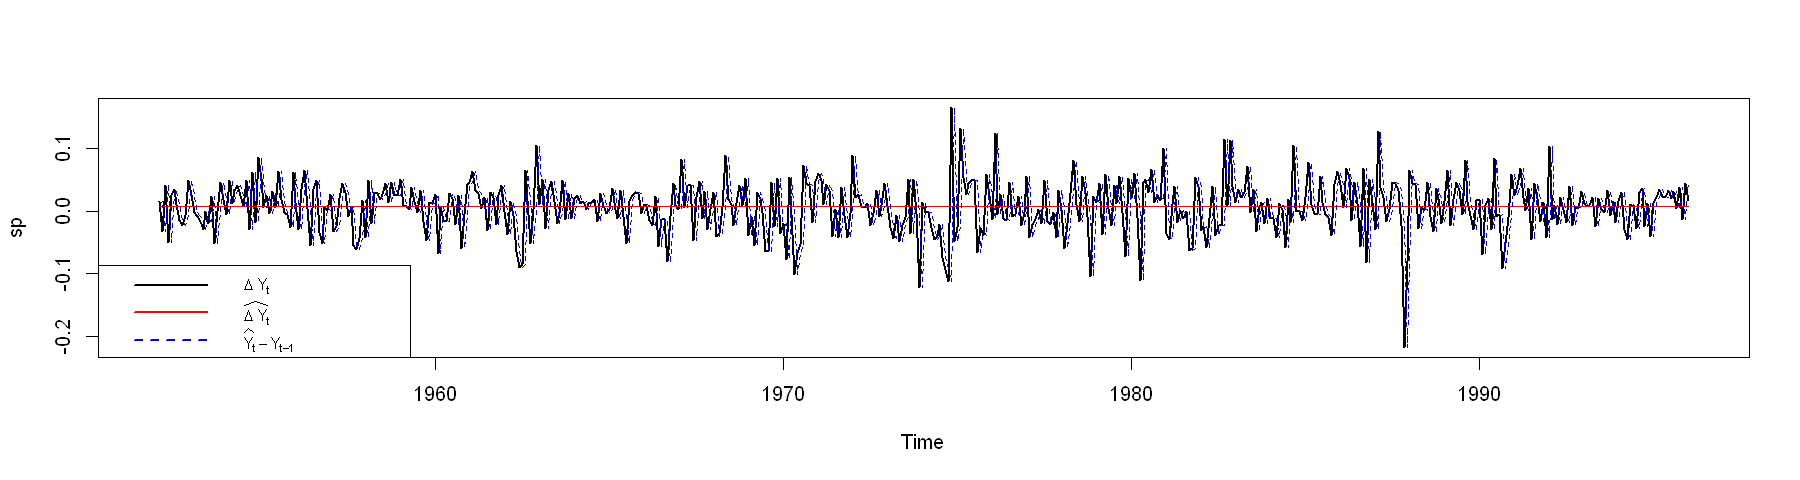

In [124]:
plot(diff(lnyse), lwd = 2)
lines(fitted(m_tst_2), col = "red")
lines(diff(m_tst_1$fitted), col = "blue", lty = 2)
legend("bottomleft", y.intersp = 3, cex = 0.8,
       legend = c(as.expression(bquote(Delta~Y[t])), as.expression(bquote(widehat(Delta~Y)[t])), as.expression(bquote(widehat(Y)[t] - Y[t-1]))),
       lty = c(1, 1, 2), col = c("black", "red", "blue"), lwd = 2)

Check out a comment on [stackoverflow](https://stats.stackexchange.com/a/32799) by the author of the forecast package. For $\Delta Y_t \sim AR(1)$ the difference is that:

- When fitting a $I(1)$ model on $Y_t$, the fitted values are: $$\widehat{Y}_t = Y_{t-1} + \widehat{\gamma}\cdot(Y_{t-1} - Y_{t-2})$$

- When fitting a $I(0)$ model on $\Delta Y_t$, the fitted values are: $$\widehat{\Delta {Y}}_t = \widehat{\gamma}\cdot(Y_{t-1} - Y_{t-2})$$

In our case this is equivalent to comparing the fitted values of $\widehat{(Y_{t-1} - Y_{t-2})} = \widehat{\alpha}$ versus $\widehat{Y}_t = \widehat{\alpha} + Y_{t-1}$.

The problem is that in general $\widehat{Y}_t - Y_{t-1} \neq \widehat{\Delta {Y}}_t$.

Fortunately, once we have the coefficient estimates we can use the parametrization (assuming that $H_0: \rho = 0$ is not rejected): $\Delta Y_t = \alpha + \delta \cdot t \sum_{j = 1}^{p-1} \gamma_j \Delta Y_{t-j} + \epsilon_t$

In this case, our equation is: $\Delta Y_t = \alpha + \epsilon_t$.

Since we do not want to calulate $\widehat{\Delta Y}_t$, but rather $\widehat{Y}_t$, we simply apply the definition of $\Delta$ and get: $Y_t = \alpha + Y_{t-1} + \epsilon_t$.

**The two equations are equivalent, just with a different parametrization. If we fit a model on manually-calculated $\Delta Y_t$ - there is no way for the software to detect that you took the differences MANUALLY**. 

This is also evident from the fact that the coefficients are identical (though they may sometimes differ due to different starting values for differenced versus non-differenced data).

Remember that **the fitted values are calculated as a conditional expectation on $Y_t$, conditionally that any variables on the right-hand-side are given**, hence (replacing $\epsilon_t$ with its mean of zero):
$$
\widehat{Y}_t = \widehat{\alpha} + Y_{t-1},\ t = 2,...,T
$$
Assuming that our series starts at $Y_1$ with $Y_s = 0$ for $s \leq 0$.

(if we had a moving-average part, we could calculate $\widehat{\epsilon}_s = Y_s - \widehat{Y}_s$ for $s < t$ and use the residuals for for $t + 1$).

In the case of the differences model, we have that:

In [125]:
y_fit <- coef(m_tst_2) + lnyse[-length(lnyse)]

The first fitted value is equal to the true value

In [126]:
lnyse[1]

[1] 4.60517

We can compare the fitted values with the ones from the ARIMA model on $Y_t$:

In [127]:
aa <- data.frame(m_tst_1$fitted,  c(NA, y_fit))
colnames(aa) <- c("Y_ARIMA", "dY_ARMA")
aa$diff <- aa$Y_ARIMA - aa$dY_ARMA
head(aa)

Y_ARIMA  dY_ARMA  diff         
1 4.600572       NA            NA
2 4.612035 4.612035 -2.486900e-14
3 4.627495 4.627495  1.154632e-14
4 4.595446 4.595446  1.154632e-14
5 4.636687 4.636687  1.154632e-14
6 4.586286 4.586286  1.154632e-14

In [128]:
summary(aa$diff)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
      0       0       0       0       0       0       1 

Obviously then `diff(aa$Y_ARIMA)` and `diff(aa$dY_ARMA)` will also be equal. However, this is different from `fitted(m_tst_2)`:

In [129]:
bbb <- data.frame(diff(m_tst_1$fitted),  m_tst_2$fitted)
colnames(bbb) <- c("Y_ARIMA_diff", "dY_ARMA_diff")
bbb$diff <- bbb$Y_ARIMA - bbb$dY_ARMA
head(bbb)

Y_ARIMA_diff dY_ARMA_diff diff        
1  0.01146288  0.00686458    0.004598303
2  0.01546000  0.00686458    0.008595420
3 -0.03204900  0.00686458   -0.038913580
4  0.04124100  0.00686458    0.034376420
5 -0.05040100  0.00686458   -0.057265580
6  0.02504100  0.00686458    0.018176420

In [130]:
summary(bbb$diff)

      Min.    1st Qu.     Median       Mean    3rd Qu.       Max. 
-0.2253176 -0.0242888  0.0024959 -0.0000115  0.0260387  0.1579624 

All in all, it is much easier to specify the model for $Y_t$, instead of manually calculating the differences and estimating a model on $\Delta Y_t$, as most forecasting and fittign functions are readily available.

## **[INFO: END]**

---
---
---

# (5) Writing down the model for $\Delta Y_t$ and $Y_t$

Assume that we have selected the following model as the "best" one:

In [131]:
mdl_4_2

Series: lnyse 
ARIMA(0,1,0) with drift 

Coefficients:
       drift
      0.0069
s.e.  0.0018

sigma^2 estimated as 0.00165:  log likelihood=942.79
AIC=-1881.59   AICc=-1881.56   BIC=-1873.05

which we can write as: $\Delta Y_{t} = 0.0069 + \epsilon_t$, or equivalently as: $Y_t = 0.0069 + Y_{t-1} + \epsilon_t$. In other words, this is a random walk with drift.

Assume that we are not so "lucky" and our model is much more complex. For example

In [132]:
mod.2 <- dynlm(d(lnyse) ~ L(d(lnyse), 1:5) + time(lnyse))
print(round(coef(summary(mod.2)), 5))

                  Estimate Std. Error  t value Pr(>|t|)
(Intercept)       -0.07357    0.27887 -0.26382  0.79203
L(d(lnyse), 1:5)1  0.04398    0.04382  1.00357  0.31606
L(d(lnyse), 1:5)2 -0.03932    0.04380 -0.89786  0.36968
L(d(lnyse), 1:5)3  0.01035    0.04380  0.23620  0.81337
L(d(lnyse), 1:5)4  0.02288    0.04376  0.52299  0.60121
L(d(lnyse), 1:5)5  0.09225    0.04373  2.10951  0.03538
time(lnyse)        0.00004    0.00014  0.28548  0.77539


Since we needed the trend for unit root testing - having removed the insignificant $\rho$ coefficient, we could try to remove the insignificant trend and improve our model. But we will assume that this model is acceptible as is.

Remembering the model parametrization of `dynlm`, the estimated model for $\Delta Y_t$ is: 

$\Delta Y_t = -0.07357 + 0.00004 \cdot t + 0.04398 \Delta Y_{t-1} -0.03932 \Delta Y_{t-2} + 0.01035 \Delta Y_{t-3} + 0.02288 \Delta Y_{t-4} + 0.09225 \Delta Y_{t-5} + \epsilon_t$, 

which we can re-write as a model for $Y_t$. 

We use the property $\gamma_j = -[\phi_{j+1} + ... + \phi_p]$, $j = 1, ..., p - 1$ and the expression of $\rho$ to get the coefficients:

$
\begin{aligned}
\gamma_5 &= - \phi_6 &&\Longrightarrow \phi_6 = - \gamma_5 = -0.09225\\
\gamma_4 &= - [\phi_5 + \phi_6] &&\Longrightarrow \phi_5 = - \gamma_4 - \phi_6 = -0.02288+0.09225 = 0.06937\\
\gamma_3 &= - [\phi_4 + \phi_5 + \phi_6] &&\Longrightarrow \phi_4 = - \gamma_3 - [\phi_5 + \phi_6] = - \gamma_3 + \gamma_4 =  -0.01035+0.02288 = 0.01253\\
\gamma_2 &= - [\phi_3 + \phi_4 + \phi_5 + \phi_6] &&\Longrightarrow \phi_3 = - \gamma_2 + \gamma_3 = 0.03932 + 0.01035 = 0.04967\\
\gamma_1 &= - [\phi_2 + \phi_3 + \phi_4 + \phi_5 + \phi_6] &&\Longrightarrow \phi_2 = - \gamma_1 + \gamma_2 = -0.04398 -0.03932 = -0.0833\\
\rho &= \phi_1 + \phi_2 + \phi_3 + \phi_4 + \phi_5 + \phi_6 - 1,\text{ since } \rho = 0 &&\Longrightarrow \phi_1 = 1 - (\phi_2 + \phi_3 + \phi_4 + \phi_5 + \phi_6) = 1 + \gamma_1= 1 + 0.04398 = 1.04398
\end{aligned}
$

---

So, the equivalent model for $Y_t$ is:

$Y_t = -0.07357 + 0.00004 \cdot t + 1.04398 Y_{t-1} -0.0833 Y_{t-2} + 0.04967 Y_{t-3} + 0.01253 Y_{t-4} + 0.06937 Y_{t-5} -0.09225 Y_{t-6} + \epsilon_t$

---
---
---

## **[INFO: START]**

To verify that this is indeed the correct transformation, we can try to simulate a few observations with the same residuals:

In [133]:
set.seed(123)
N <- 200
eps <- rnorm(mean = 0, sd = 1, n = N)
tt  <- 1:length(eps)

First, we will simulate $Y_t$:

In [134]:
Y <- NULL
Y[1] <- -0.07357 + 0.00004 * tt[1] + eps[1]
Y[2] <- -0.07357 + 0.00004 * tt[2] + 1.04398 * Y[1] + eps[2]
Y[3] <- -0.07357 + 0.00004 * tt[3] + 1.04398 * Y[2] −0.0833 * Y[1] + eps[3]
Y[4] <- -0.07357 + 0.00004 * tt[4] + 1.04398 * Y[3] −0.0833 * Y[2] + 0.04967 * Y[1] + eps[4]
Y[5] <- -0.07357 + 0.00004 * tt[5] + 1.04398 * Y[4] −0.0833 * Y[3] + 0.04967 * Y[2] + 0.01253 * Y[1] + eps[5]
Y[6] <- -0.07357 + 0.00004 * tt[6] + 1.04398 * Y[5] −0.0833 * Y[4] + 0.04967 * Y[3] + 0.01253 * Y[2] + 0.06937 * Y[1] + eps[6]
for(j in 7:N){
    Y[j] <- -0.07357  + 0.00004 * tt[j] + 1.04398 * Y[j-1] −0.0833 * Y[j-2] + 0.04967 * Y[j - 3] + 0.01253 * Y[j - 4] + 0.06937 * Y[j - 5] − 0.09225 * Y[j - 6] + eps[j]    
}

Secondly, we will simulate $\Delta Y_t$:

In [135]:
dY <- NULL
dY[1] <- -0.0735  + 0.00004 * tt[1] + eps[1]
dY[2] <- -0.07357 + 0.00004 * tt[2] + 0.04398 * dY[1] + eps[2]
dY[3] <- -0.07357 + 0.00004 * tt[3] + 0.04398 * dY[2] −0.03932 * dY[1] + eps[3]
dY[4] <- -0.07357 + 0.00004 * tt[4] + 0.04398 * dY[3] −0.03932 * dY[2] + 0.01035 * dY[1] + eps[4]
dY[5] <- -0.07357 + 0.00004 * tt[5] + 0.04398 * dY[4] −0.03932 * dY[3] + 0.01035 * dY[2] + 0.02288 * dY[1] + eps[5]
for(j in 6:N){
    dY[j] <- -0.07357 + 0.00004 * tt[j] + 0.04398 * dY[j-1] −0.03932 * dY[j-2] + 0.01035 * dY[j - 3] + 0.02288 * dY[j - 4] + 0.09225 * dY[j - 5] + eps[j]    
}

Finally, we will assume that the first `100`, or so, observations of $Y_t$ are burn-in values (since the first couple of values assume that $Y_j = \epsilon_j = 0$, for $j \leq 0$). This means that we treat treat the first `101` $\Delta Y_t$ values as burn-in values as well and drop them:

In [136]:
Y <- Y[-c(1:100)]

In [137]:
dY <- dY[-c(1:101)]

We can compare $\Delta Y_t$ with $Y_t - Y_{t-1}$:

In [138]:
dt_compare <- data.frame(diff(Y), dY)
dt_compare$DIFFERENCE <- round(diff(Y) - dY, 10)
head(dt_compare)

diff.Y.    dY         DIFFERENCE
1  0.4191779  0.4191779 0         
2 -0.1389262 -0.1389262 0         
3 -0.5043527 -0.5043527 0         
4 -1.1470432 -1.1470432 0         
5 -0.2097488 -0.2097488 0         
6 -0.7880470 -0.7880470 0

We see that there is no difference between the simulate $Y_t - Y_{t-1}$ (`diff.Y.`), which was calculated from the simulated $Y_t$ series, and $\Delta Y_t$ (`dY`).

We can also visually compare the charts:

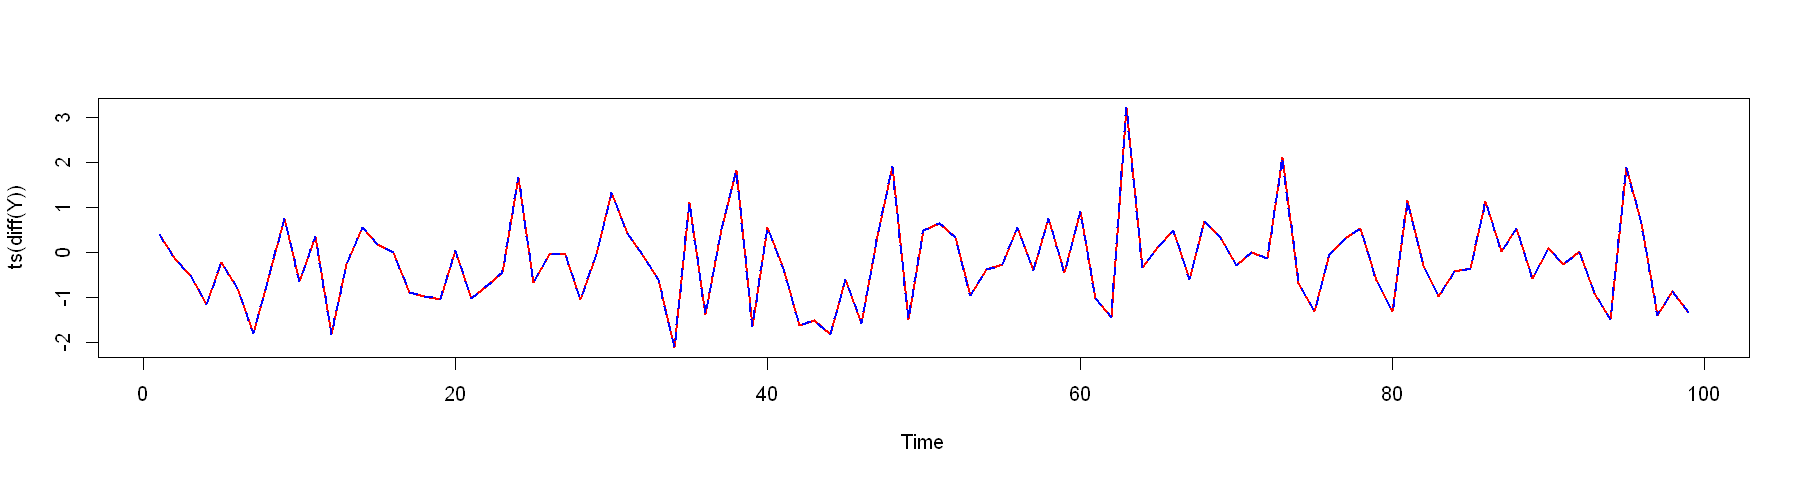

In [139]:
plot.ts(ts(diff(Y)), col = "red", lwd = 2)
lines(ts(dY), col = "blue", lty = 2, lwd = 2)

So, the two models are equivalent. For simulation and forecasting we may be more interested in $Y_t$ model, as it is the original series, which we are interested in.


## **[INFO: END]**

---
---
---

On the other hand, if our model was specified via `Arima`, we would need to differently specify the model.

In [140]:
forecast::Arima(lnyse, order = c(5, 1, 0), xreg = data.frame(tt = 1:length(lnyse)))

Series: lnyse 
Regression with ARIMA(5,1,0) errors 

Coefficients:
         ar1      ar2     ar3     ar4     ar5      tt
      0.0380  -0.0350  0.0089  0.0228  0.0923  0.0069
s.e.  0.0433   0.0434  0.0434  0.0434  0.0434  0.0020

sigma^2 estimated as 0.001645:  log likelihood=945.98
AIC=-1877.96   AICc=-1877.75   BIC=-1848.08

which is equivalent to:

In [141]:
forecast::Arima(lnyse, order = c(5, 1, 0), include.drift = TRUE)

Series: lnyse 
ARIMA(5,1,0) with drift 

Coefficients:
         ar1      ar2     ar3     ar4     ar5   drift
      0.0380  -0.0350  0.0089  0.0228  0.0923  0.0069
s.e.  0.0433   0.0434  0.0434  0.0434  0.0434  0.0020

sigma^2 estimated as 0.001645:  log likelihood=945.98
AIC=-1877.96   AICc=-1877.75   BIC=-1848.08

or

In [142]:
arima(lnyse, order = c(5, 1, 0), xreg = 1:length(lnyse))


Call:
arima(x = lnyse, order = c(5, 1, 0), xreg = 1:length(lnyse))

Coefficients:
         ar1      ar2     ar3     ar4     ar5  1:length(lnyse)
      0.0380  -0.0350  0.0089  0.0228  0.0923           0.0069
s.e.  0.0433   0.0434  0.0434  0.0434  0.0434           0.0020

sigma^2 estimated as 0.001627:  log likelihood = 945.98,  aic = -1877.96

This model, estimated via `Arima` for $\Delta Y_t$ is: 

$
\begin{cases}
\Delta Y_t &= \tilde{\delta} + u_t \\
u_t &= \gamma_1 u_{t-1} + \gamma_2 u_{t-2} + \gamma_3 u_{t-3} + \gamma_4 u_{t-4} + \gamma_5 u_{t-5} + \epsilon_t
\end{cases}
$

which is equivalent to:

$
\Delta Y_t = \tilde{\delta} (1 - \gamma_1 - \gamma_2 - \gamma_3 - \gamma_4 - \gamma_5) + \gamma_1 \Delta Y_{t-1} + \gamma_2 \Delta Y_{t-2} + \gamma_3 \Delta Y_{t-3} + \gamma_4 \Delta Y_{t-4} + \gamma_5 \Delta Y_{t-5} + \epsilon_t
$

an important distinction is **how** we arrived at such a model. In the previous case - we have transformed $Y_t$ into an equivalent model via differences in order to test whether a unit root exists. Since it did - we removed an additional insignificant parameter and were left with a model, which included both a constant and a trend in the differences model.

Assuming that the parametrization is the same as before, with $\rho = 0$ - we arrive at the following coefficient parametrizations:

- $\tilde{\delta} (1 - \gamma_1 - \gamma_2 - \gamma_3 - \gamma_4 - \gamma_5)$ is the constant.
- The remaining coefficient have the same expressions as before:<br>
$
\begin{aligned}
\phi_1 &= 1 + \gamma_1 \\
\phi_2 &= -\gamma_1 + \gamma_2\\
\phi_3 &= -\gamma_2 + \gamma_3\\
\phi_4 &= -\gamma_3 + \gamma_4\\
\phi_5 &= -\gamma_4 + \gamma_5\\
\phi_6 &= -\gamma_5
\end{aligned}
$

So the final equation is
$$
\begin{aligned}
Y_t &= \tilde{\delta} (1 - \gamma_1 - \gamma_2 - \gamma_3 - \gamma_4 - \gamma_5) + (1 + \gamma_1) Y_{t-1} + (\gamma_2-\gamma_1) Y_{t-2} + (\gamma_3 - \gamma_2) Y_{t-3} + (\gamma_4-\gamma_3) Y_{t-4} + (\gamma_5-\gamma_4) Y_{t-5} + (-\gamma_5)Y_{t-6} + \epsilon_t
\end{aligned}
$$

We will skip inputting the coefficient values into the equation as we have already done so in the previous example.

We **will** however, show a simulation example to highlight that the two equations produce the same processes.

Once again, our model for $\Delta Y_t$ is:

In [143]:
forecast::Arima(lnyse, order = c(5, 1, 0), include.drift = TRUE)

Series: lnyse 
ARIMA(5,1,0) with drift 

Coefficients:
         ar1      ar2     ar3     ar4     ar5   drift
      0.0380  -0.0350  0.0089  0.0228  0.0923  0.0069
s.e.  0.0433   0.0434  0.0434  0.0434  0.0434  0.0020

sigma^2 estimated as 0.001645:  log likelihood=945.98
AIC=-1877.96   AICc=-1877.75   BIC=-1848.08

---
---
---

## **[INFO: START]**

To again verify the equivalency between the models, we will simulate $Y_t$:

In [144]:
set.seed(123)
N <- 200
eps <- rnorm(mean = 0, sd = 1, n = N)
tt  <- 1:length(eps)

In [145]:
delta_coef <- 0.0069 * (1 - 0.0380 + 0.0350 - 0.0089 - 0.0228 - 0.0923)
delta_coef

[1] 0.0060237

In [146]:
Y <- NULL
Y[1] <- delta_coef + eps[1]
Y[2] <- delta_coef + (1 + 0.0380) * Y[1] + eps[2]
Y[3] <- delta_coef + (1 + 0.0380) * Y[2] + (-0.0350 - 0.0380) * Y[1] + eps[3]
Y[4] <- delta_coef + (1 + 0.0380) * Y[3] + (-0.0350 - 0.0380) * Y[2] + (0.0089 + 0.0350) * Y[1] + eps[4]
Y[5] <- delta_coef + (1 + 0.0380) * Y[4] + (-0.0350 - 0.0380) * Y[3] + (0.0089 + 0.0350) * Y[2] + (0.0228 - 0.0089) * Y[1] + eps[5]
Y[6] <- delta_coef + (1 + 0.0380) * Y[5] + (-0.0350 - 0.0380) * Y[4] + (0.0089 + 0.0350) * Y[3] + (0.0228 - 0.0089) * Y[2] + (0.0923 - 0.0228) * Y[1] + eps[6]
for(j in 7:N){
    Y[j] <- delta_coef + (1 + 0.0380) * Y[j-1] + (-0.0350 - 0.0380) * Y[j-2] + (0.0089 + 0.0350) * Y[j - 3] + (0.0228 - 0.0089) * Y[j - 4] + (0.0923 - 0.0228)  * Y[j - 5] − 0.0923 * Y[j - 6] + eps[j]    
}

Secondly, we will simulate $\Delta Y_t$:

In [147]:
dY <- NULL
dY[1] <- delta_coef + eps[1]
dY[2] <- delta_coef + 0.0380 * dY[1] + eps[2]
dY[3] <- delta_coef + 0.0380 * dY[2] -0.0350 * dY[1] + eps[3]
dY[4] <- delta_coef + 0.0380 * dY[3] -0.0350 * dY[2] + 0.0089 * dY[1] + eps[4]
dY[5] <- delta_coef + 0.0380 * dY[4] -0.0350 * dY[3] + 0.0089 * dY[2] + 0.0228 * dY[1] + eps[5]
for(j in 6:N){
    dY[j] <- delta_coef + 0.0380 * dY[j-1] -0.0350 * dY[j-2] + 0.0089 * dY[j - 3] + 0.0228 * dY[j - 4] + 0.0923 * dY[j - 5] + eps[j]    
}

Finally, we will assume that the first `100`, or so, observations of $Y_t$ are burn-in values (since the first couple of values assume that $Y_j = \epsilon_j = 0$, for $j \leq 0$). This means that we treat treat the first `101` $\Delta Y_t$ values as burn-in values as well and drop them:

In [148]:
Y <- Y[-c(1:100)]

In [149]:
dY <- dY[-c(1:101)]

We can compare $\Delta Y_t$ with $Y_t - Y_{t-1}$:

In [150]:
dt_compare <- data.frame(diff(Y), dY)
dt_compare$DIFFERENCE <- round(diff(Y) - dY, 10)
head(dt_compare)

diff.Y.    dY         DIFFERENCE
1  0.5067329  0.5067329 0         
2 -0.0581769 -0.0581769 0         
3 -0.4142284 -0.4142284 0         
4 -1.0578262 -1.0578262 0         
5 -0.1185169 -0.1185169 0         
6 -0.7046021 -0.7046021 0

We see that there is no difference between the simulate $Y_t - Y_{t-1}$ (`diff.Y.`), which was calculated from the simulated $Y_t$ series, and $\Delta Y_t$ (`dY`).

We can also visually compare the charts:

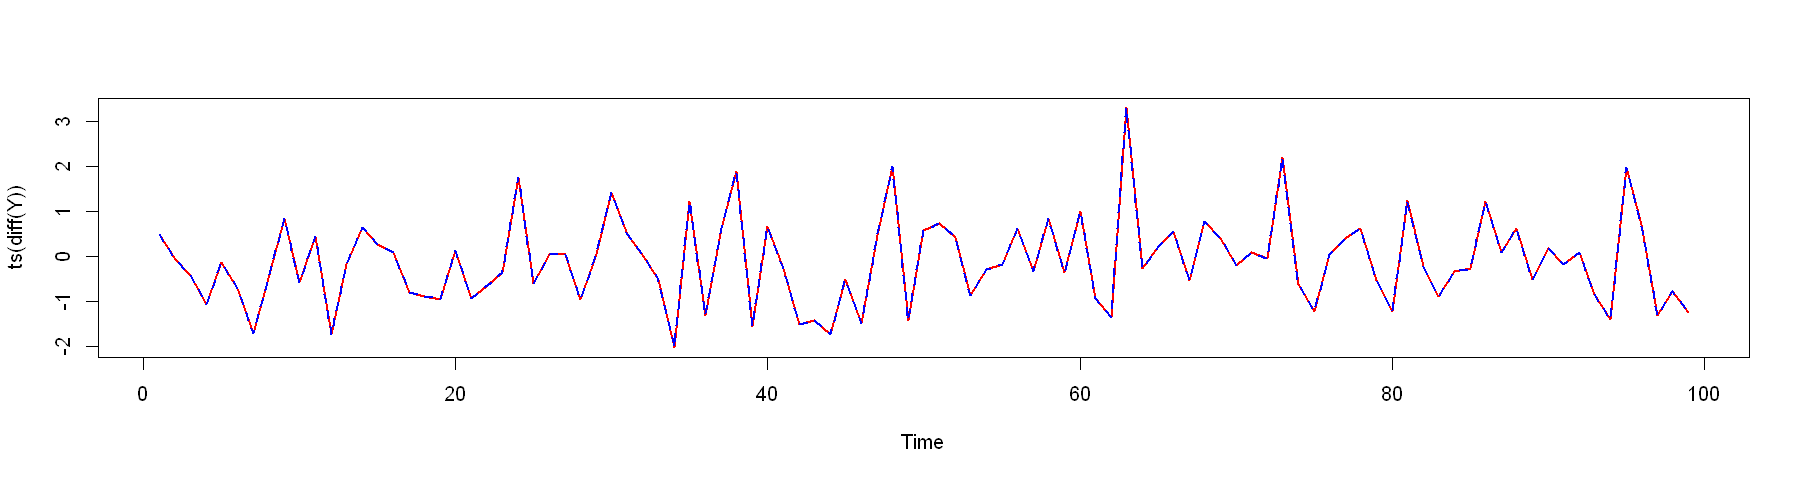

In [151]:
plot.ts(ts(diff(Y)), col = "red", lwd = 2)
lines(ts(dY), col = "blue", lty = 2, lwd = 2)

## **[INFO: END]**

----
----
----

# (6) Calculate the \(10\)-step ahead forecasts for the original series.

In [152]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 10)
options(repr.plot.height = 4)

In [153]:
tt_forc <- data.frame(tt = length(lnyse) + 1:10)

In [154]:
mdl_4_1_forc <- forecast(mdl_4_1, h = 10, xreg = tt_forc)
mdl_4_2_forc <- forecast(mdl_4_2, h = 10)

We will plot the original historical data, the fitted values and the forecasts.

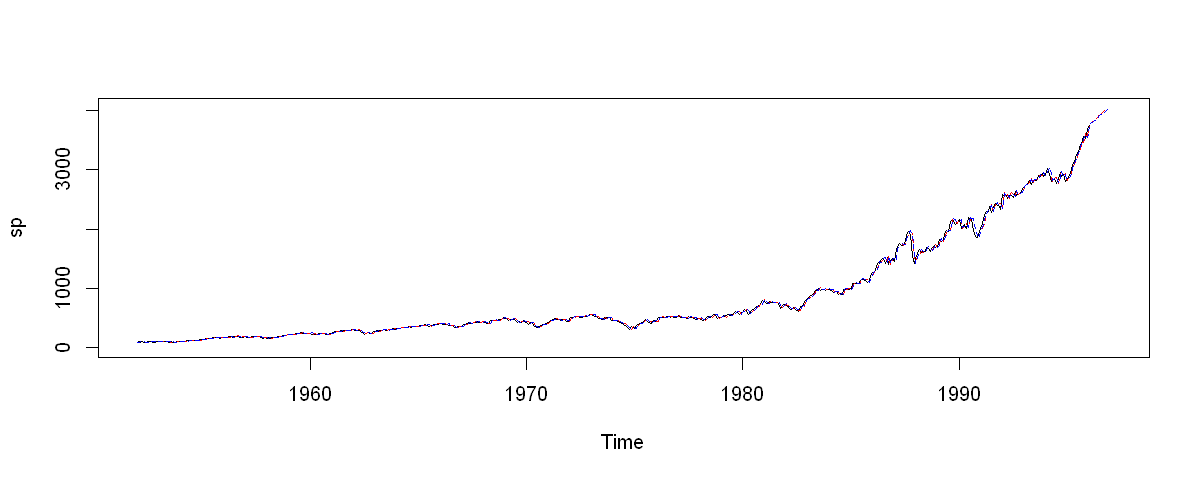

In [155]:
plot.ts(exp(lnyse),
        xlim = c(floor(min(time(lnyse))), floor(max(time(lnyse))) + 1), 
        ylim = c(0, max(exp(mdl_4_1_forc$mean), exp(mdl_4_2_forc$mean))))
#
lines(exp(fitted(mdl_4_1)), col = "red", lty = 2)
lines(exp(fitted(mdl_4_2)), col = "blue", lty = 2)
#
lines(exp(mdl_4_1_forc$mean), col = "red", lty = 2)
lines(exp(mdl_4_2_forc$mean), col = "blue", lty = 2)

 As it is difficult to see, we will also reduce the time window to see the last few years

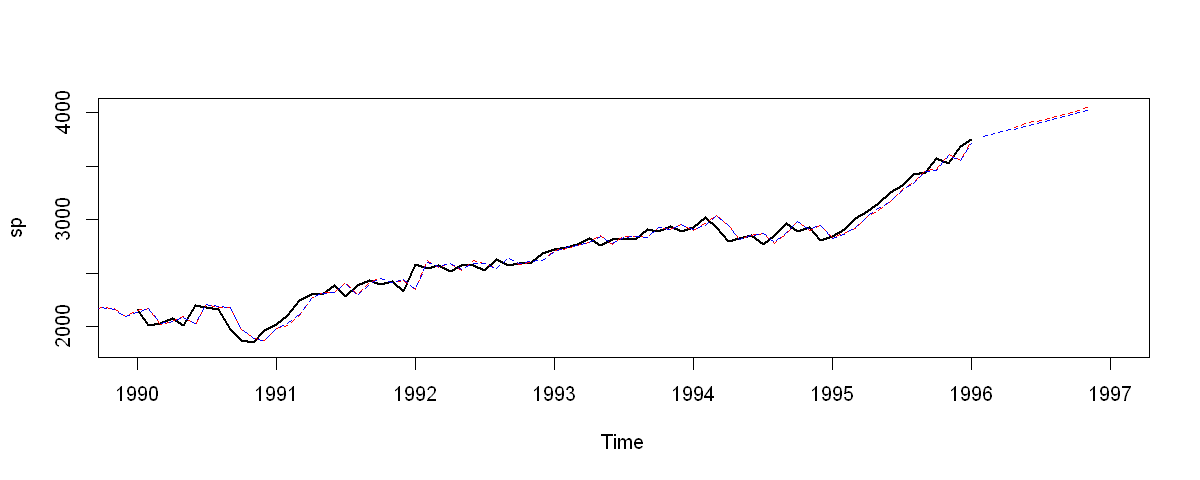

In [156]:
plot.ts(window(exp(lnyse), start = 1990), 
        xlim = c(1990, floor(max(time(lnyse))) + 1), 
        ylim = c(1800, max(exp(mdl_4_1_forc$mean), exp(mdl_4_2_forc$mean))), 
        lwd = 2)
#
lines(exp(fitted(mdl_4_1)), col = "red", lty = 2)
lines(exp(fitted(mdl_4_2)), col = "blue", lty = 2)
#
lines(exp(mdl_4_1_forc$mean), col = "red", lty = 2)
lines(exp(mdl_4_2_forc$mean), col = "blue", lty = 2)

We see that the model forecasts do not appear to differ by a whole lot.

---
---

# (7) Model Cross-validation

Assume that our best model (again, we can select it via AIC or BIC but we choose a more complex one for a more general example) is:

In [157]:
mdl_4_1

Series: lnyse 
Regression with ARIMA(5,1,0) errors 

Coefficients:
         ar1      ar2     ar3     ar4     ar5      tt
      0.0380  -0.0350  0.0089  0.0228  0.0923  0.0069
s.e.  0.0433   0.0434  0.0434  0.0434  0.0434  0.0020

sigma^2 estimated as 0.001645:  log likelihood=945.98
AIC=-1877.96   AICc=-1877.75   BIC=-1848.08

In [158]:
forecast::Arima(lnyse, order = c(5, 1, 0), include.drift = TRUE)

Series: lnyse 
ARIMA(5,1,0) with drift 

Coefficients:
         ar1      ar2     ar3     ar4     ar5   drift
      0.0380  -0.0350  0.0089  0.0228  0.0923  0.0069
s.e.  0.0433   0.0434  0.0434  0.0434  0.0434  0.0020

sigma^2 estimated as 0.001645:  log likelihood=945.98
AIC=-1877.96   AICc=-1877.75   BIC=-1848.08

So, we will use $k$ of around $20\%$ of our series and create $k = \lfloor 0.2 \cdot T \rfloor$ samples and for each sample we will:

- estimate the model;
- forecast one period ahead;
- calculate the error between the forecast and the true value;

In [159]:
forcast_errors <- NULL
mdl_params     <- NULL

In [160]:
k <- floor(length(lnyse) * 0.2)

In [161]:
k

[1] 105

In [162]:
for(i in k:1){
    # get the sample
    smpl <- lnyse[1:(length(lnyse) - i)]
    # re-estimate the model:
    tt <- data.frame(tt = 1:length(smpl))
    smpl_mdl <- forecast::Arima(smpl, order = c(5, 1, 0), include.drift = TRUE)
    # calculate the one-step ahead forecast
    smpl_forc_1 <- forecast(smpl_mdl, h = 1) # since we have decided to include the trend as an exogeneous regressor, 
                                                                      # alternatively - see the code in this file on how to include it automatically
    # calculate the forecast error:
    tmp_e <- lnyse[length(smpl) + 1] - smpl_forc_1$mean
    
    # save the parameters:
    mdl_params <- rbind(mdl_params, coef(smpl_mdl))
    # Save the forecast errors:
    forcast_errors <- c(forcast_errors, tmp_e)
}

In [163]:
tail(forcast_errors, 10)

[1]  0.017620987  0.019993786  0.024964316  0.010563250  0.022469878
 [6] -0.005528249  0.029867446 -0.023850741  0.037985968  0.006078093

The root mean squared errror is:

In [164]:
paste0("RMSE = ", round(sqrt(mean(forcast_errors^2)), 5))

[1] "RMSE = 0.04047"

The parameter mean is:

In [165]:
t(apply(mdl_params, 2, mean))

ar1        ar2         ar3        ar4        ar5        drift      
[1,] 0.04456041 -0.04141763 0.01444384 0.02751923 0.09970742 0.006606406

and the variance is:

In [166]:
t(apply(mdl_params, 2, var))

ar1          ar2          ar3          ar4          ar5         
[1,] 9.209398e-05 5.081817e-05 0.0001011694 9.729149e-05 7.961683e-05
     drift       
[1,] 2.978902e-08

We can visualize the series as separate plots:

In [167]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 10)
options(repr.plot.height = 6)

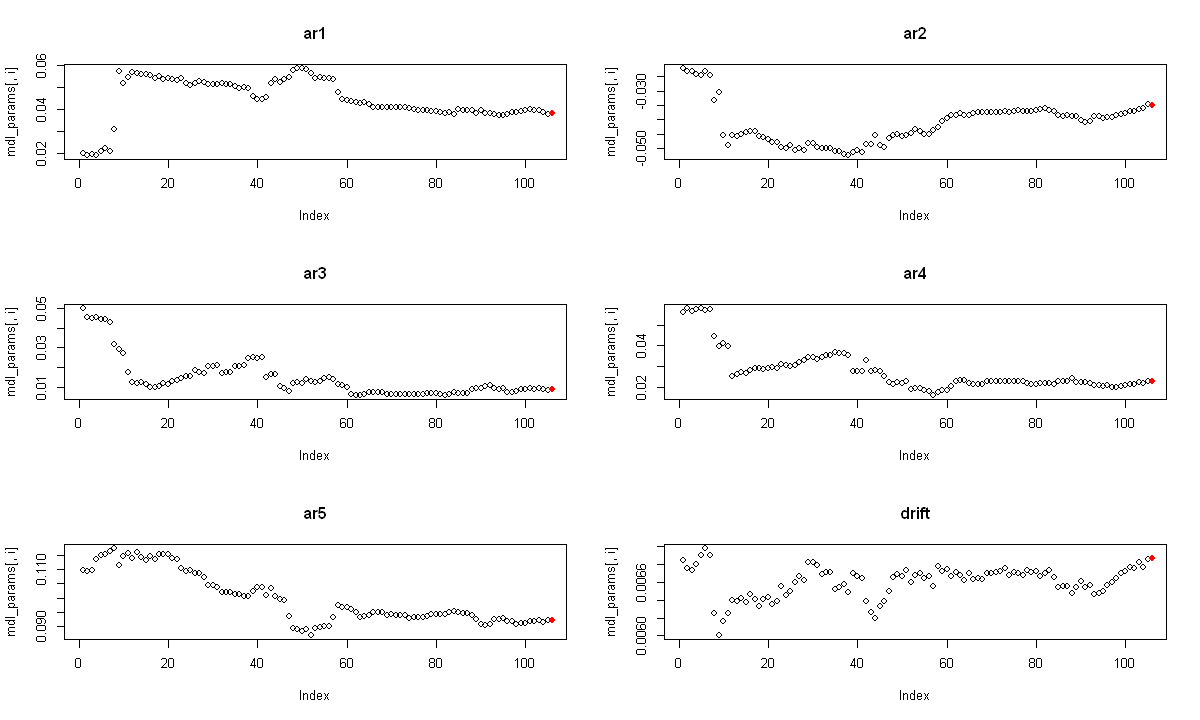

In [168]:
par(mfrow = c(3, 2))
for(i in 1:ncol(mdl_params)){
    plot(mdl_params[, i], main = colnames(mdl_params)[i])
    points(length(mdl_params[, i]) + 1,  coef(mdl_4_1)[i], col = "red", pch = 19)
}

The red dot coincides with the **full sample estimate** (we can also use `abline` to draw it as a horizontal line, but we do not want to treat it as a true coefficient value).

We see that as the sample size increases (here the sample size is `T - k + index`), the estimates converge to some value (**maybe if we had more data the values would continue to converge to some unknown value?**). The `drift` estimate exhibits more variation compared to the remaining parameters so it is unclear how stable it would be if we had a larger sample size.

---
---
---

## **[INFO: START]**

We can also use a built-in function to carry out the cross validation for us. We do need to specify our model as a spearate function for this process to work:

In [169]:
far1 <- function(x, h){
    forecast(Arima(x, order = c(5, 1, 0), include.drift = TRUE), h = h)
}
#
ts_cv_out <- tsCV(y = lnyse, forecastfunction = far1, h = 1)

In [170]:
head(ts_cv_out, 20)

               Jan           Feb           Mar           Apr           May
1952            NA            NA            NA            NA            NA
1953            NA            NA            NA -0.0326470999            NA
               Jun           Jul           Aug           Sep           Oct
1952            NA  0.0570292521 -0.0717783295            NA -0.0143642770
1953 -0.0652138685 -0.0002246052 -0.0585932384                            
               Nov           Dec
1952  0.0072660919  0.0122336911
1953                            

Note that this process is long and performs a cross-validation on the **whole dataset**. We can compare the last few values with our manually calculated ones:

In [171]:
tail(ts_cv_out[-c(1:(length(log_passengers) - k - 1))], 11)

[1]  0.017620987  0.019993786  0.024964316  0.010563250  0.022469878
 [6] -0.005528249  0.029867446 -0.023850741  0.037985968  0.006078093
[11]           NA

We see that the errors are the same as from our manual calculations:

In [172]:
tail(forcast_errors, 10)

[1]  0.017620987  0.019993786  0.024964316  0.010563250  0.022469878
 [6] -0.005528249  0.029867446 -0.023850741  0.037985968  0.006078093

## **[INFO: END]**

---
---
---

## A Look at Seasonal ARIMA models

The airpassangers series, which we analysed previously, may also be seasonally integrated. This would require us to repeat the previous steps not only on non-seasonal differences, but on the seasonal differences as well (as well as combining both seasonal and non-seasonal differences). Here we will simply provide the output of the `auto.arima` function:

In [173]:
mdl_auto = forecast::auto.arima(log_passengers)

In [174]:
mdl_auto

Series: log_passengers 
ARIMA(0,1,1)(0,1,1)[12] 

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 estimated as 0.001371:  log likelihood=244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

The model appears to fit the data quite well. It appears that the series exhibited unit roots in both the seasonal and non-seasonal autoregressive components.

We can forecast the logarithms of the series, as well as plot the fitted values as follows:

In [175]:
# Set plot options in Jupyter Lab
options(repr.plot.width = 10)
options(repr.plot.height = 5)

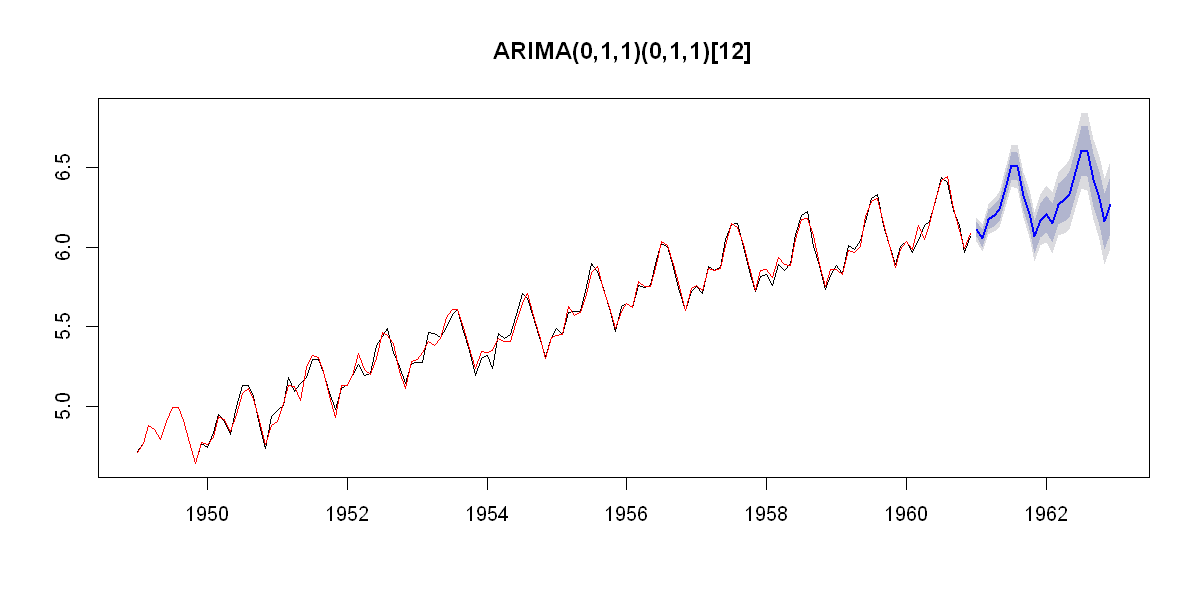

In [176]:
plot(forecast(mdl_auto), main = forecast(mdl_auto)$method)
lines(fitted.values(mdl_auto), col = "red")

In order to get the original values, we would need to take exponents of appropriate elements from the `forecast(mdl_auto)` variable. A more convenient way is fitting the original series and specifying a logarithmic transformation:

In [177]:
mdl_auto = forecast::auto.arima(airpass, lambda = 0)

In [178]:
mdl_auto

Series: airpass 
ARIMA(0,1,1)(0,1,1)[12] 
Box Cox transformation: lambda= 0 

Coefficients:
          ma1     sma1
      -0.4018  -0.5569
s.e.   0.0896   0.0731

sigma^2 estimated as 0.001371:  log likelihood=244.7
AIC=-483.4   AICc=-483.21   BIC=-474.77

We can forecast the series, as well as plot the fitted values of the original data:

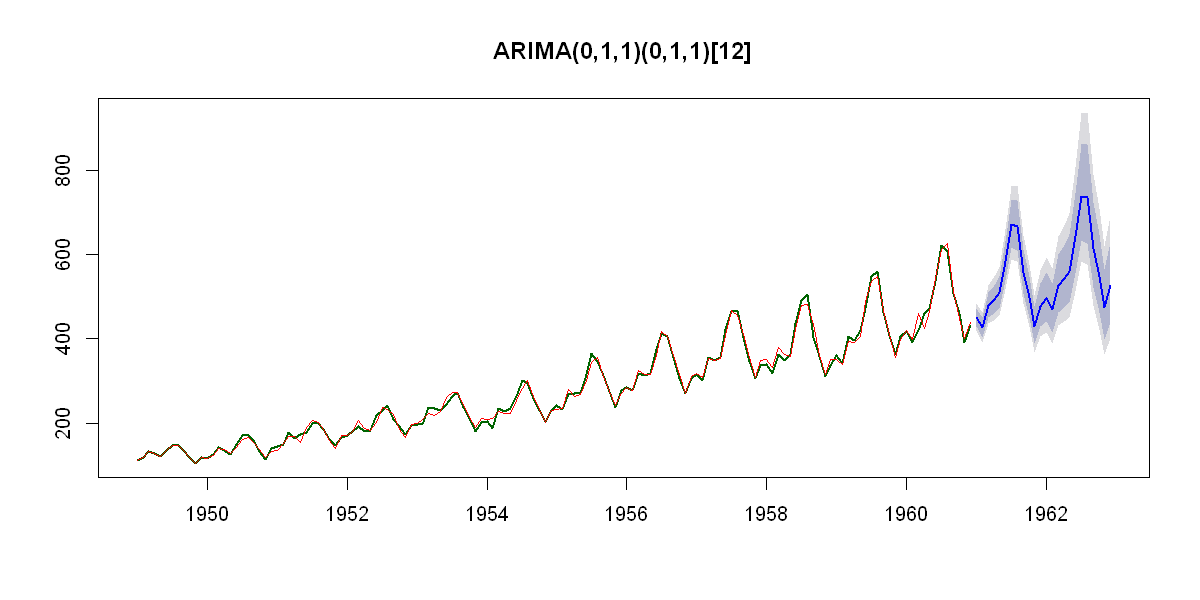

In [179]:
plot(forecast(mdl_auto), main = forecast(mdl_auto)$method)
lines(airpass, col = "darkgreen", lwd = 2) # to verify that it is indeed the original series
lines(fitted.values(mdl_auto), col = "red")